# Important Frequencies Selection

## Import Libraries and seed
Import the necessary libraries for data processing, model building, training, and evaluation. Adding a seed ensures reproducibility by making sure that the random number generation is consistent across different runs.

In [22]:
import os
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import joblib
import matplotlib.pyplot as plt
import graphviz 
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import export_graphviz
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier

import seaborn as sns
import warnings

from scipy.stats import zscore



# import wandb

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    return seed

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Set seed for reproducibility
seed = set_seed(42)


Using device: cpu


In [23]:
def load_data_from_directory(input_path):
    data_frames = []
    for file in os.listdir(input_path):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(input_path, file), delimiter=';', header=0)
            data_frames.append(df)
    data = pd.concat(data_frames, ignore_index=True)

    return data

## Preprocessing Data - Dispersion
Define a function to preprocess the data. This includes encoding categorical labels and standardizing the features.

In [24]:
def calculate_averages_and_dispersion(df, data_percentage):

    results = []
    for (sample, freq), group in df.groupby(['Sample', 'Frequency (GHz)']):
        window_size = max(1, int(len(group) * data_percentage / 100))
        # print(f"Processing sample: {sample}, frequency: {freq} with window size: {window_size}")
        for start in range(0, len(group), window_size):
            window_data = group.iloc[start:start + window_size]
            mean_values = window_data[['LG (mV)', 'HG (mV)']].mean()
            std_deviation_values = window_data[['LG (mV)', 'HG (mV)']].std()
            results.append({
                'Frequency (GHz)': freq,
                'LG (mV) mean': mean_values['LG (mV)'],
                'HG (mV) mean': mean_values['HG (mV)'],
                'LG (mV) std deviation': std_deviation_values['LG (mV)'],
                'HG (mV) std deviation': std_deviation_values['HG (mV)'],
                # 'Thickness (mm)': window_data['Thickness (mm)'].iloc[0], ## COMMENT
                'Sample': sample,
            })
    results_df = pd.DataFrame(results)
    # results_df.to_csv(output_file, sep=';', index=False)
    # print(f"Processed {input_file} and saved to {output_file}")
    # print(results_df)
    return results_df

## Pivoting Frequency values to columns

In [25]:
def freq_as_variable(df, data_percentage):
    '''Modify df to have Frequency values (100,110,120 and so on) as input variables in the columns'''

    # Remove Thickness column
    if 'Thickness (mm)' in df.columns:
        df = df.drop(columns=['Thickness (mm)'])

    if data_percentage > 0:
        # 1s window_size 100/27s = 3.7% of the data is used for each window
        df_window = calculate_averages_and_dispersion(df, data_percentage) 

        # Add a unique identifier column to avoid duplicate entries in the index
        df_window['unique_id'] = df_window.groupby(['Sample', 'Frequency (GHz)']).cumcount()

        # Pivot the DataFrame to wide format
        df_pivot = df_window.pivot(index=['Sample', 'unique_id'], columns='Frequency (GHz)')

        # Flatten the MultiIndex columns - Ordered by Frequency + (HG mean, HG std deviation, LG mean, LG std deviation)
        df_pivot.columns = [' '.join([str(col[1]), str(col[0])]) for col in df_pivot.columns]

        # Drop columns with all NaN values
        df_pivot = df_pivot.dropna(axis=1, how='all')

        # Reset index to make 'Sample' and 'unique_id' columns again
        df_pivot = df_pivot.reset_index()

        # Remove 'unique_id' column
        df_pivot = df_pivot.drop(columns=['unique_id'])
    else:
        # If data_percentage is 0, do not calculate mean and std deviation, use the original data
        df['unique_id'] = df.groupby(['Sample', 'Frequency (GHz)']).cumcount()
        df_pivot = df.pivot(index=['Sample', 'unique_id'], columns='Frequency (GHz)')
        df_pivot.columns = [' '.join([str(col[1]), str(col[0])]) for col in df_pivot.columns]
        df_pivot = df_pivot.dropna(axis=1, how='all')
        df_pivot = df_pivot.reset_index()
        df_pivot = df_pivot.drop(columns=['unique_id'])

    # Optional - Sort the columns if needed
    df_pivot = df_pivot.reindex(sorted(df_pivot.columns), axis=1)

    return df_pivot

In [75]:
# Load the data from the directory
input_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_3_repeatibility/processed/'
# input_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_2_plastics/processed/test/repeatibility/'
input_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_4_plastics/processed/'



# input_path = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test'

df = load_data_from_directory(input_path)

df = pd.concat([df[['Frequency (GHz)', 'LG (mV)', 'HG (mV)']], df[['Sample']]], axis=1)

df.head()

# show random rows
df.sample(15)



Frequency (GHz)    LG (mV)     HG (mV) Sample
108361            220.0   5.036015    0.000000   E3_3
13600             350.0   1.465023  720.028087   B1_2
165324            250.0   1.739714   11.323428  REF_1
34669             280.0   3.143694    0.732511   B1_5
102570            110.0  68.276156    0.091565   E3_3
78926             130.0  39.128311    0.427276   C1_7
137453            250.0   1.648150  861.768994   E3_6
154140            540.0  -0.610426   32.993529   E3_6
74002             530.0   0.213649   24.935905   C1_4
6735              220.0   6.501038    1.098764   B1_2
109079            240.0   4.852887    0.091571   E3_3
174476            420.0  -0.549383  274.478109  REF_1
9576              270.0   4.608717   -0.213659   B1_2
76791             580.0   0.183128   15.291173   C1_4
15895             400.0   0.671469  251.342937   B1_2

## Balance Dataset

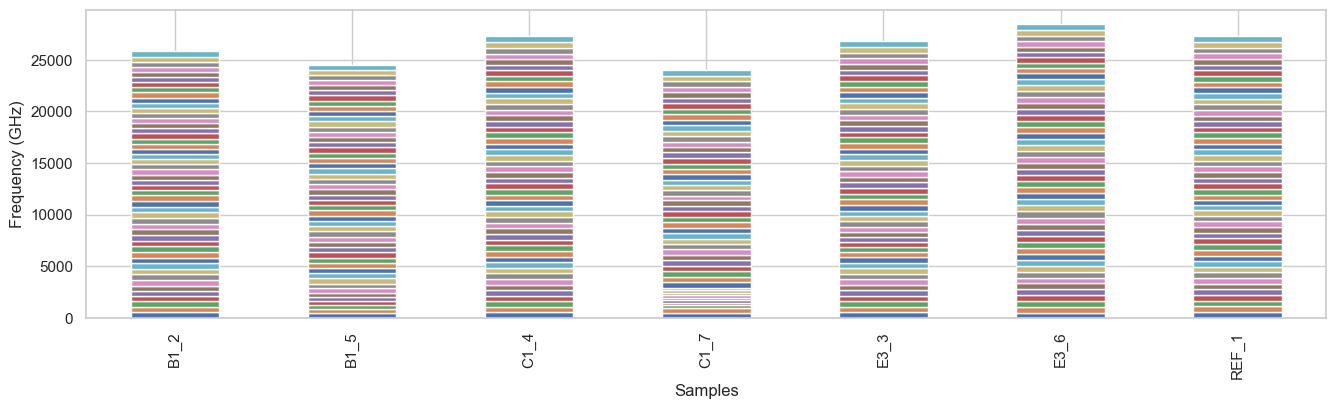

Mode value: 548


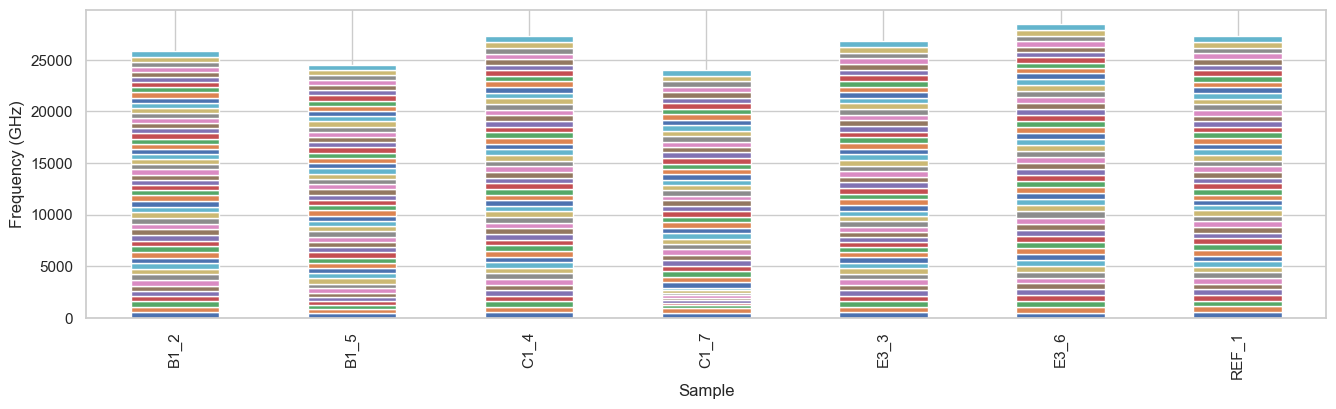

In [76]:
# Number of samples per frequency and Sample
bx = df.groupby(['Sample', 'Frequency (GHz)']).size().unstack().plot.bar(figsize=(16, 4), stacked=True)
bx.set_xlabel('Samples')
bx.set_ylabel('Frequency (GHz)')
plt.tight_layout()
#no legend
bx.get_legend().remove()
plt.show()

# Balance the data by taking the mode of samples per frequency
mode = df.groupby(['Sample', 'Frequency (GHz)']).size().mode()[0]
print(f'Mode value: {mode}')
mode = 2350

# Function to reduce samples to the mode value
def reduce_to_mode(df, sample, frequency, mode):
    # Filter the DataFrame for the specific sample and frequency
    freq_df = df[(df['Sample'] == sample) & (df['Frequency (GHz)'] == frequency)]
    # If the number of samples is greater than the mode, sample down to the mode
    if len(freq_df) > mode:
        return freq_df.sample(n=mode, random_state=42)
    return freq_df

# Apply the function to reduce samples for each combination of Sample and Frequency (GHz)
balanced_data = []
for (sample, frequency), group in df.groupby(['Sample', 'Frequency (GHz)']):
    balanced_data.append(reduce_to_mode(df, sample, frequency, mode))

# Combine the balanced samples into a single DataFrame
df_balanced = pd.concat(balanced_data)

bx = df_balanced.groupby(['Sample', 'Frequency (GHz)']).size().unstack().plot.bar(figsize=(16, 4), stacked=True)
bx.set_ylabel('Frequency (GHz)')
plt.tight_layout()
# legend small
bx.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
#remove legend
bx.get_legend().remove()
plt.show()

## Sample a test set

In [86]:
# train_set, test_set = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Sample']) 
test_percentage = 0.25
# train_set, test_set = train_test_split(df, test_size=test_percentage, random_state=42) 
# Shuffle the data
df_balanced = df_balanced.sample(frac=1, random_state=42)
# train_set, test_set = train_test_split(df_balanced, test_size=test_percentage, random_state=42) 

# stratify=df['Sample'] to keep the same proportion of samples in the train and test set


## Spectrogram

In [21]:

from scipy.signal import spectrogram

def plot_spectrograms(df, signal_column='HG (mV)', freq_column='Frequency (GHz)', 
                      nperseg=256, noverlap=128, figsize=(10,6), 
                      cmap='viridis'):
    """
    Plot spectrograms for each unique sample in the DataFrame.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the signal data
    signal_column : str, default='HG (mV)'
        Name of the column containing signal values
    freq_column : str, default='Frequency (GHz)' 
        Name of the column containing frequency values
    nperseg : int, default=256
        Length of each segment for spectrogram
    noverlap : int, default=128
        Number of points to overlap between segments
    figsize : tuple, default=(10,6)
        Figure size in inches
    save_path : str, optional
        Path to save the plots. If None, plots are displayed only
    cmap : str, default='viridis'
        Colormap for the spectrogram
    """
    
    # Input validation
    if df.empty:
        raise ValueError("DataFrame is empty")
        
    required_cols = ['Sample', signal_column, freq_column]
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"DataFrame must contain columns: {required_cols}")
        
    samples = df['Sample'].unique()
    
    for sample in samples:
        sample_df = df[df['Sample'] == sample]
        
        if len(sample_df) < nperseg:
            print(f"Warning: Sample {sample} has fewer points than nperseg. Skipping.")
            continue
            
        # Generate frequency sweep
        min_freq = sample_df[freq_column].min()
        max_freq = sample_df[freq_column].max()
        sweep = np.linspace(min_freq, max_freq, len(sample_df))
        
        try:
            # Generate spectrogram
            f, t, Sxx = spectrogram(sample_df[signal_column], fs=sweep, 
                                   nperseg=nperseg, noverlap=noverlap)
            
            # Plot
            plt.figure(figsize=figsize)
            plt.pcolormesh(t, f, 10 * np.log10(np.maximum(Sxx, 1e-10)), 
                          shading='gouraud', cmap=cmap)
            plt.colorbar(label='Intensity [dB]')
            plt.ylabel('Frequency [GHz]')
            plt.xlabel('Time [s]')
            plt.title(f'Spectrogram for Sample {sample}')
            
            plt.show()
            plt.close()
            
        except Exception as e:
            print(f"Error processing sample {sample}: {str(e)}")
            continue

# Example usage:
plot_spectrograms(df_balanced)

Error processing sample REF_1: operands could not be broadcast together with shapes (129,) (38300,) 
Error processing sample REF_10: operands could not be broadcast together with shapes (129,) (27045,) 
Error processing sample REF_11: operands could not be broadcast together with shapes (129,) (27177,) 
Error processing sample REF_12: operands could not be broadcast together with shapes (129,) (26219,) 
Error processing sample REF_13: operands could not be broadcast together with shapes (129,) (27403,) 
Error processing sample REF_14: operands could not be broadcast together with shapes (129,) (25775,) 
Error processing sample REF_15: operands could not be broadcast together with shapes (129,) (25361,) 
Error processing sample REF_2: operands could not be broadcast together with shapes (129,) (37037,) 
Error processing sample REF_3: operands could not be broadcast together with shapes (129,) (38622,) 
Error processing sample REF_4: operands could not be broadcast together with shapes (

## Data Distribution per frequency and Sample

   Frequency (GHz)   LG (mV)    HG (mV) Sample
0            100.0 -0.274692  28.903674   B1_2
1            100.0 -0.152607  29.605664   B1_2
2            100.0  0.549383  28.567940   B1_2
3            100.0  0.000000  30.155048   B1_2
4            100.0 -1.037724  30.216090   B1_2


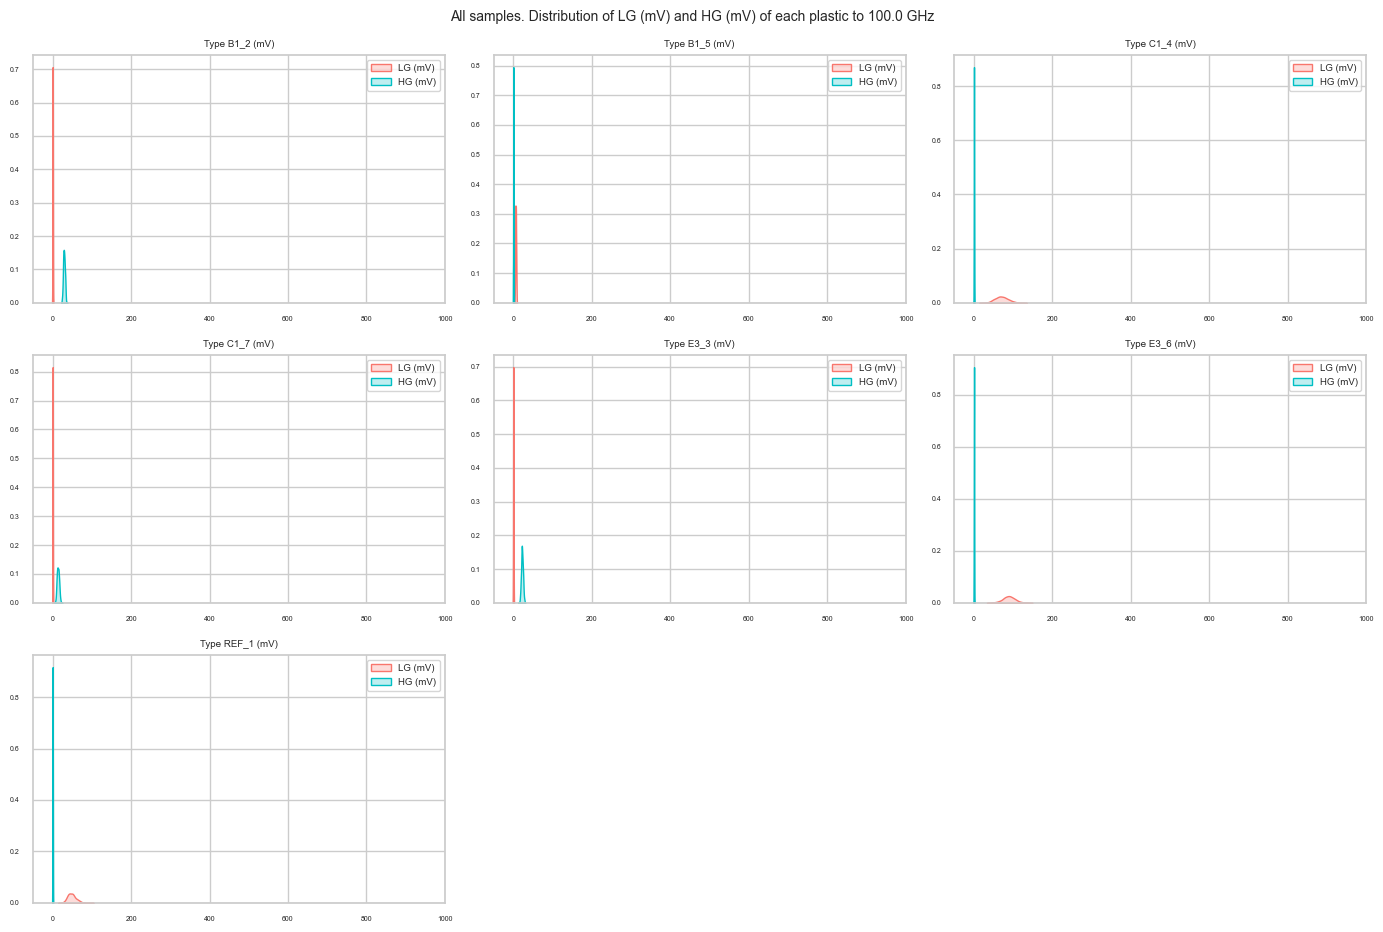

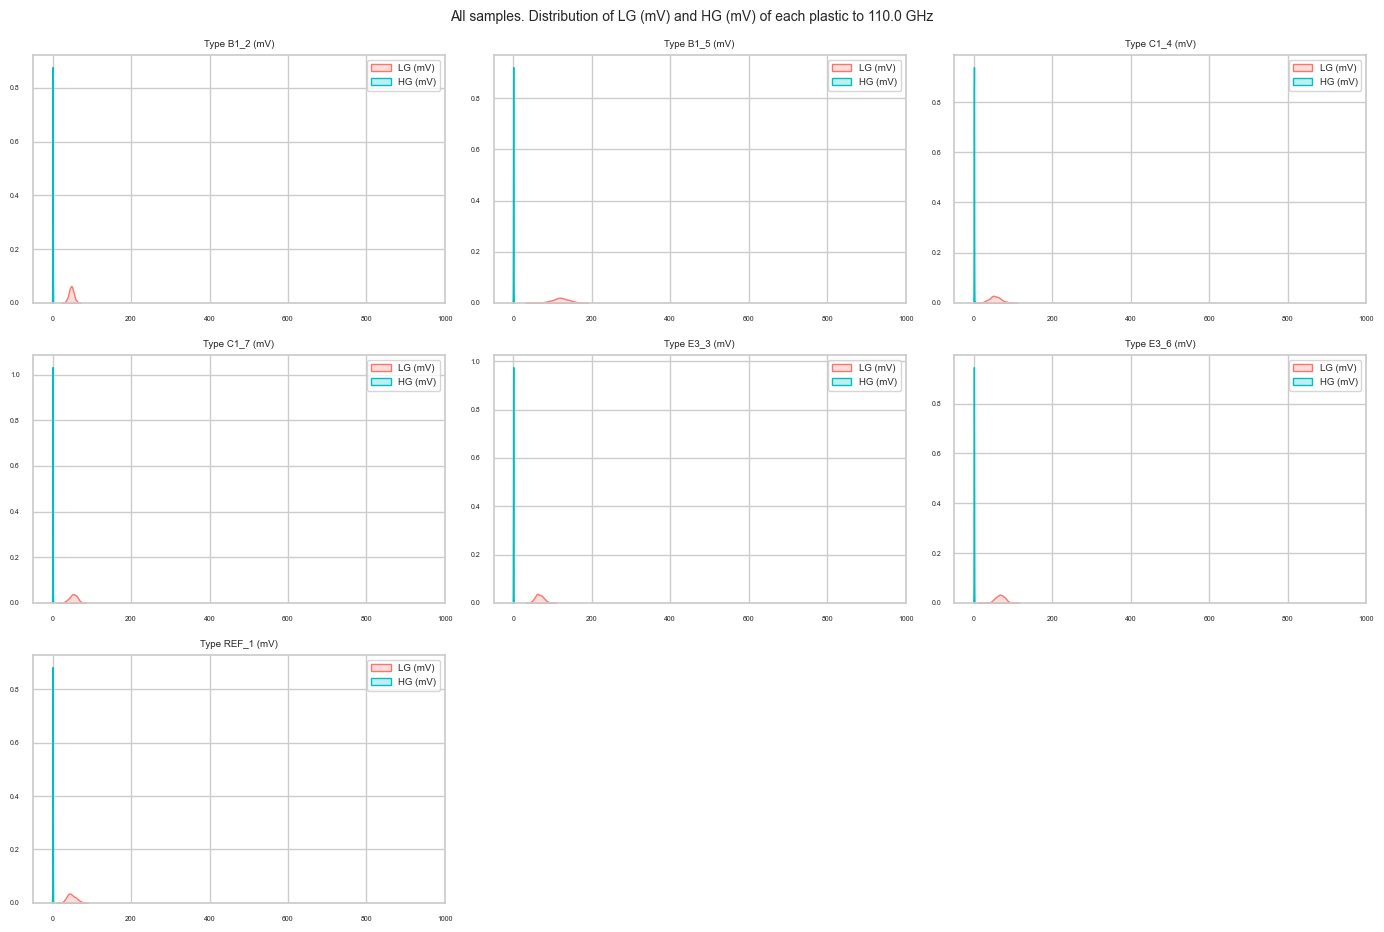

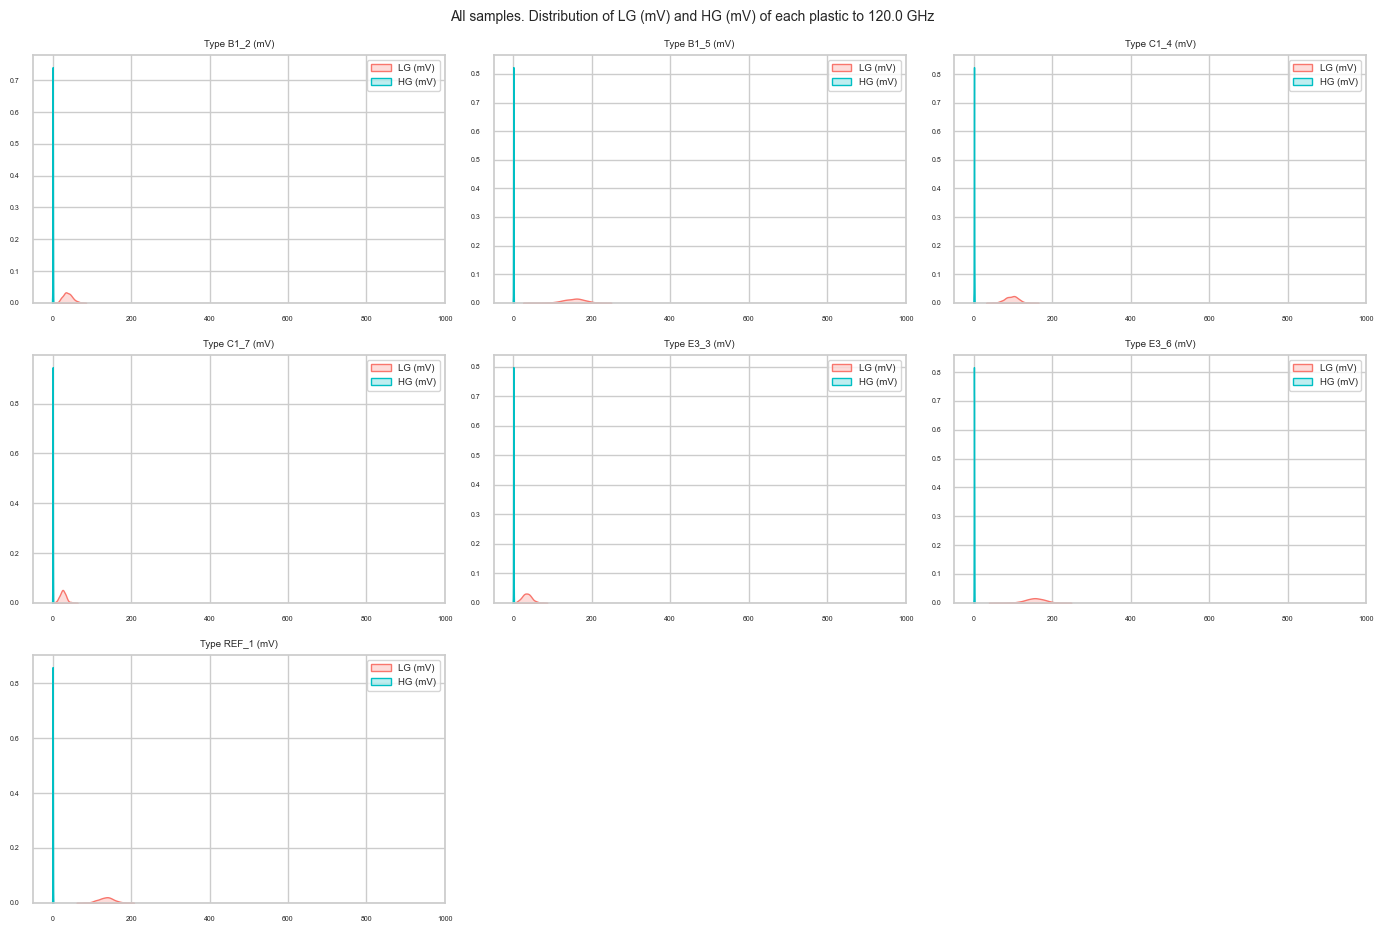

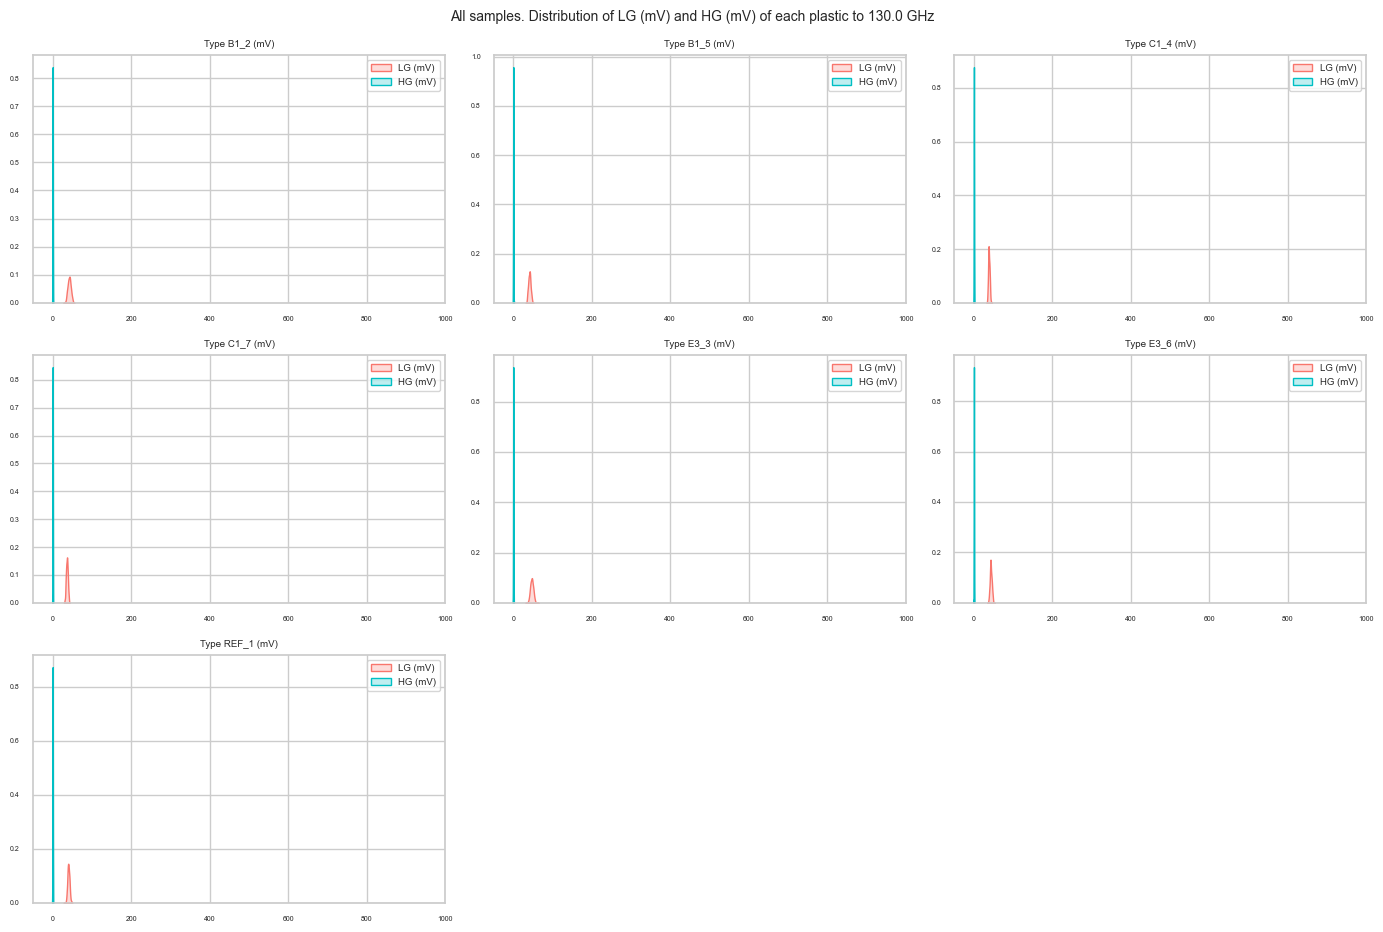

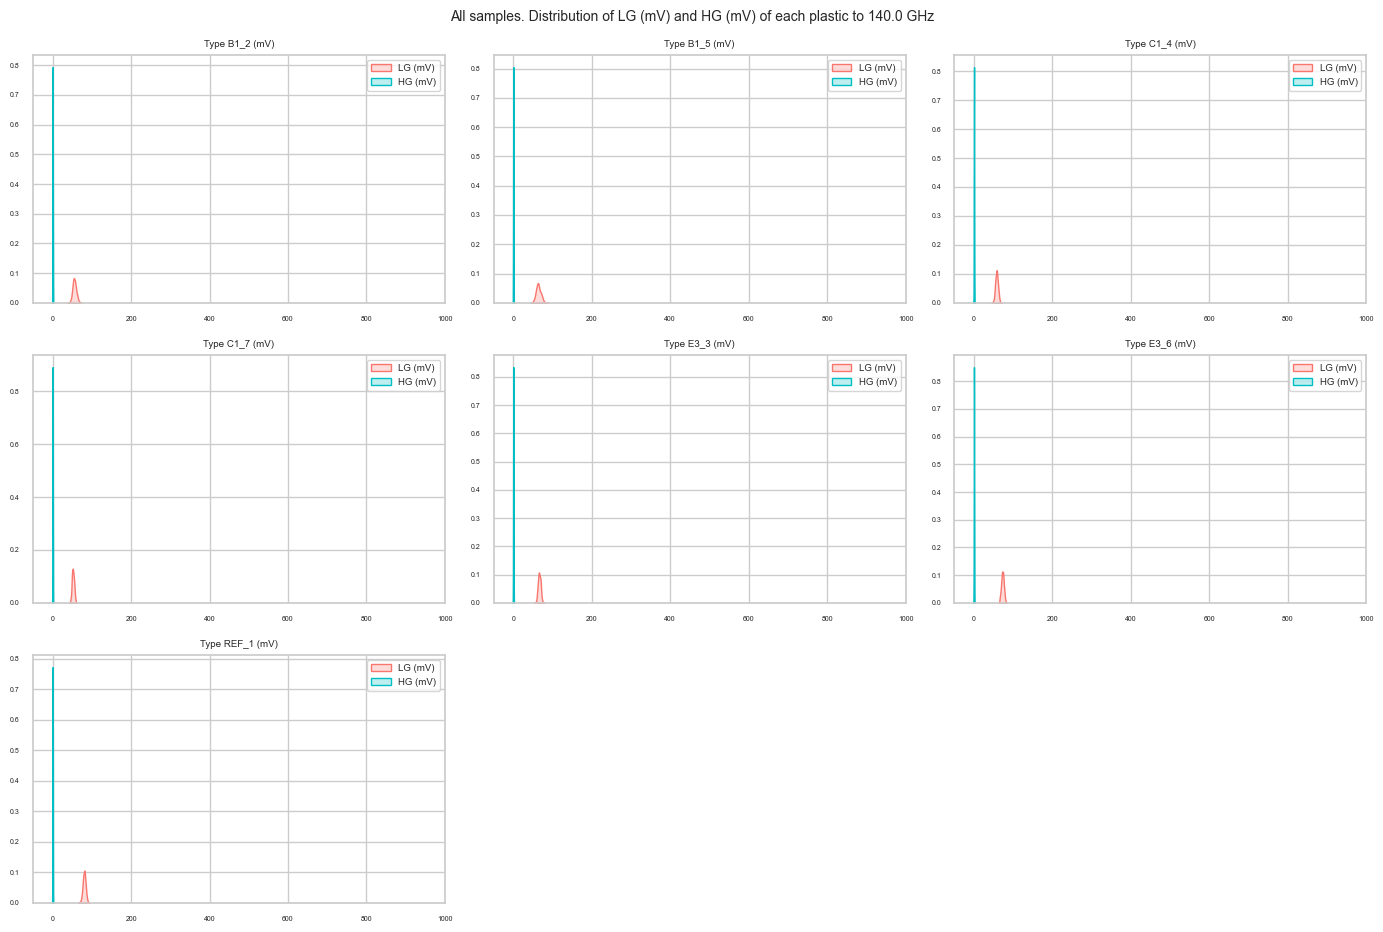

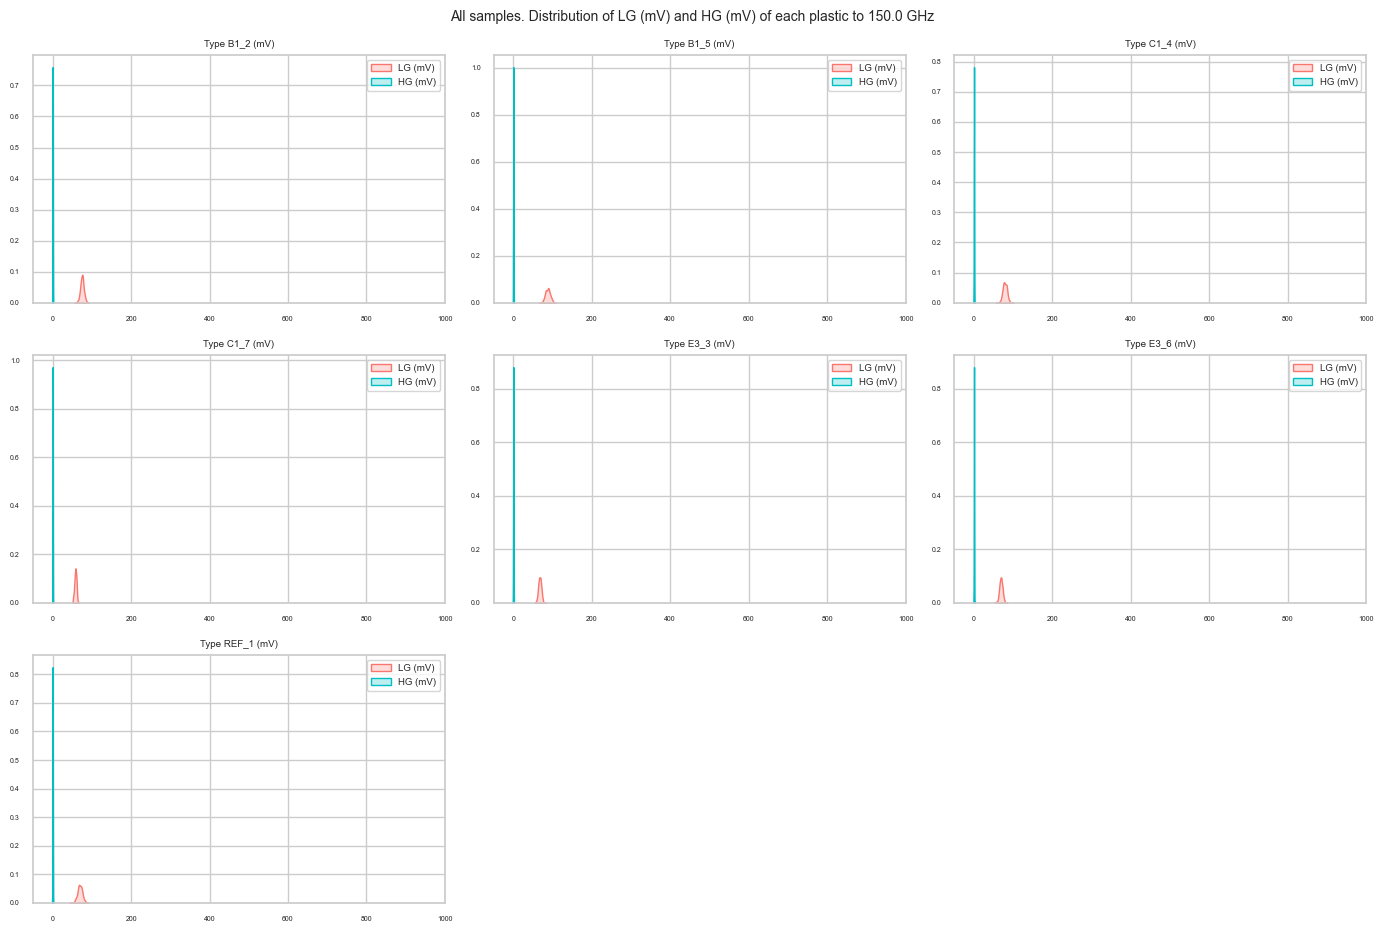

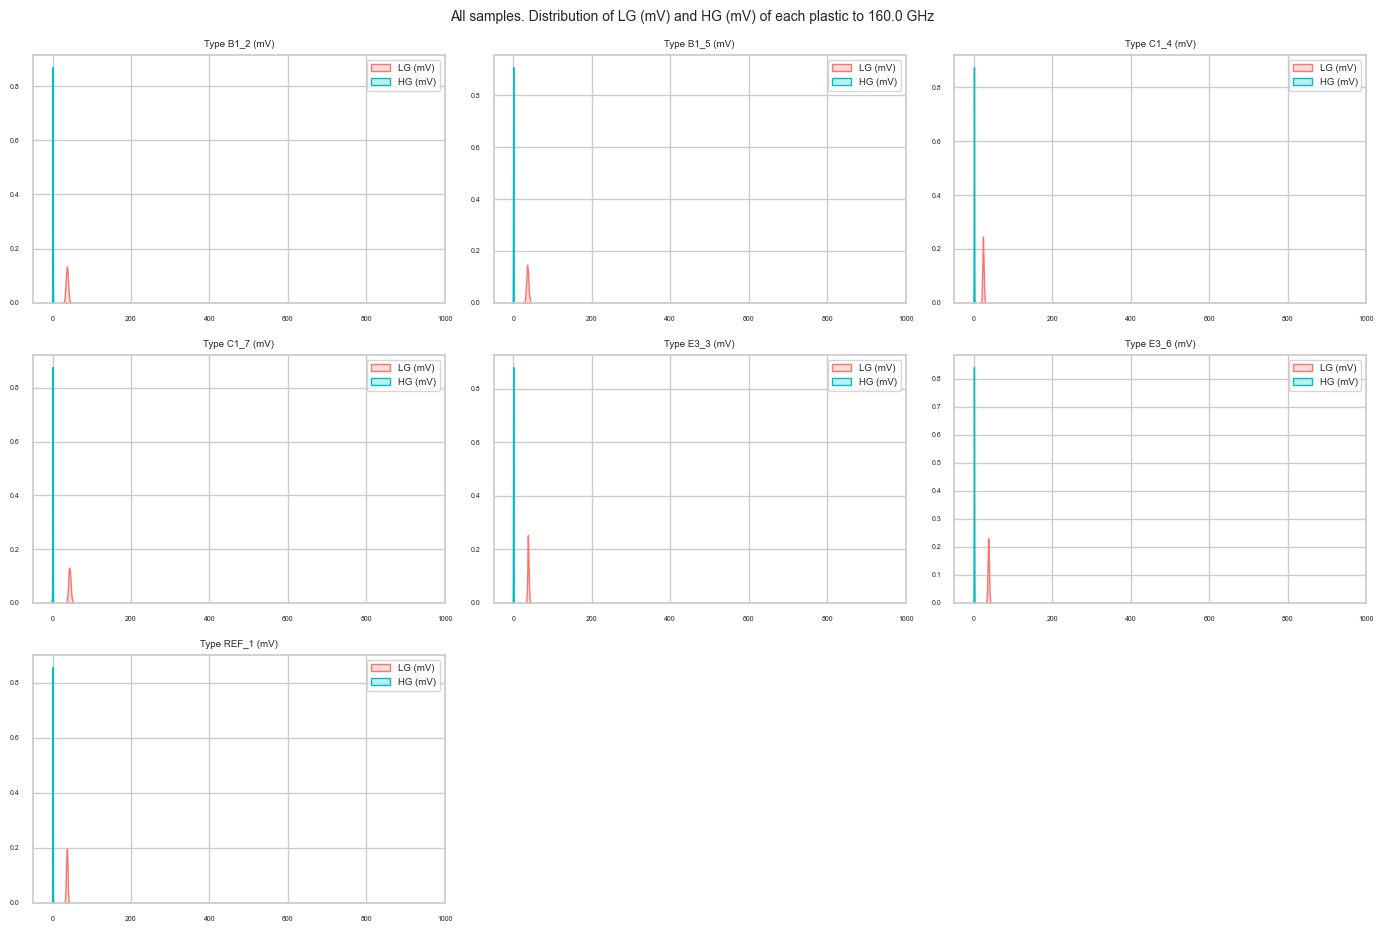

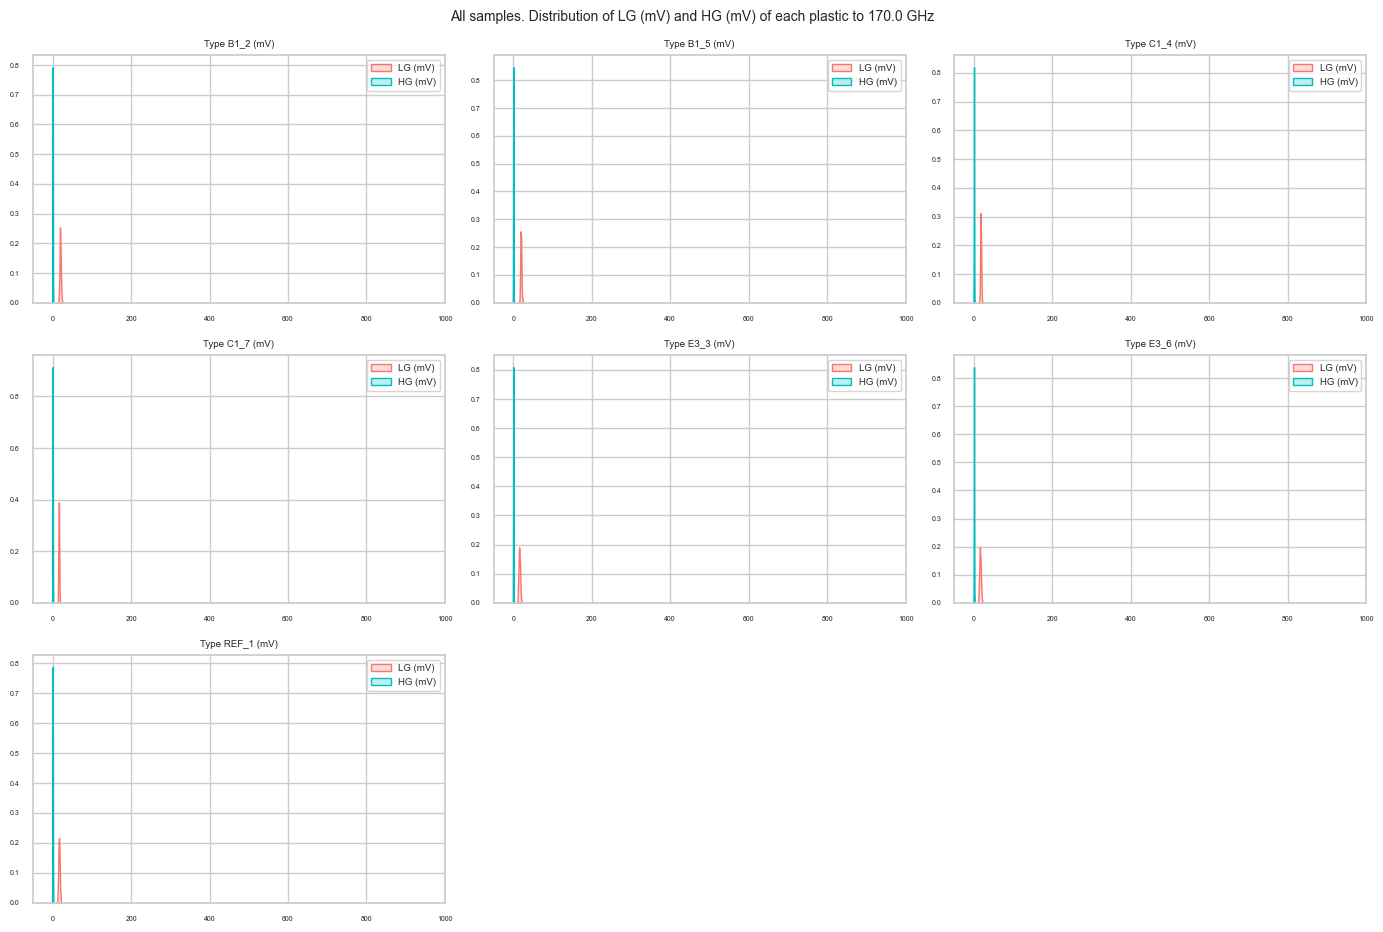

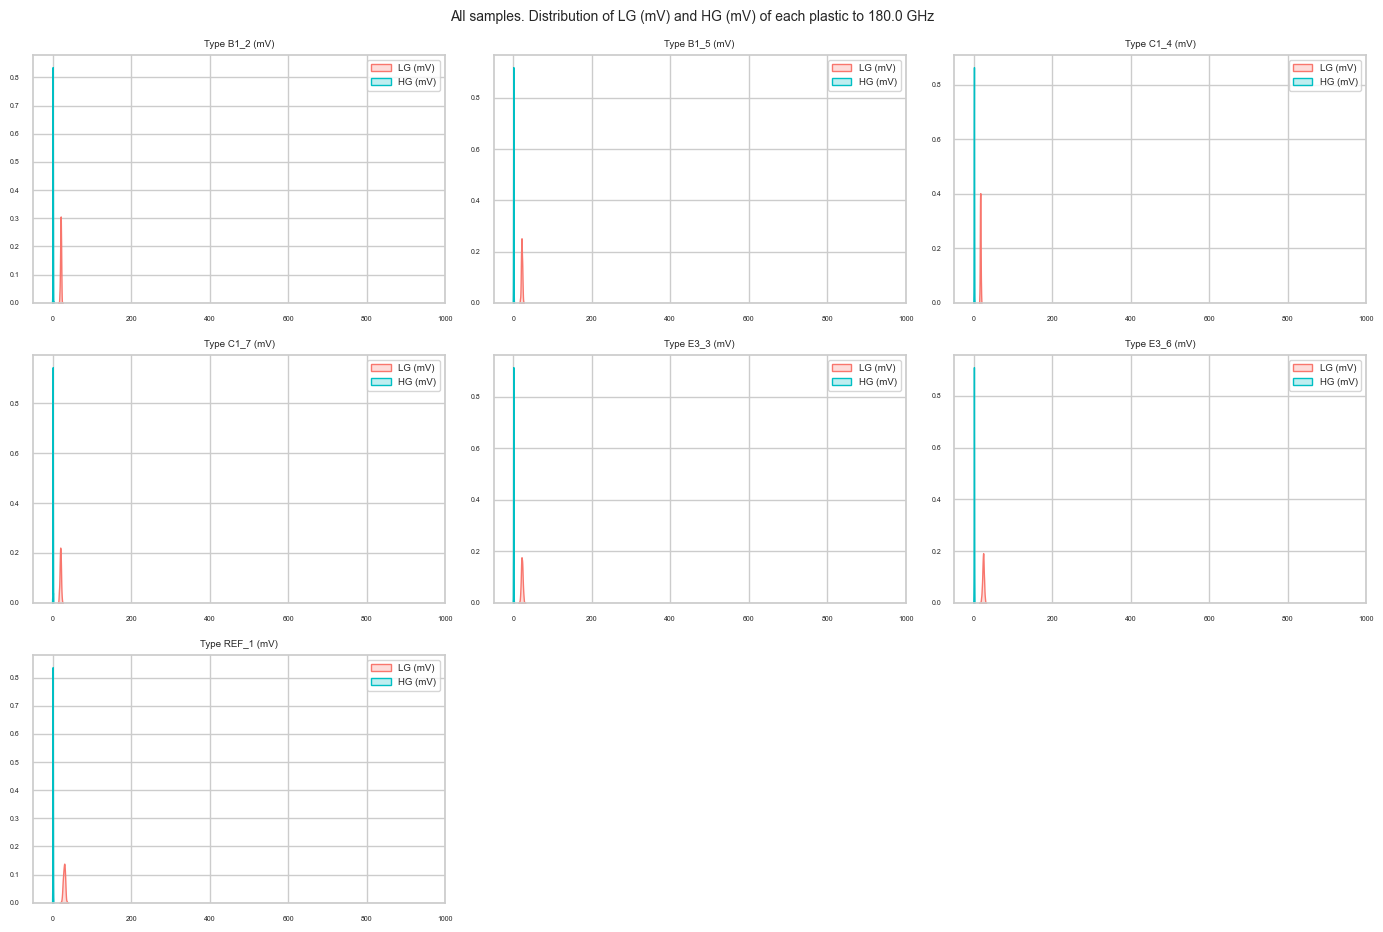

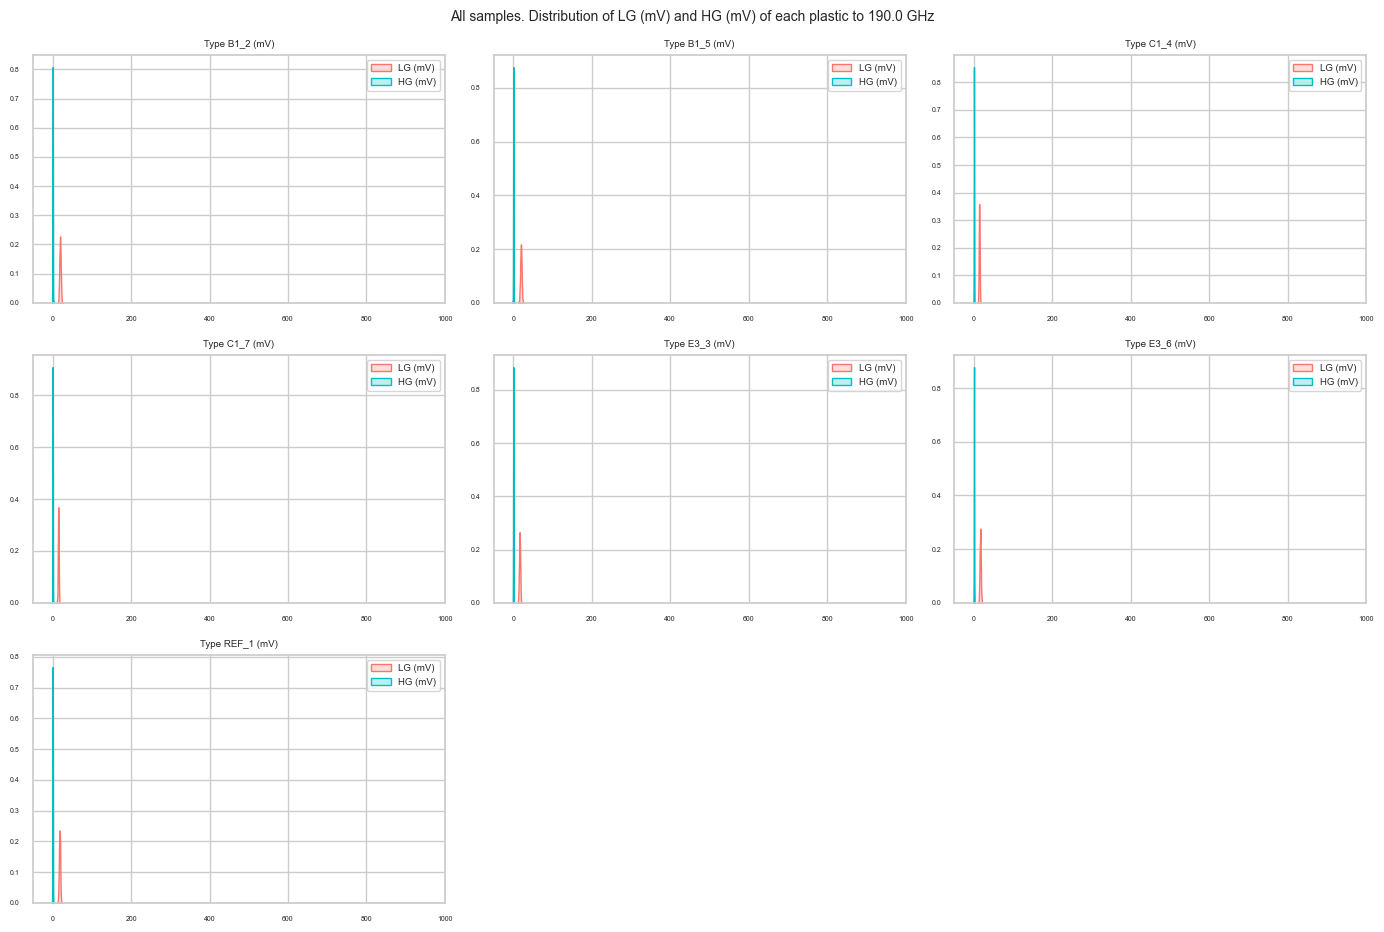

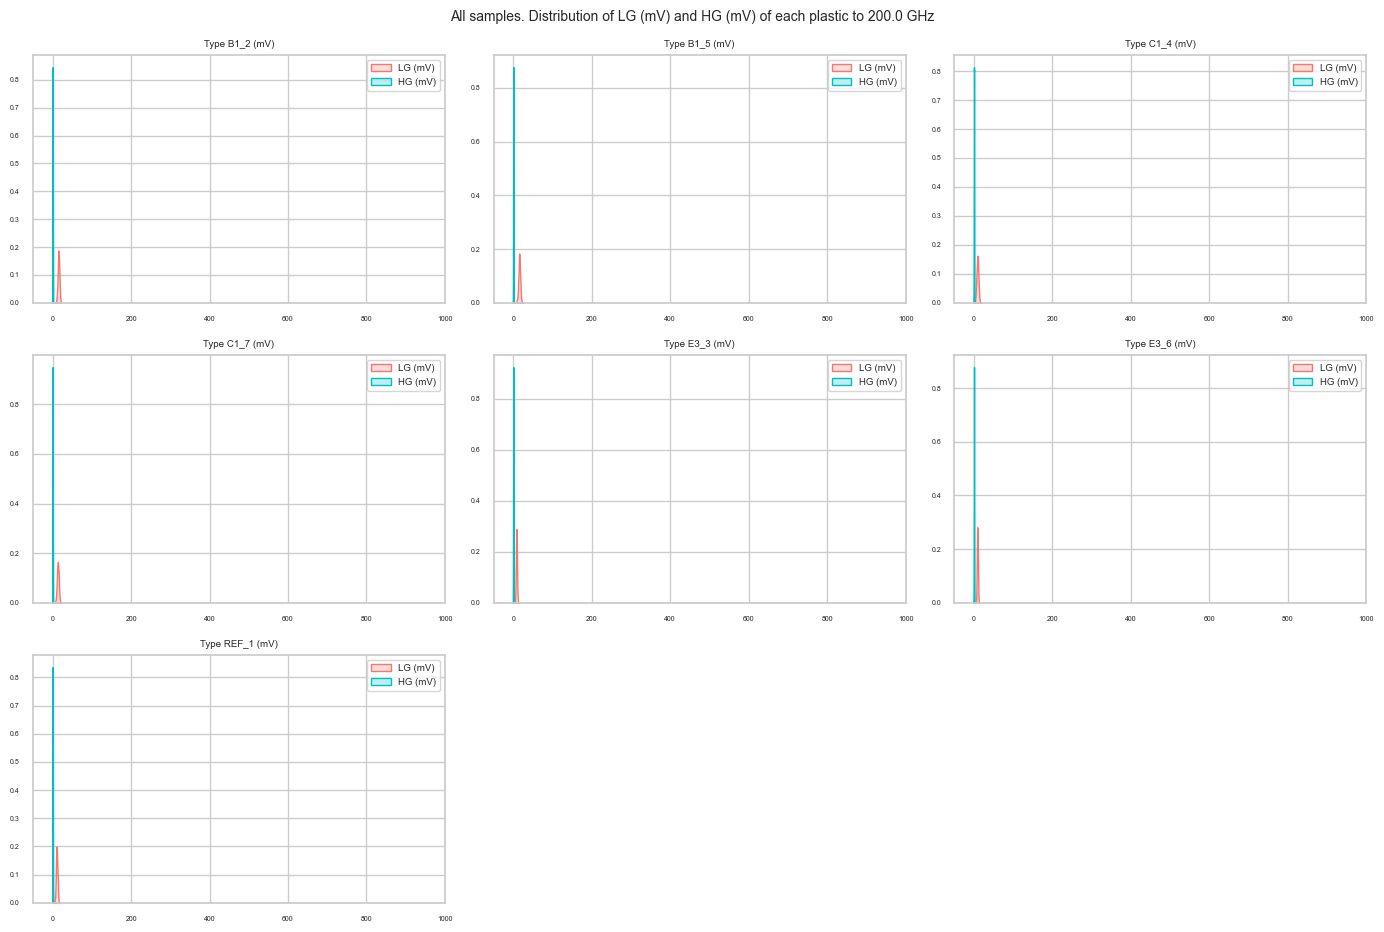

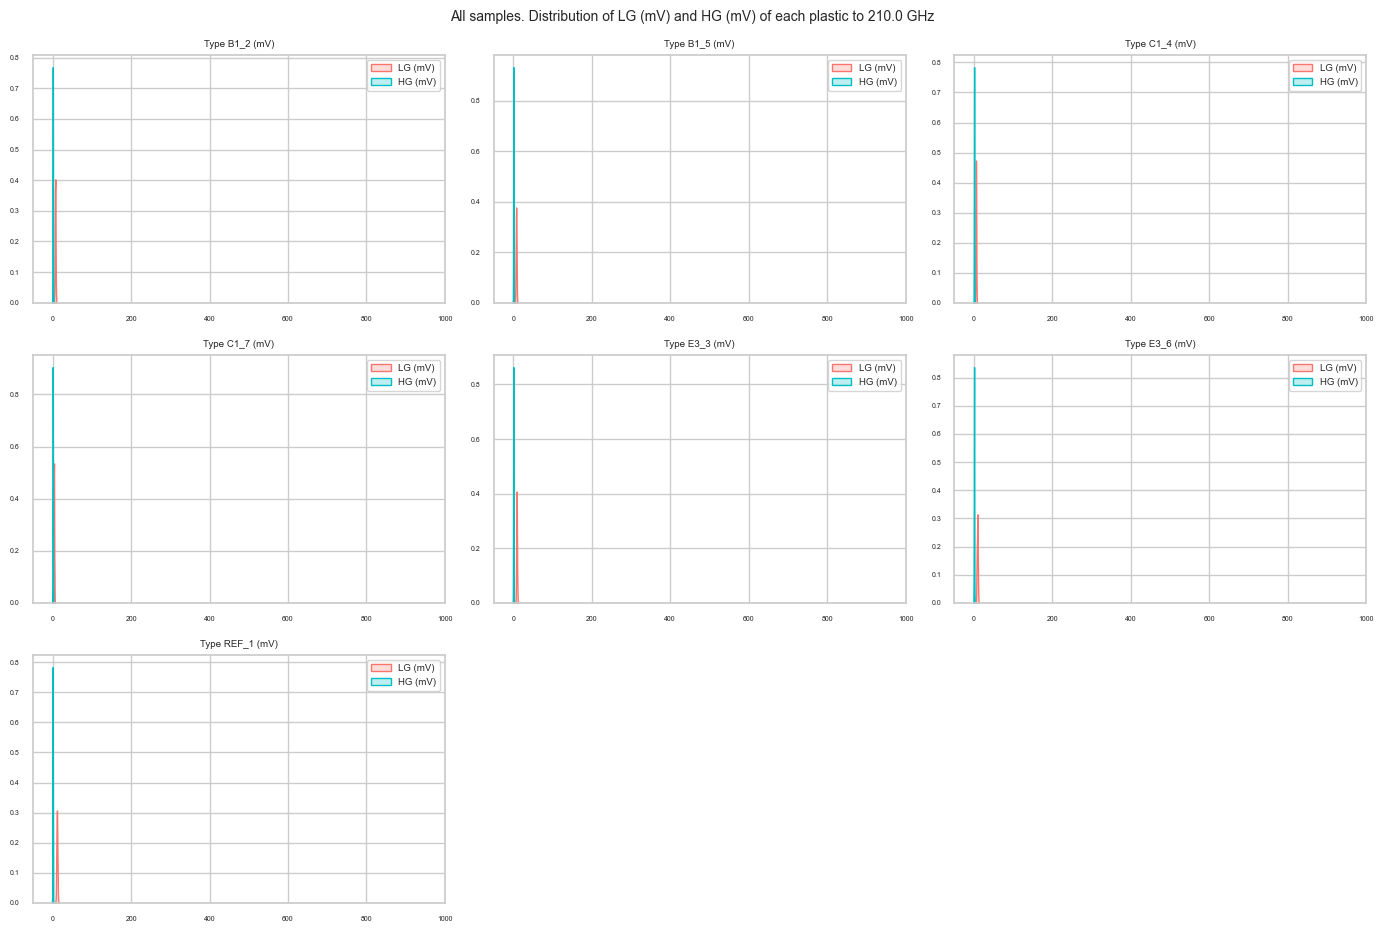

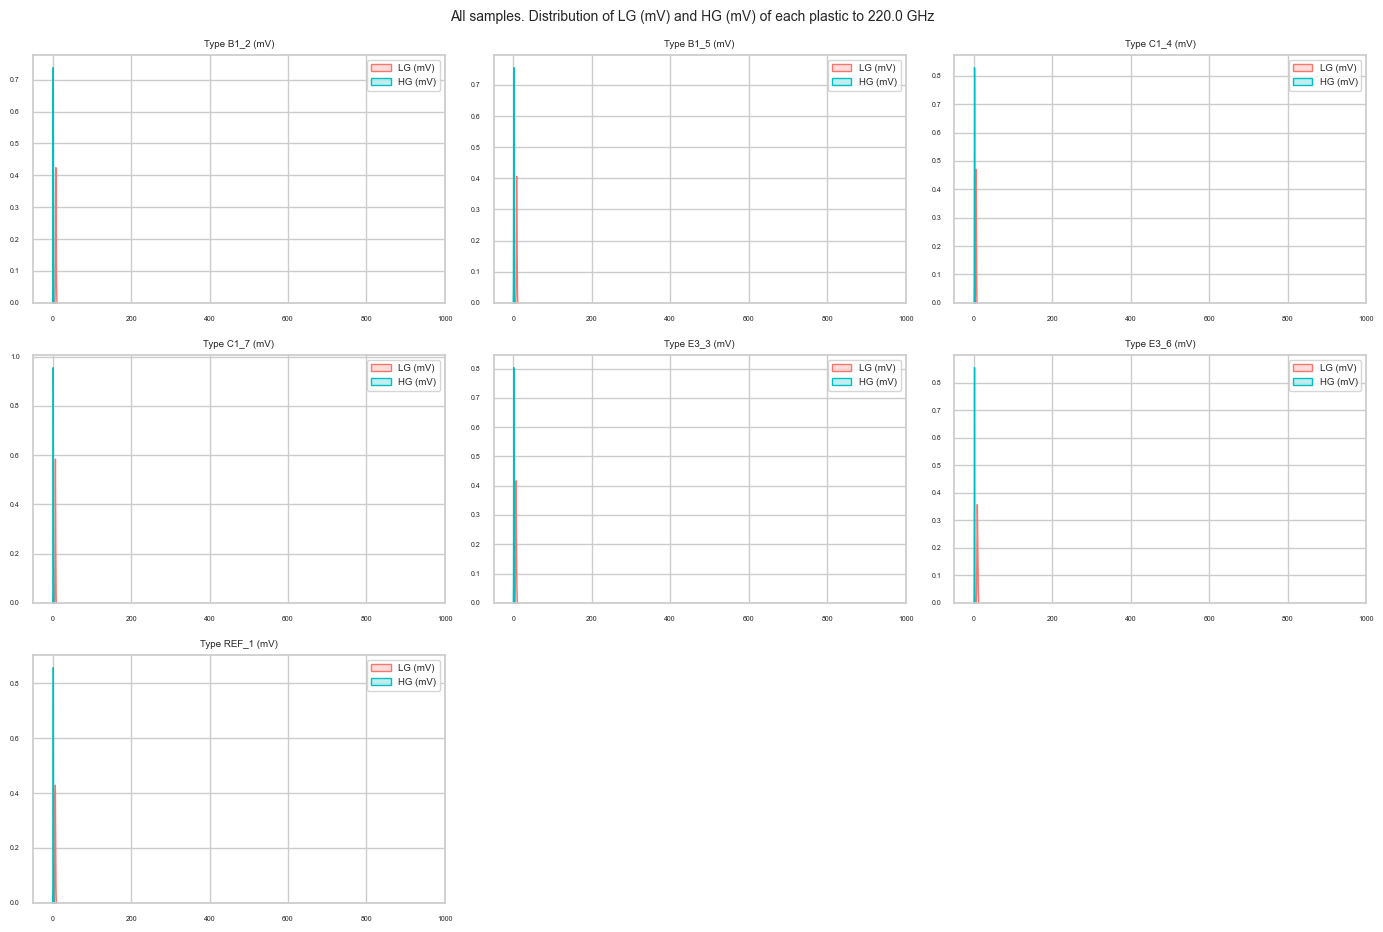

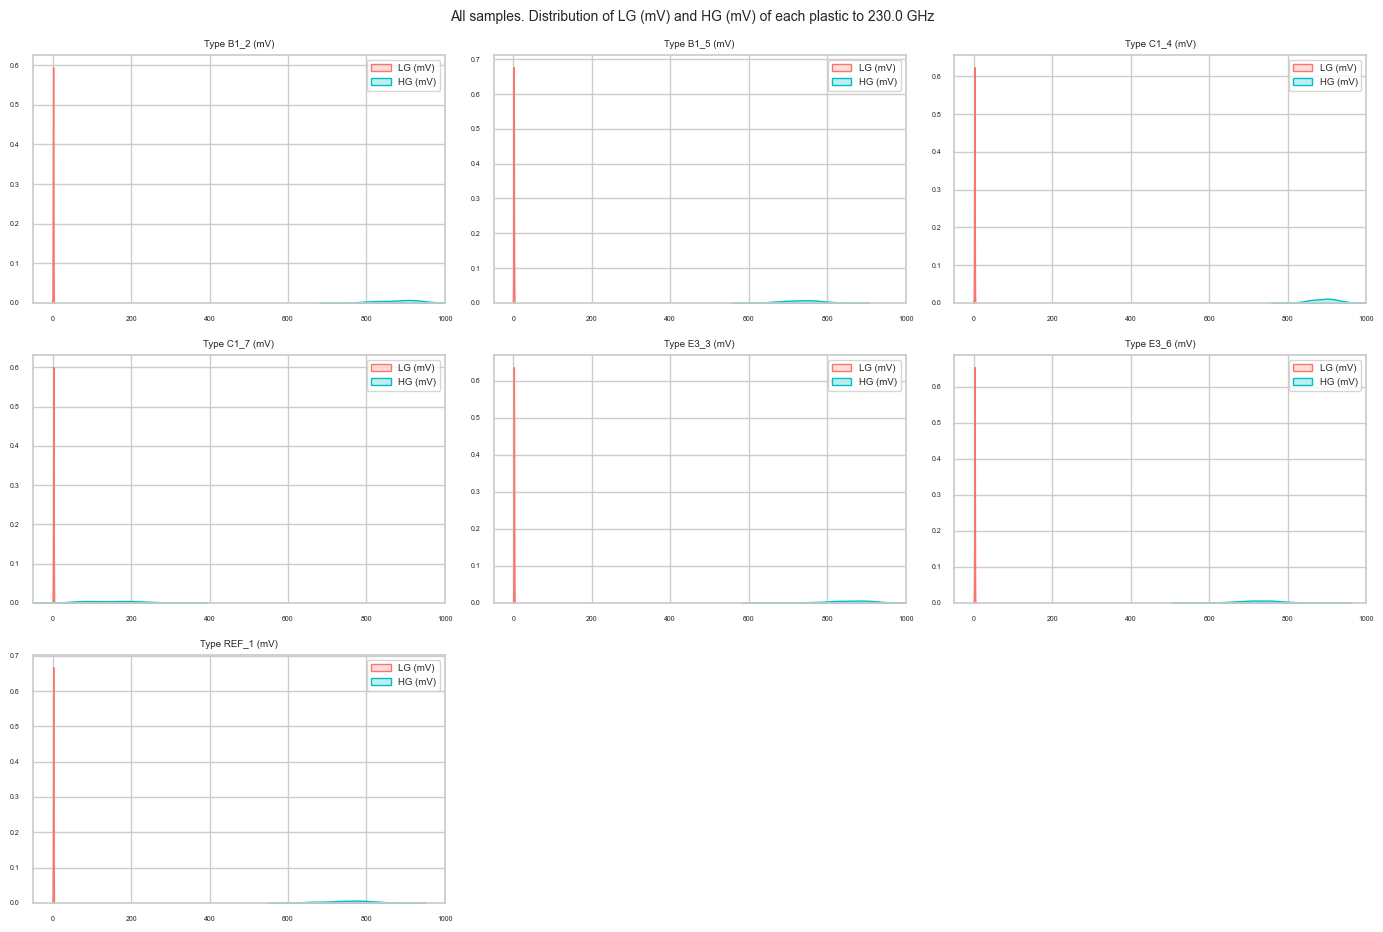

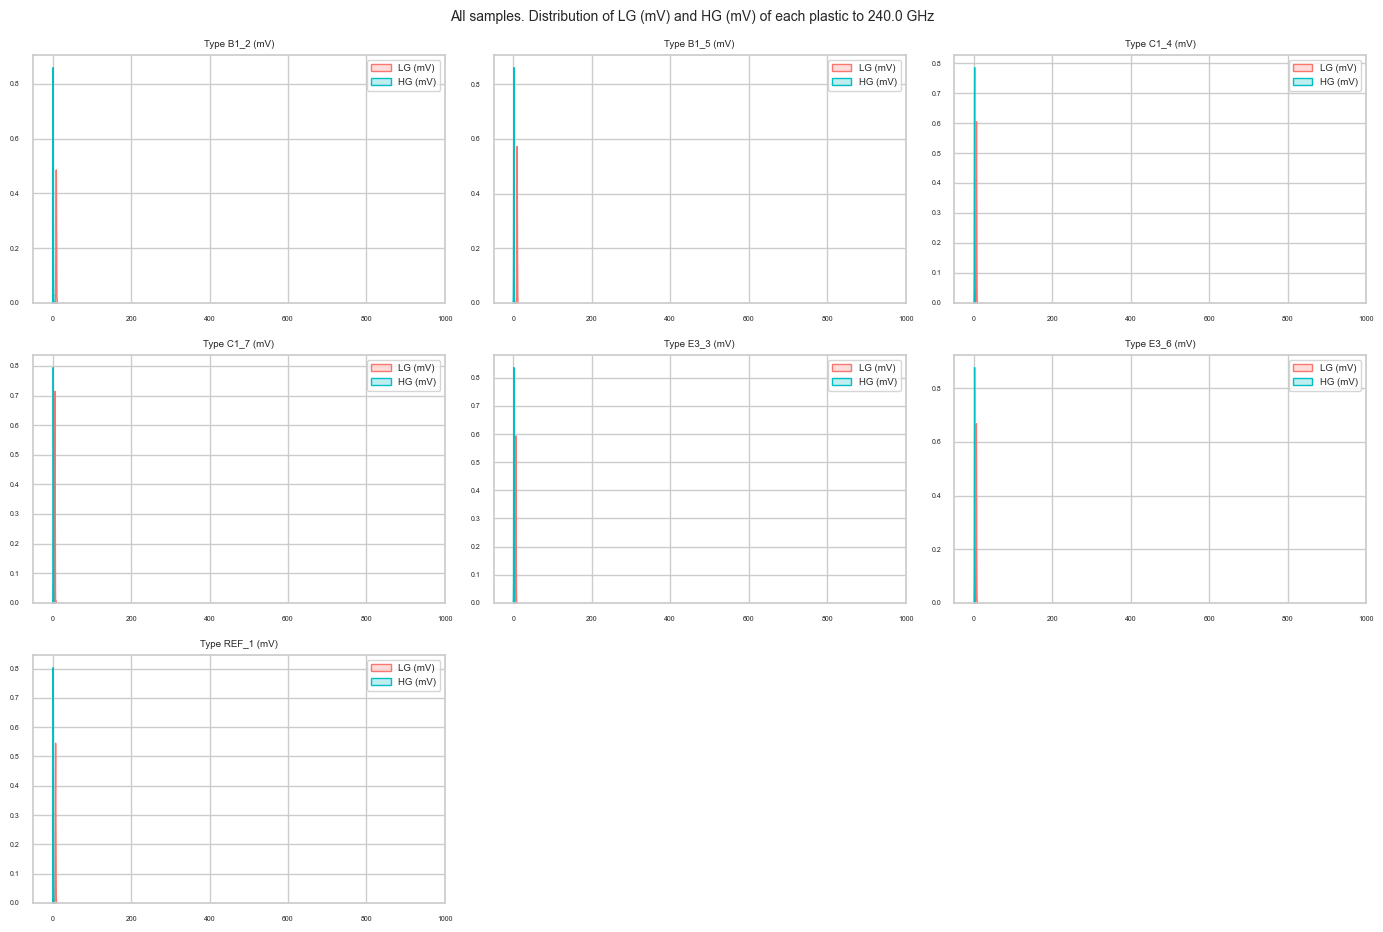

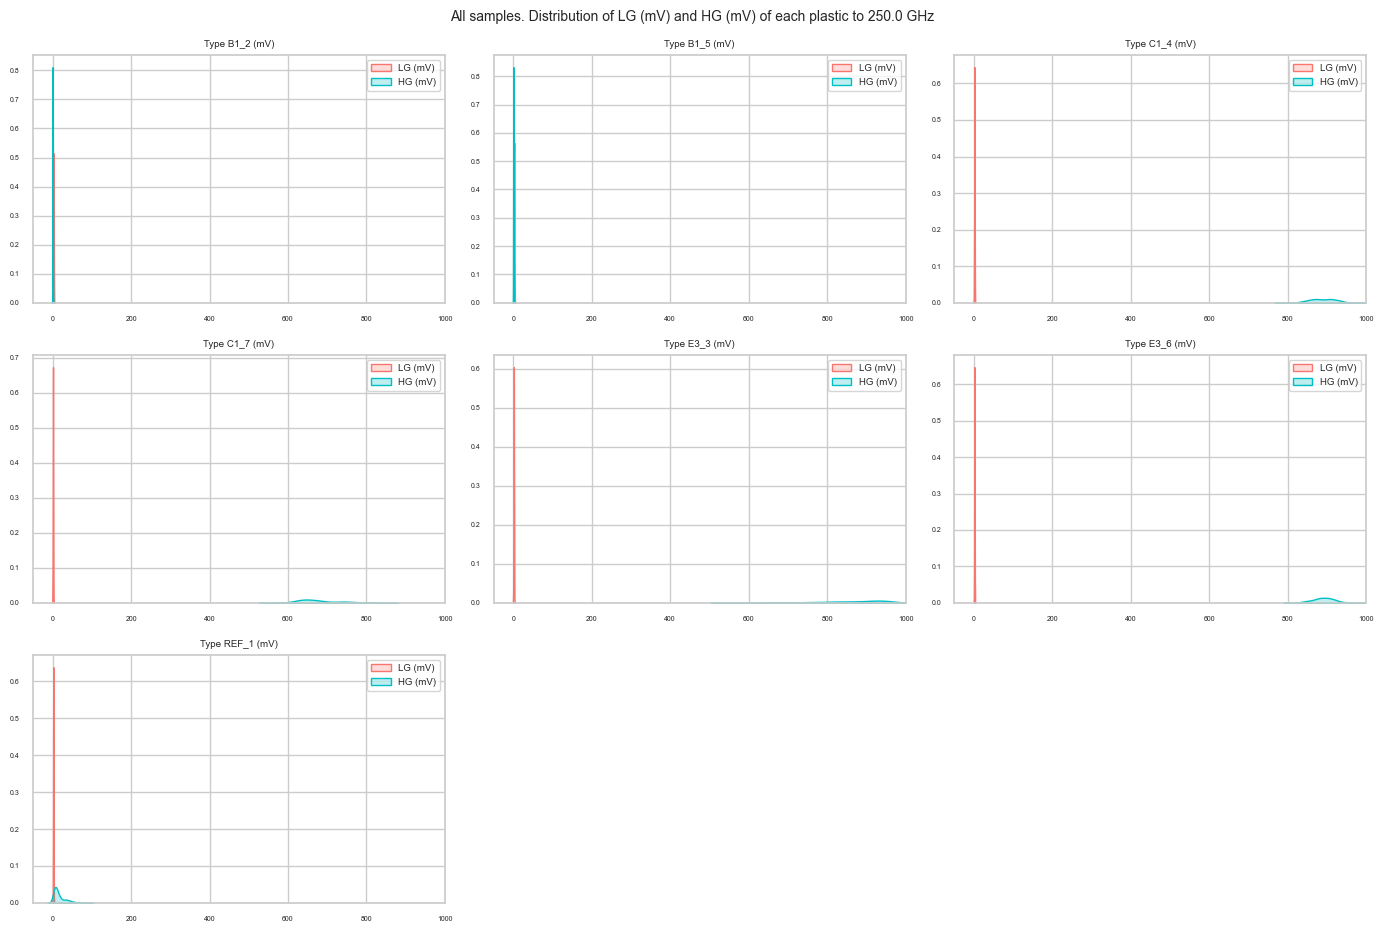

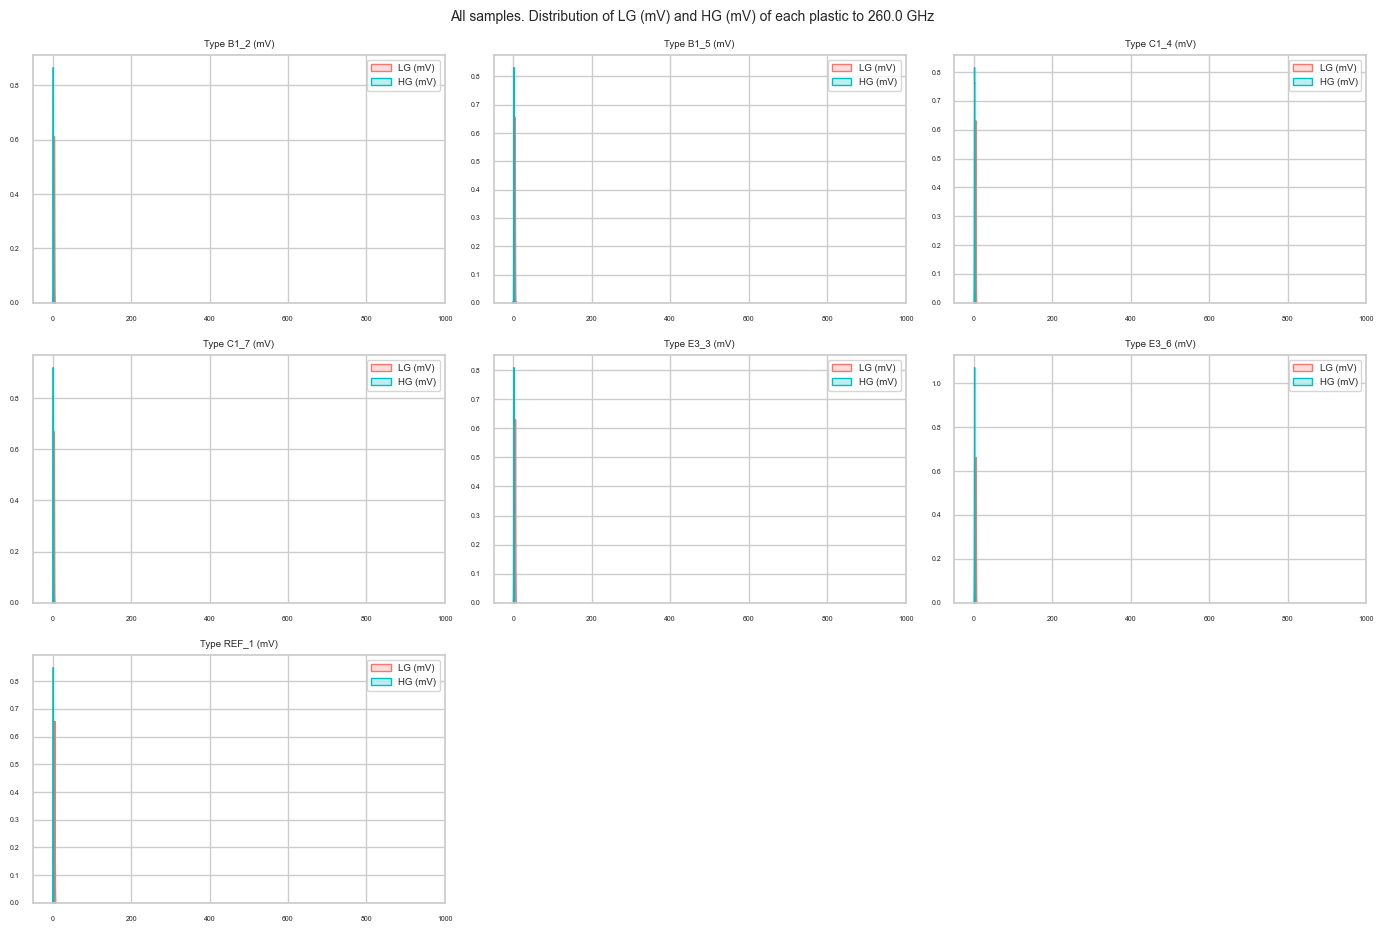

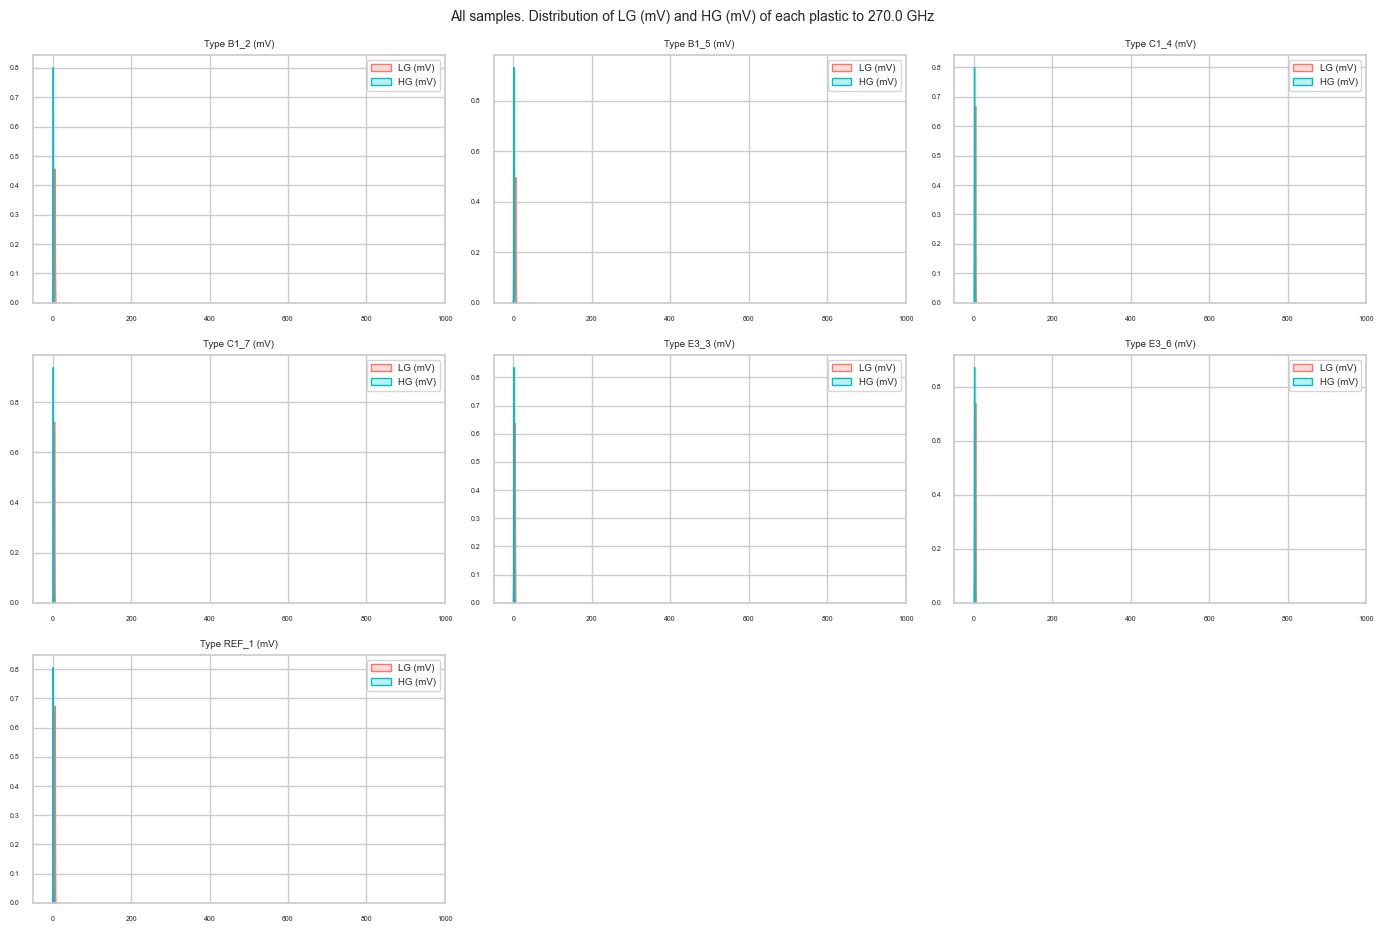

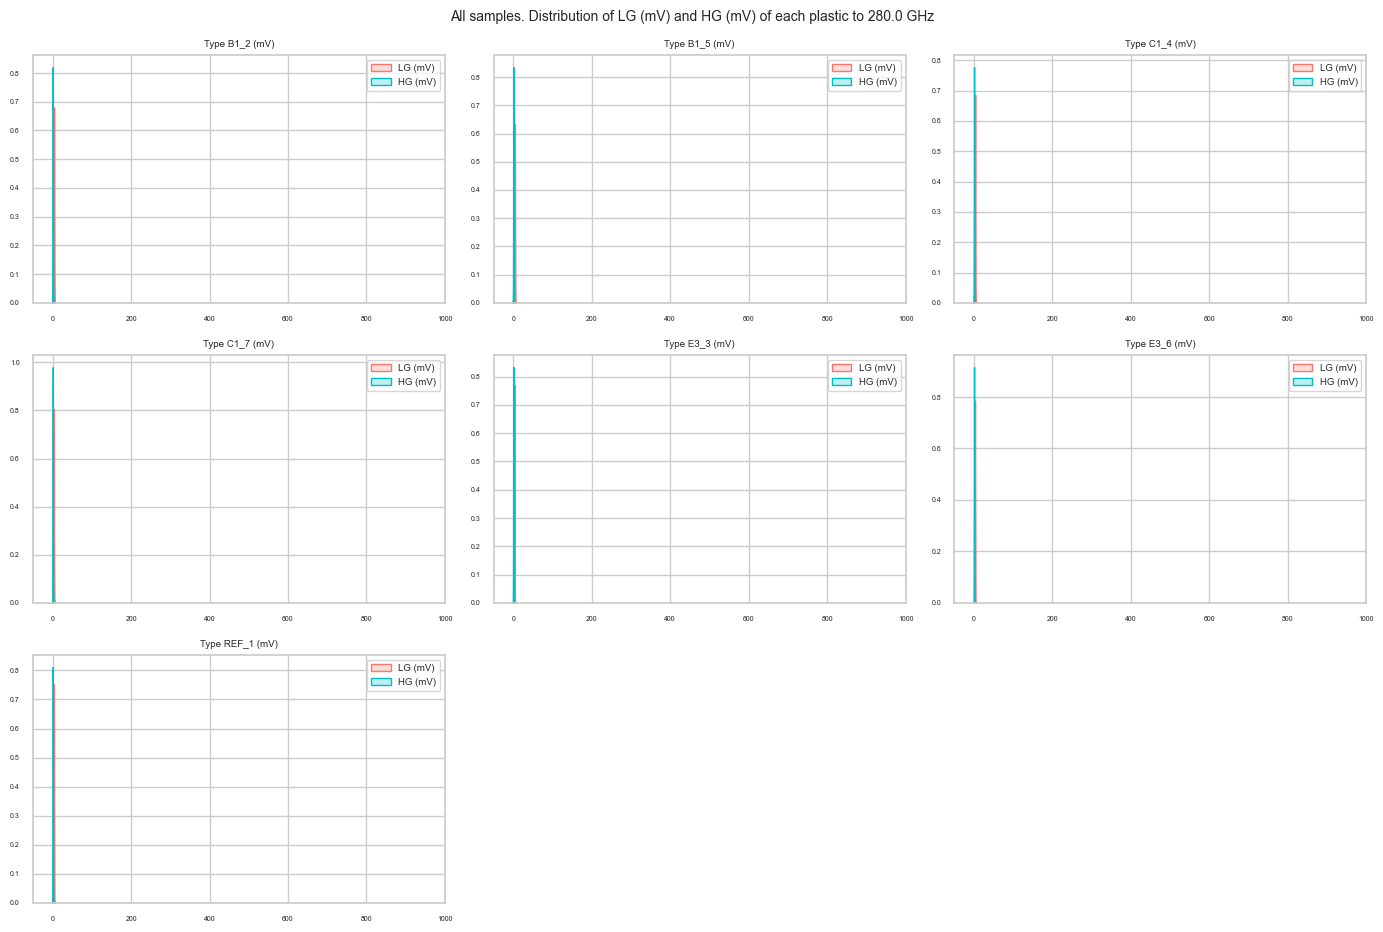

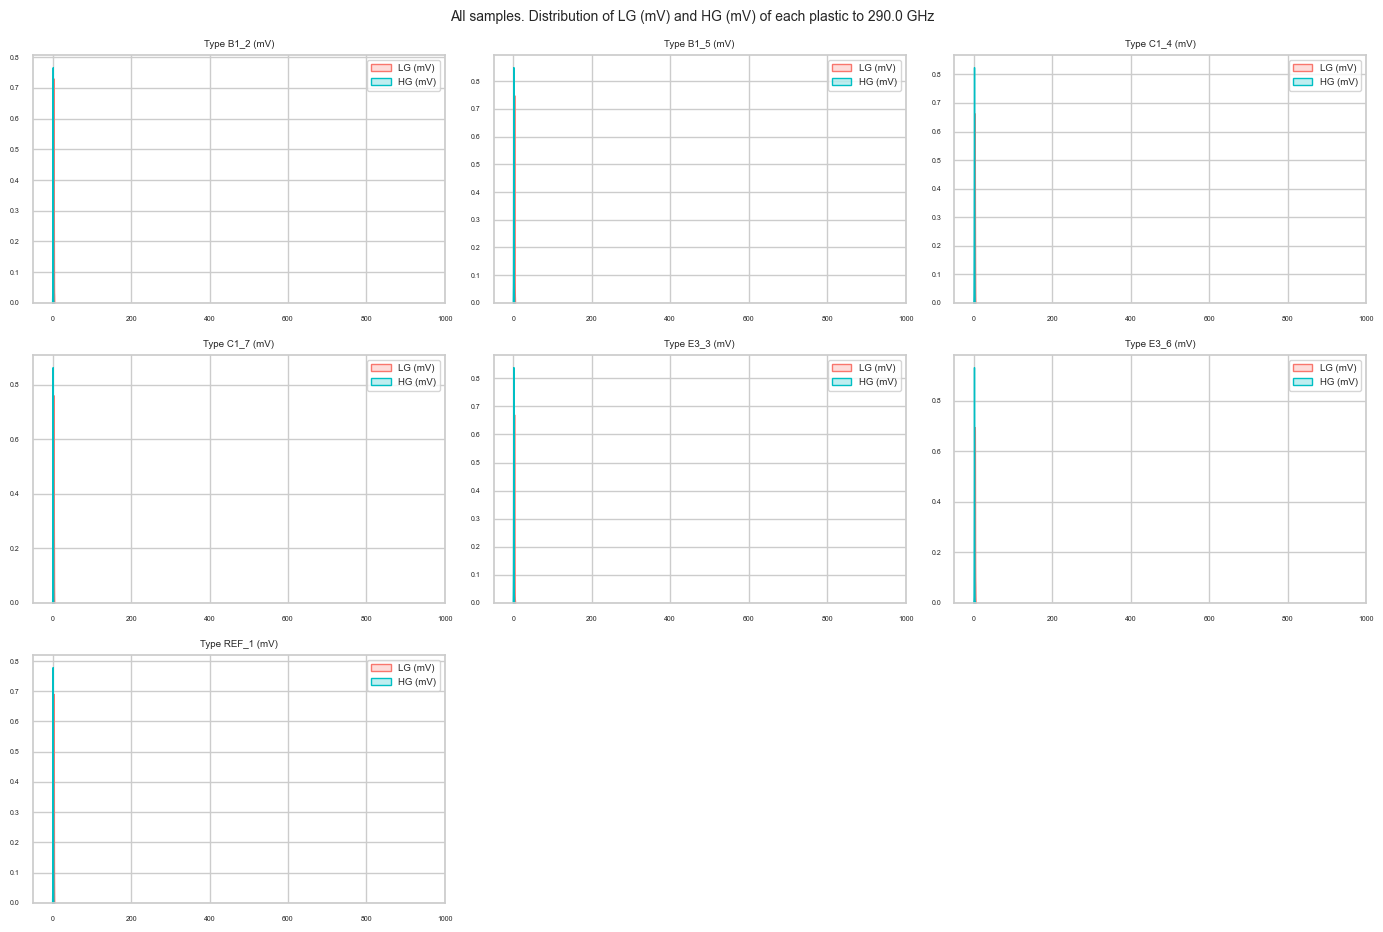

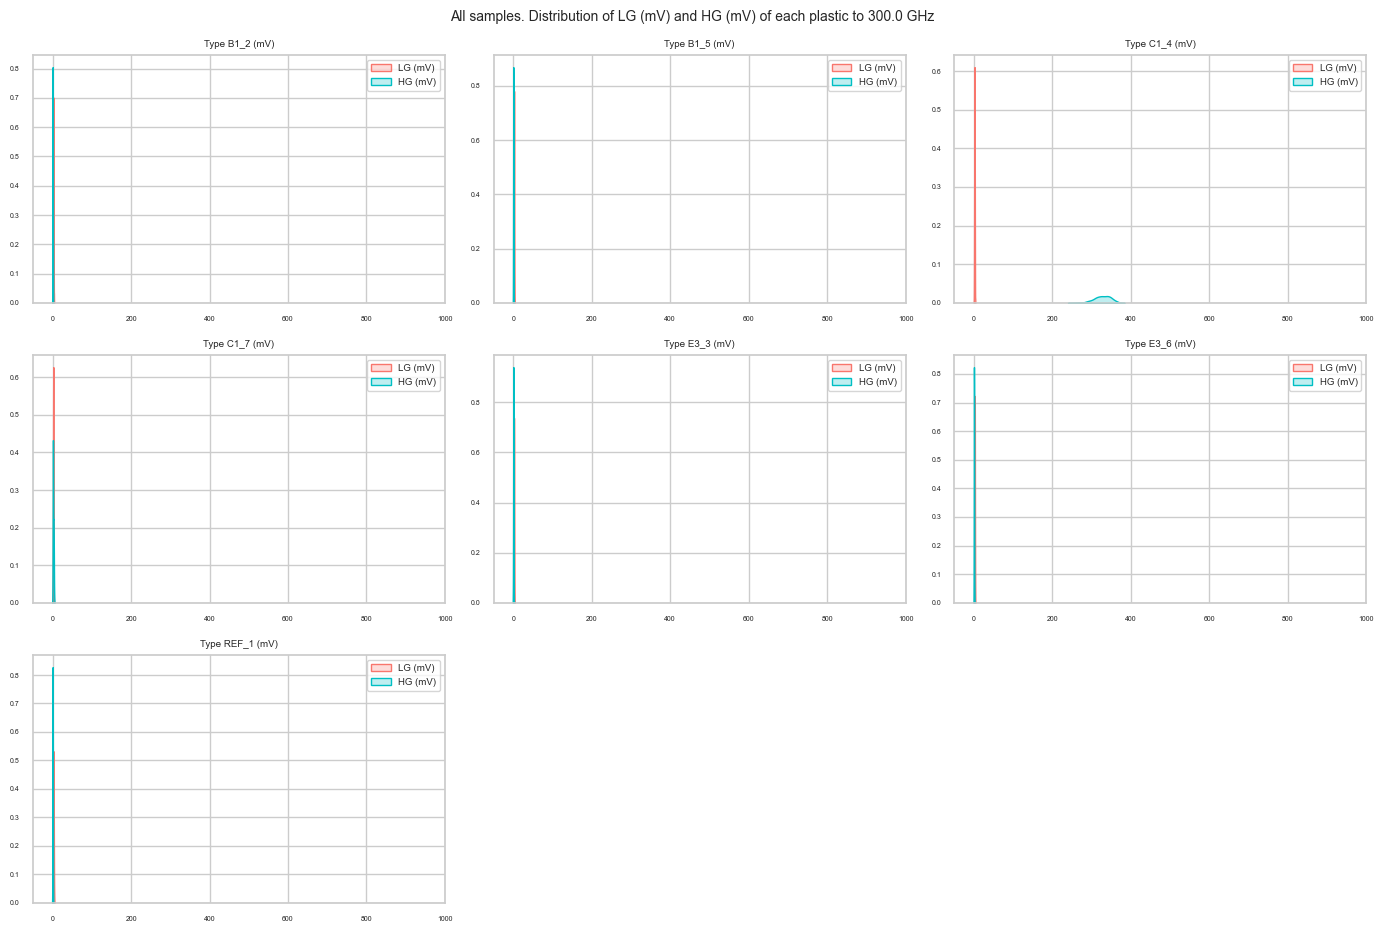

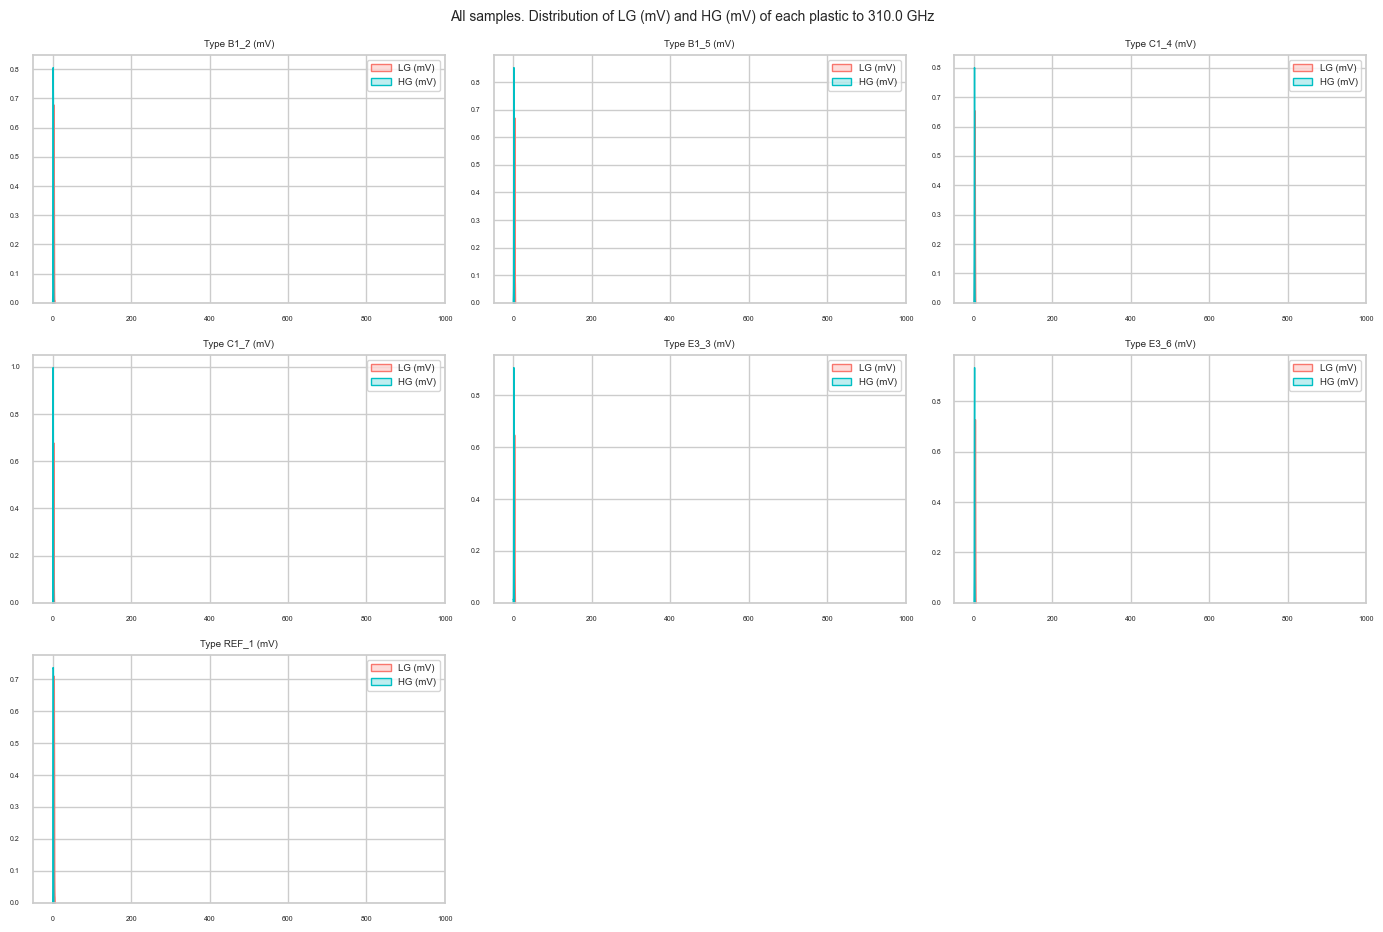

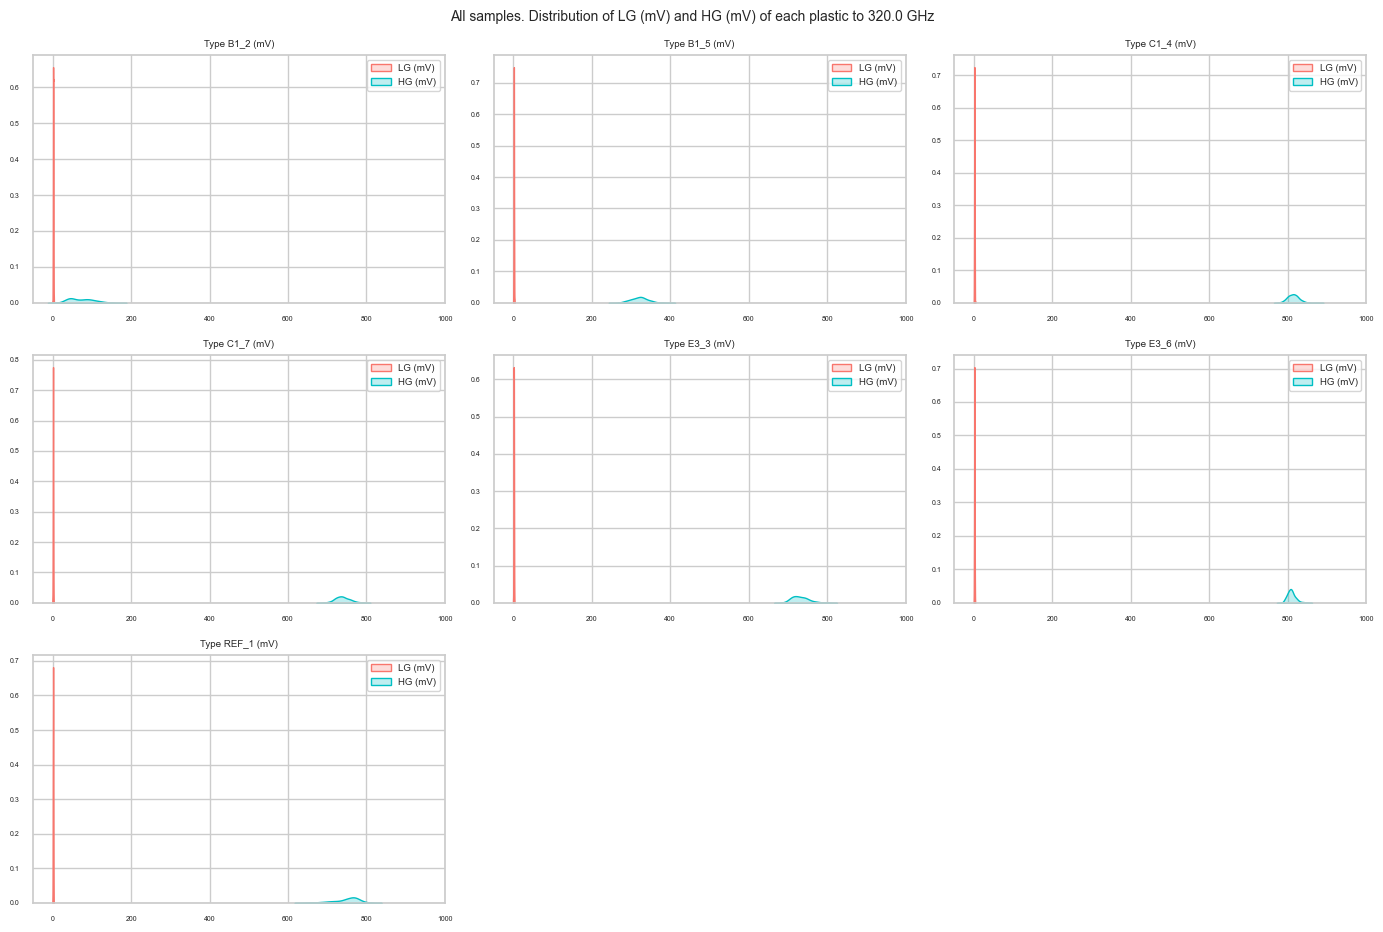

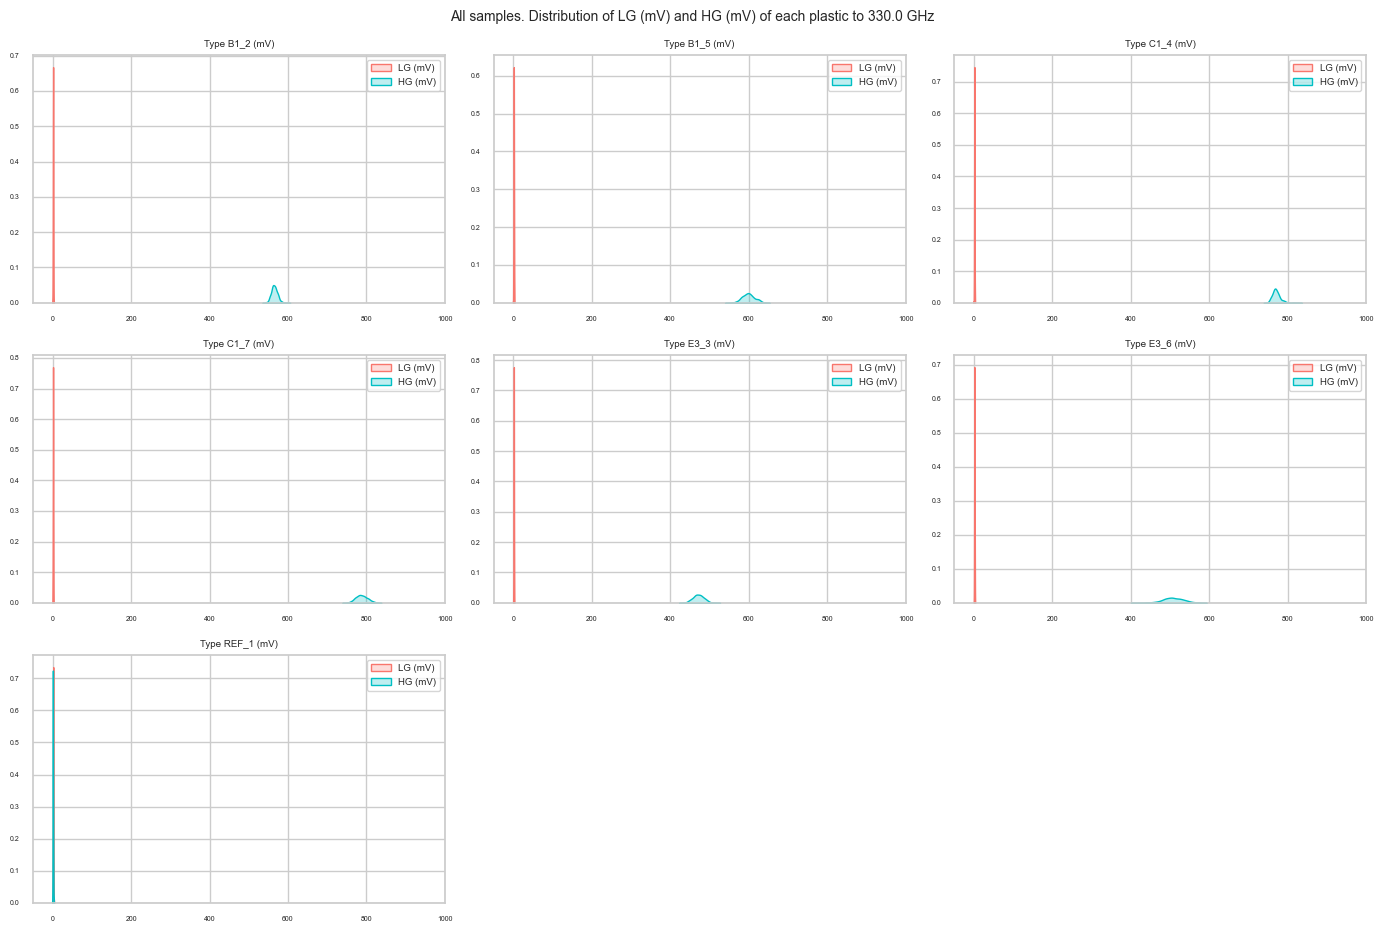

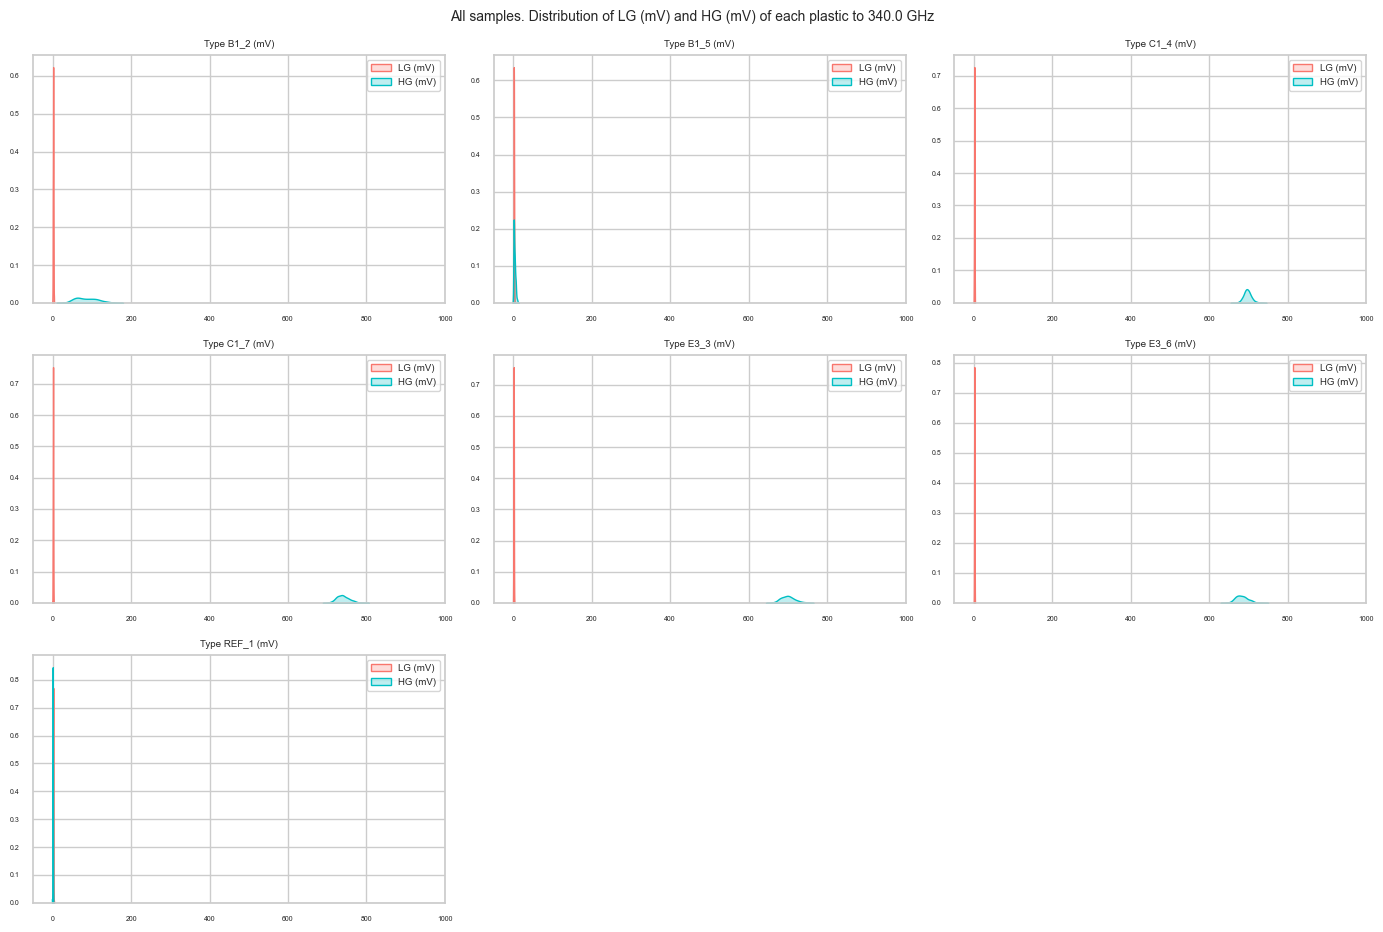

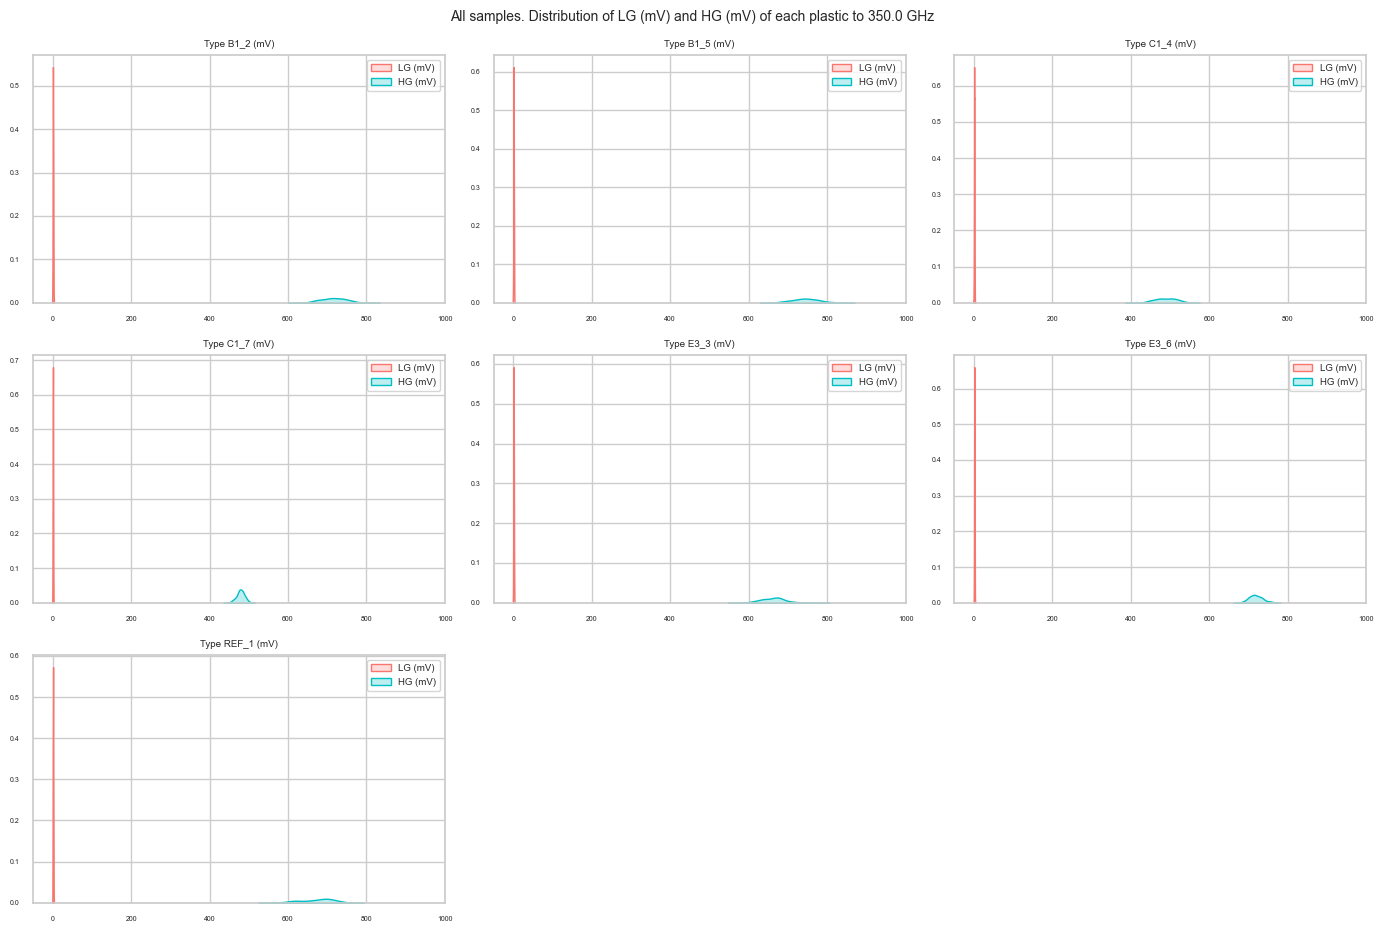

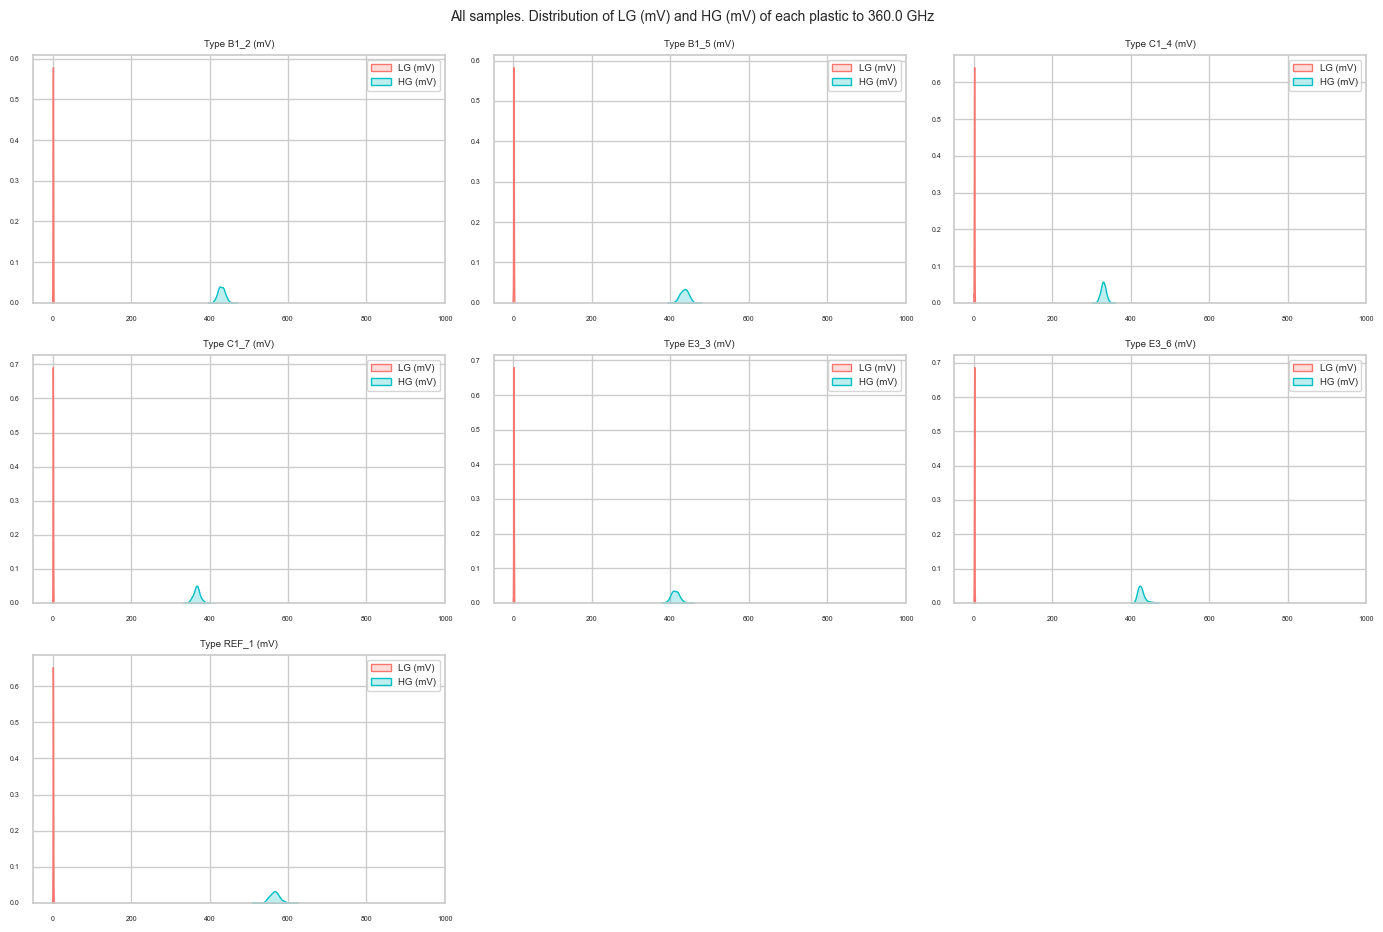

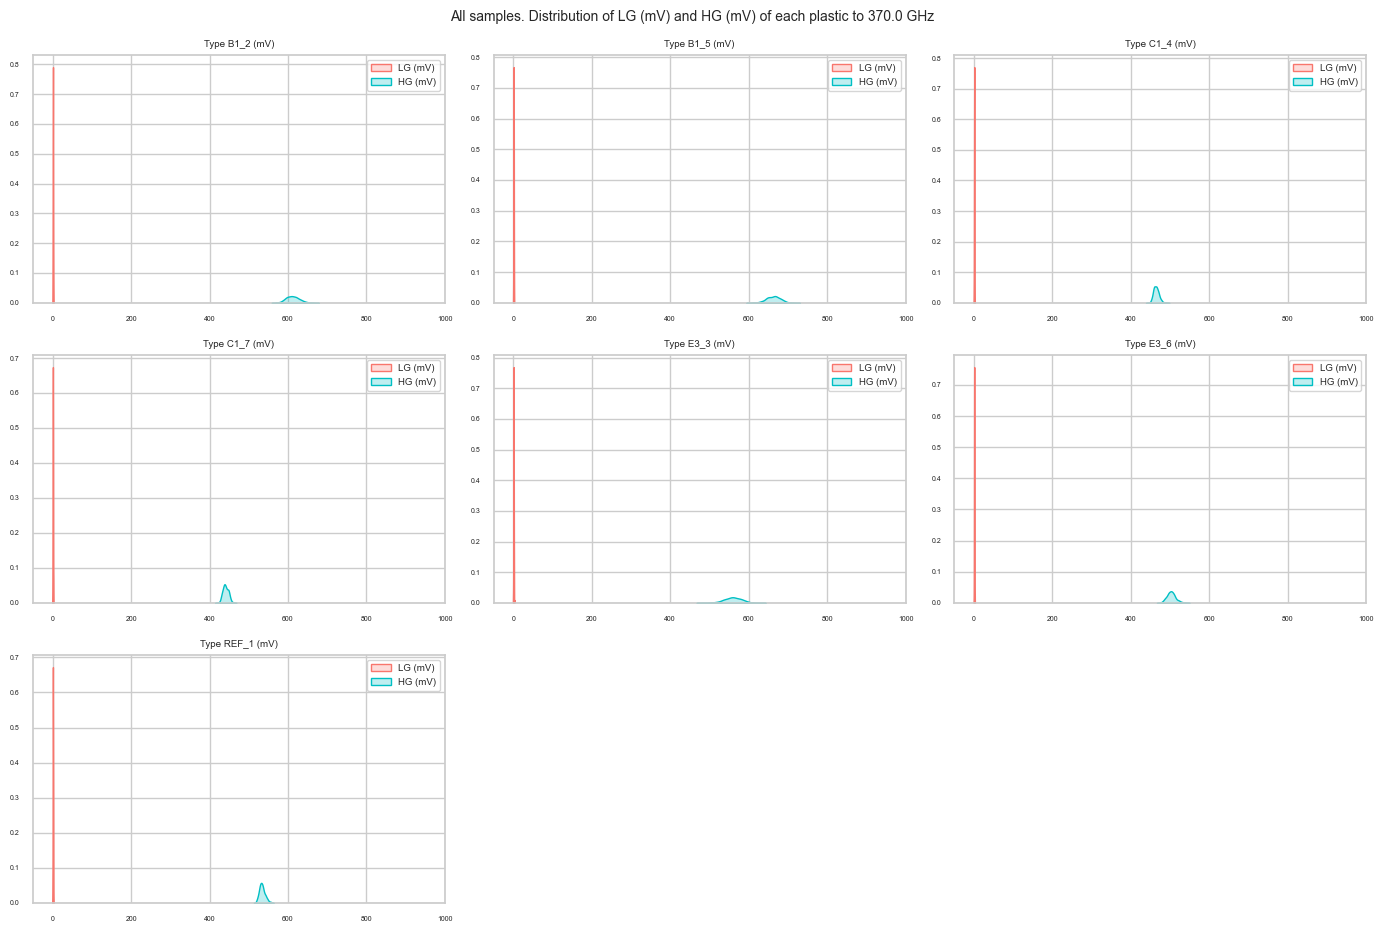

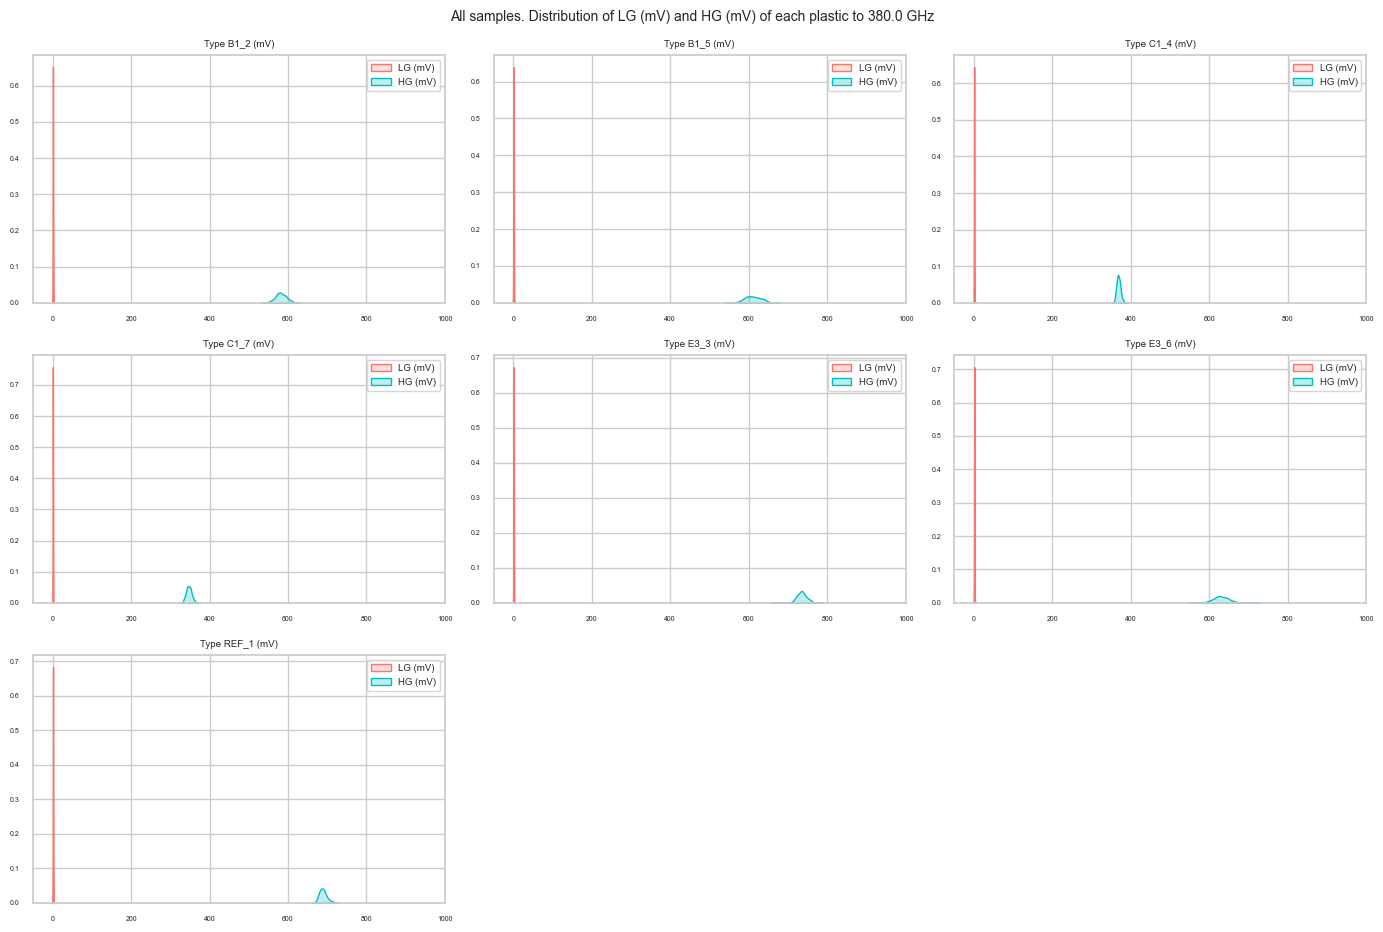

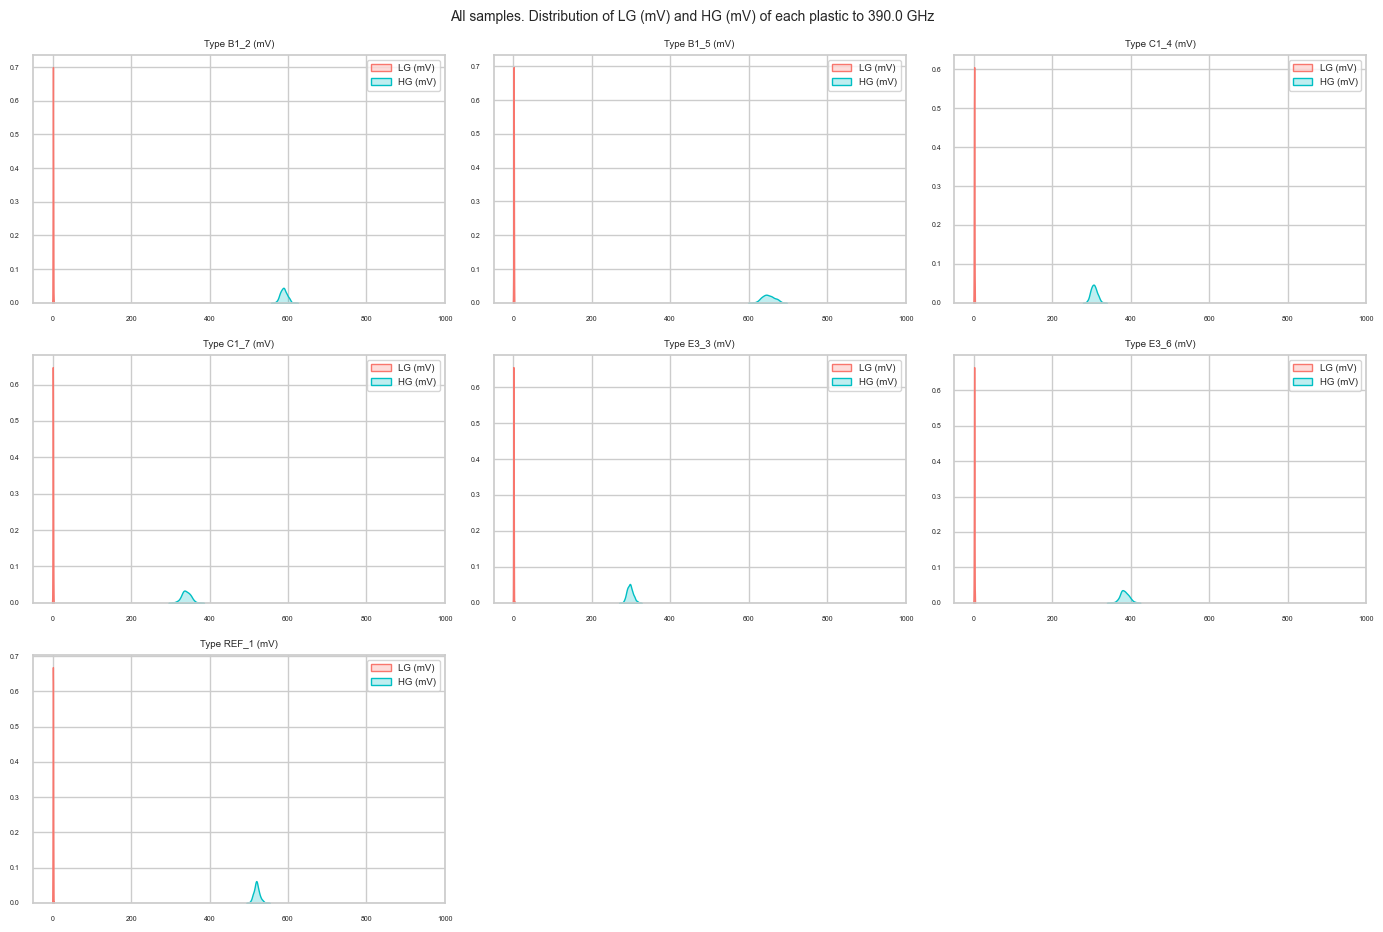

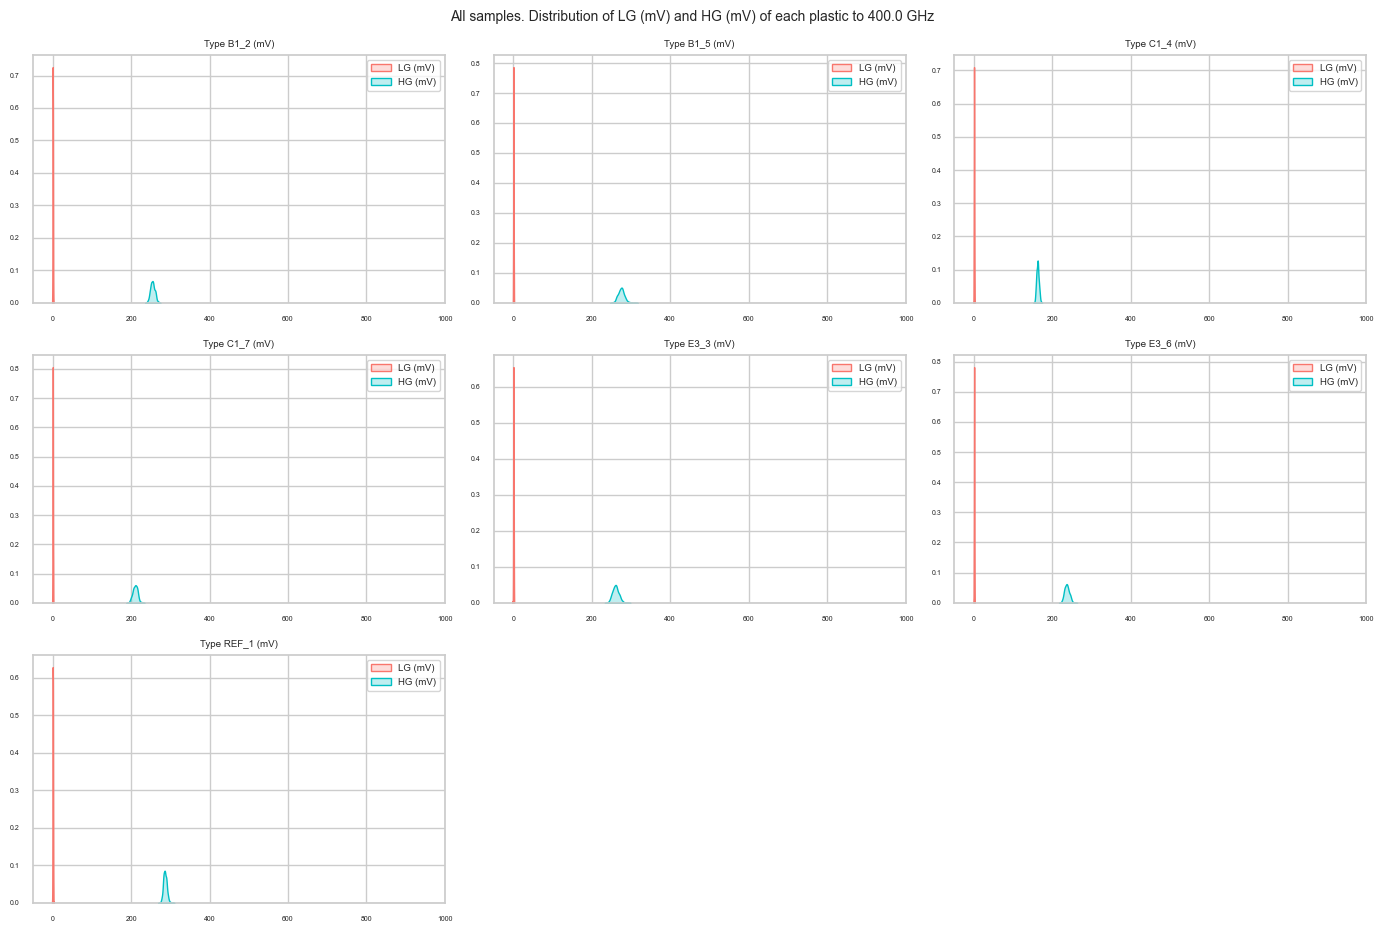

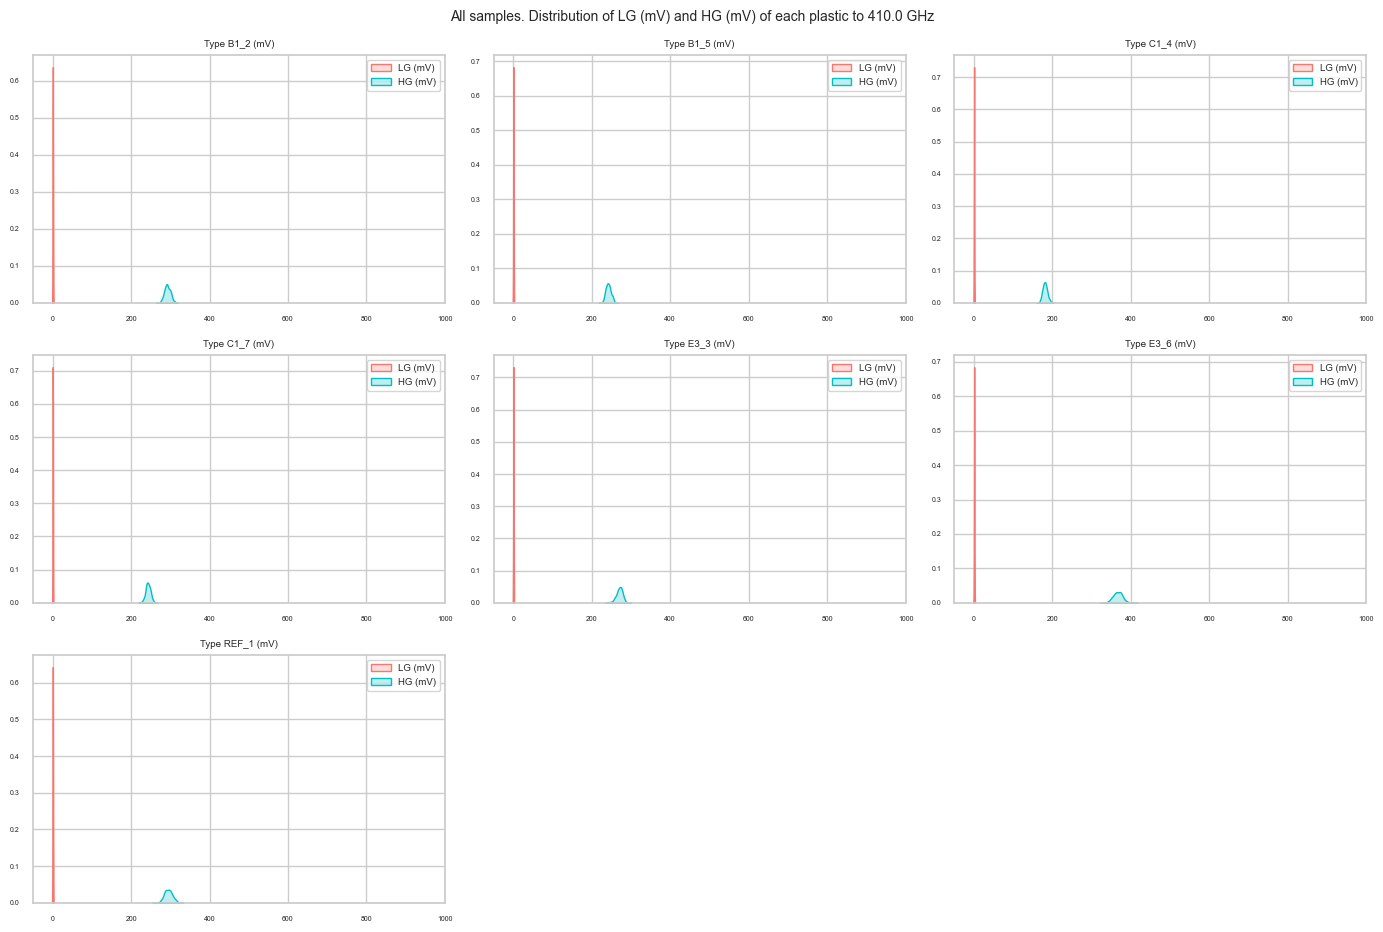

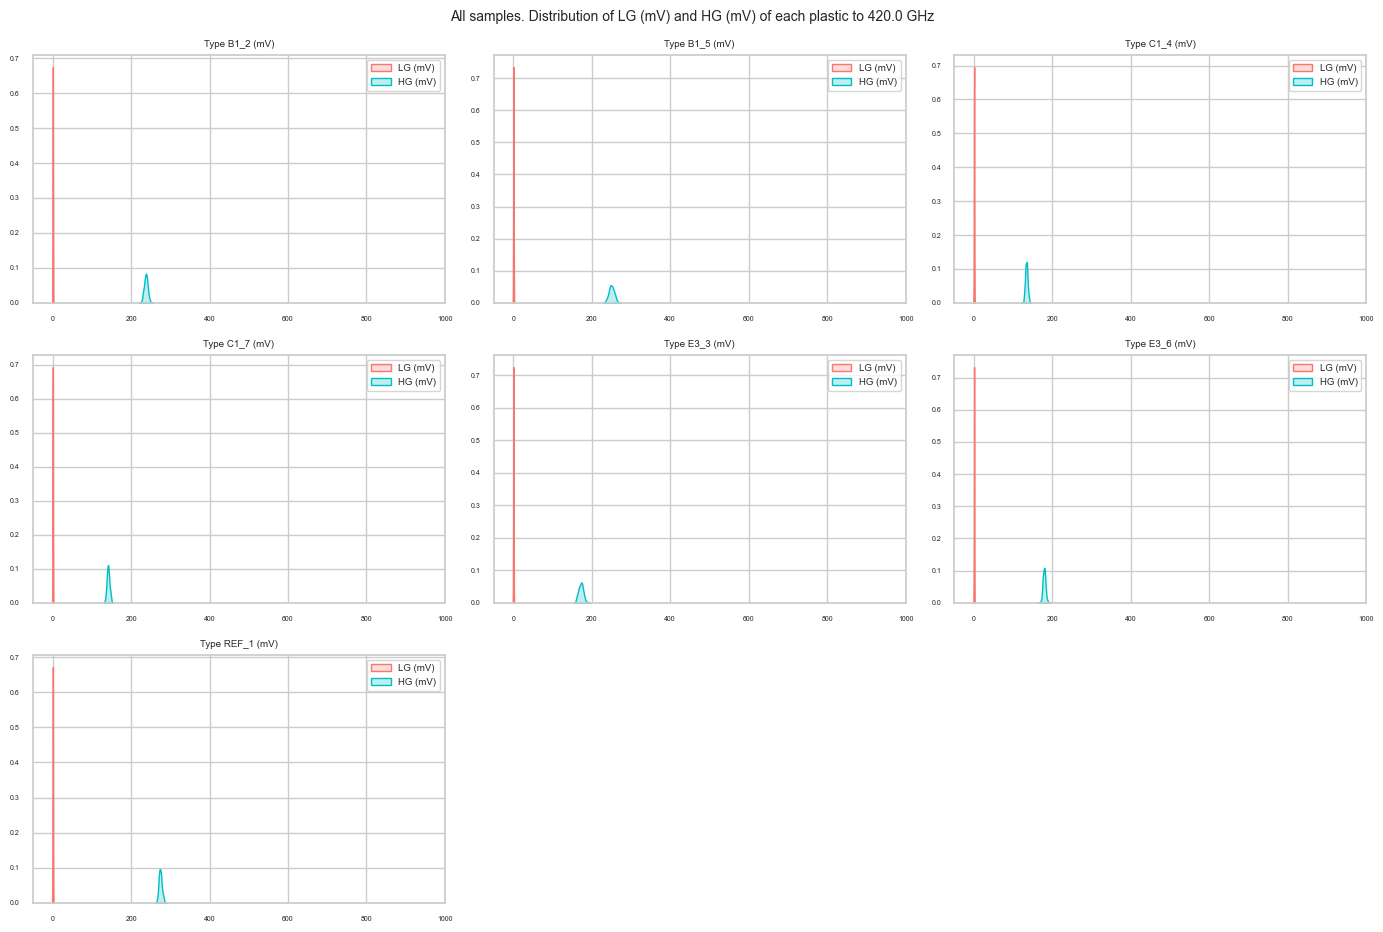

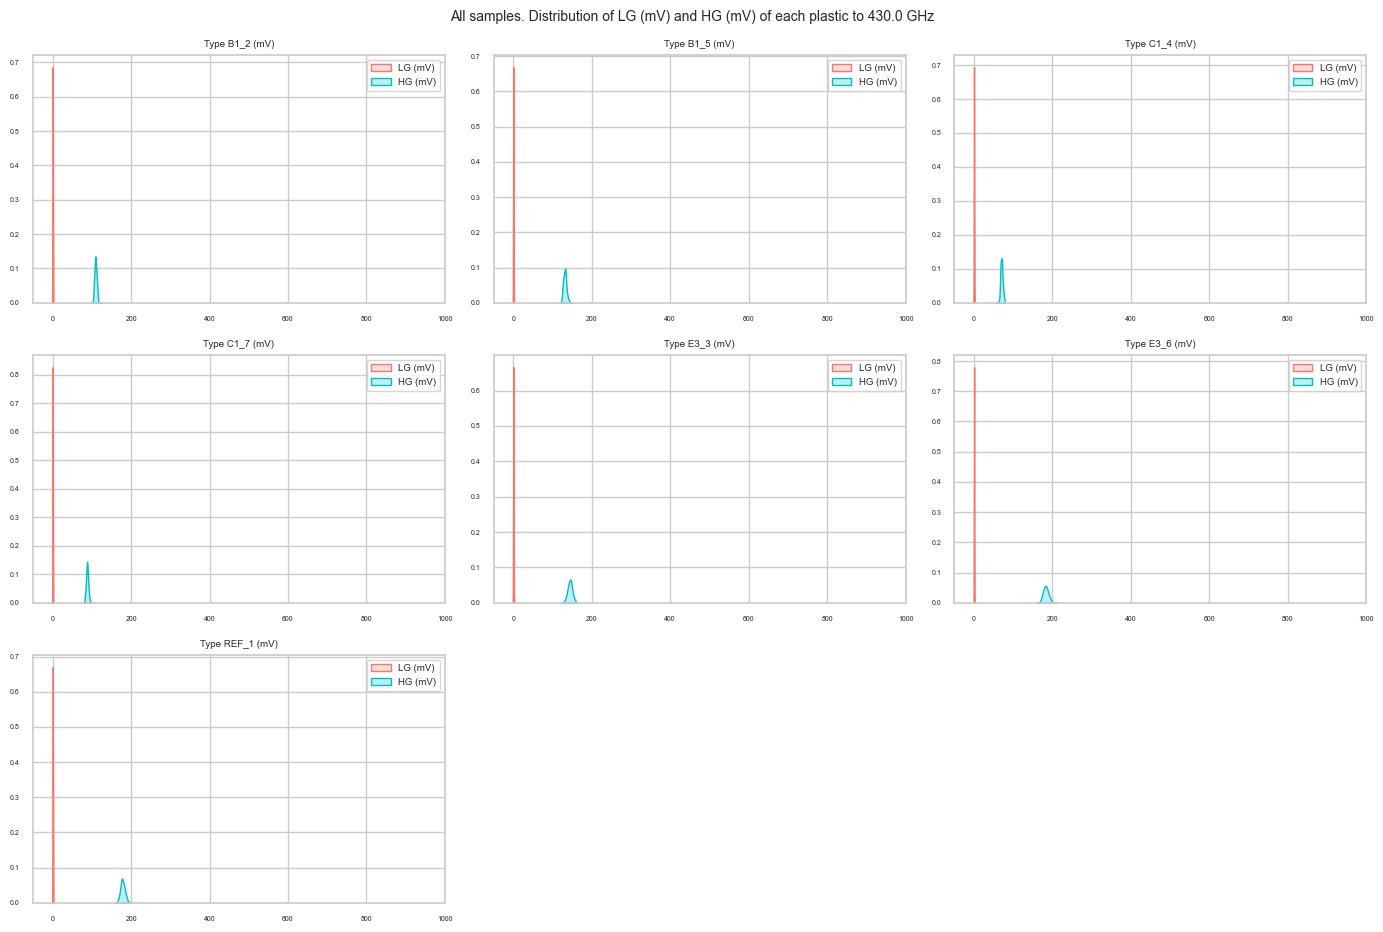

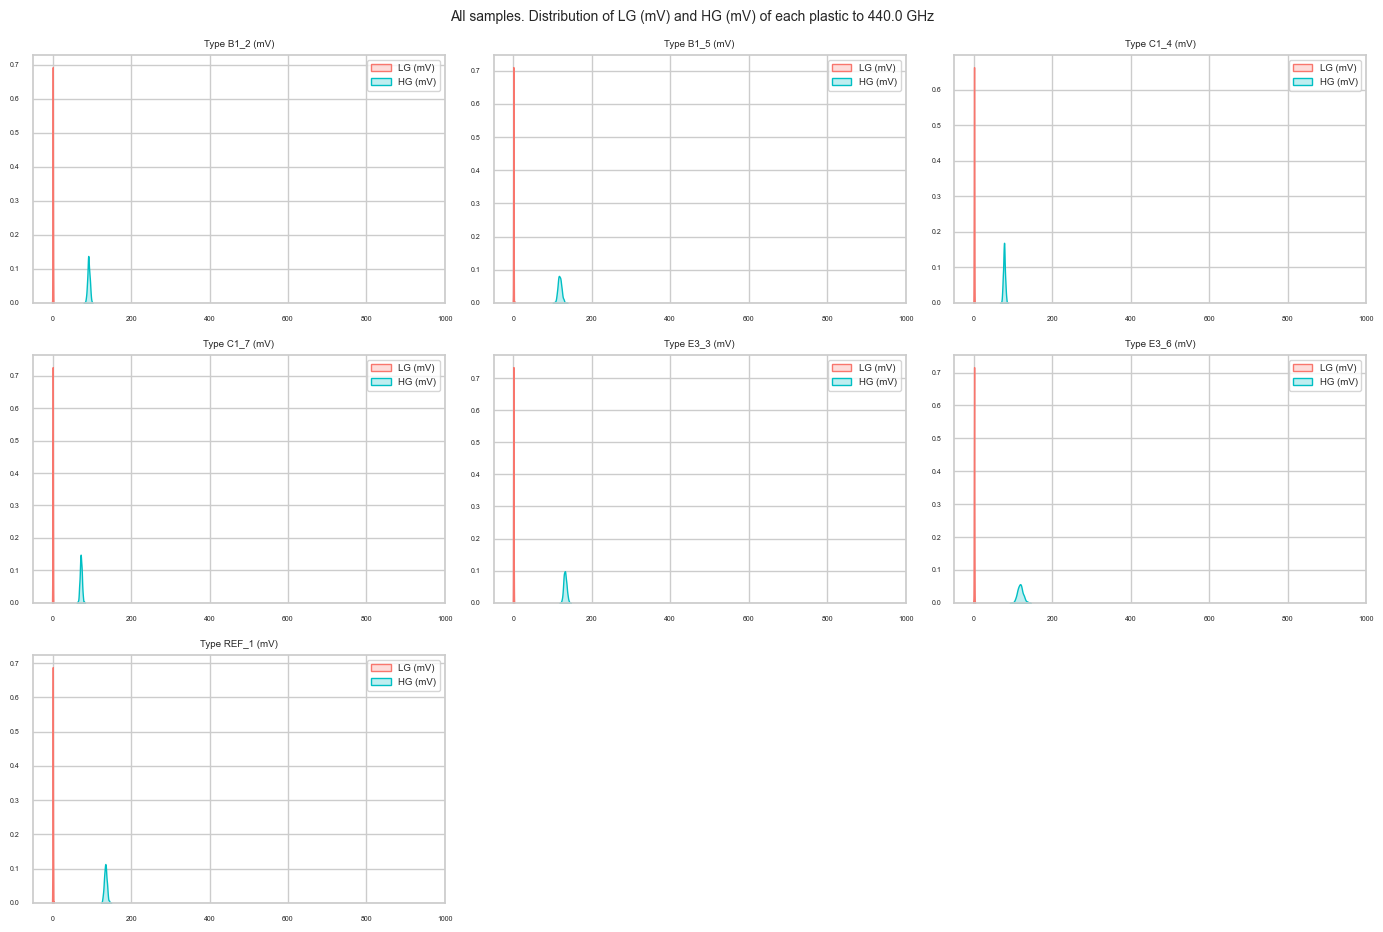

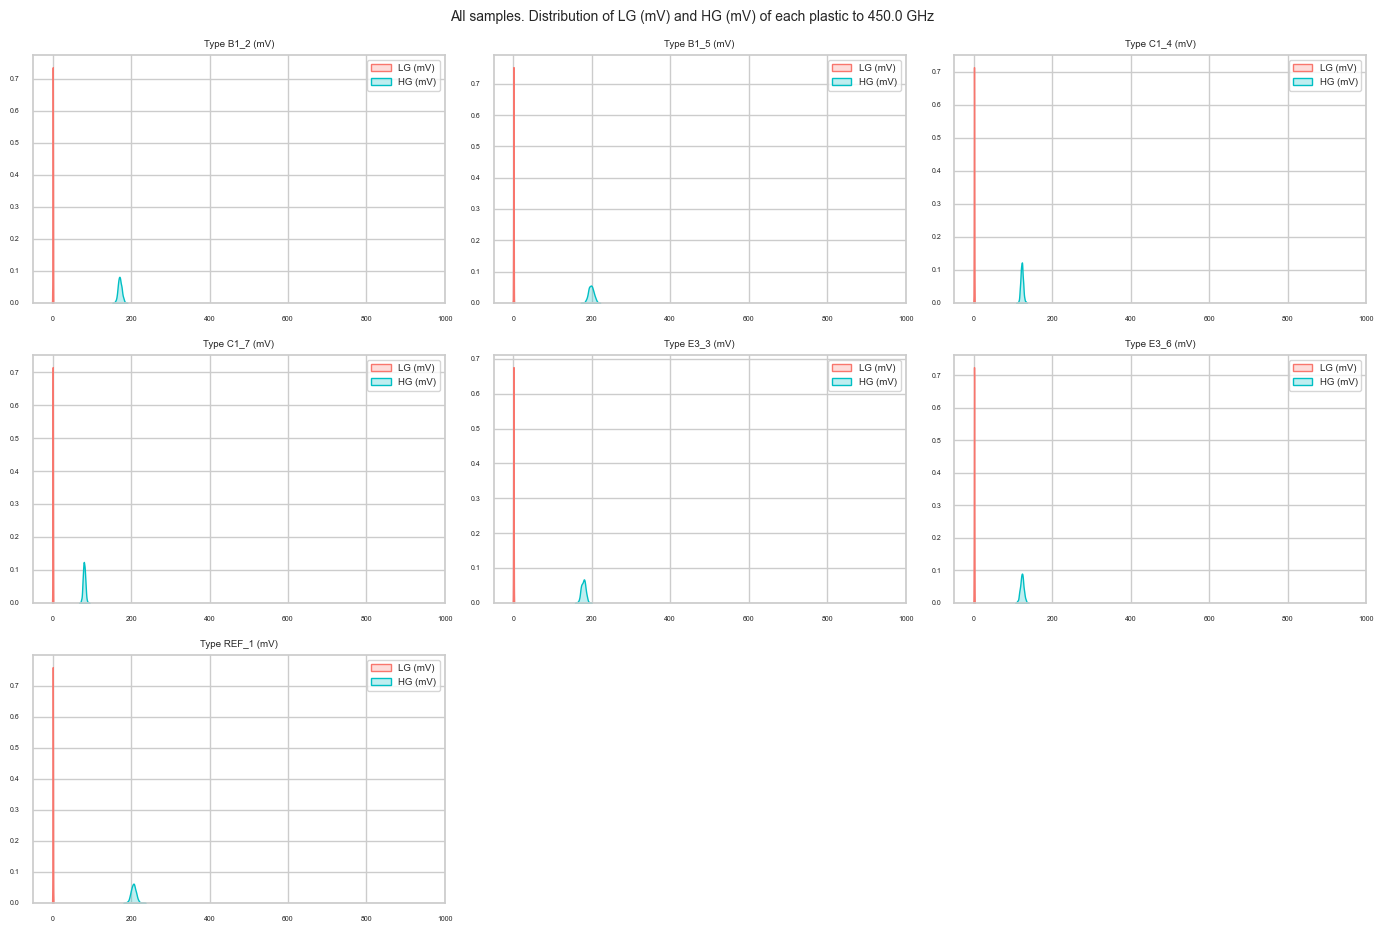

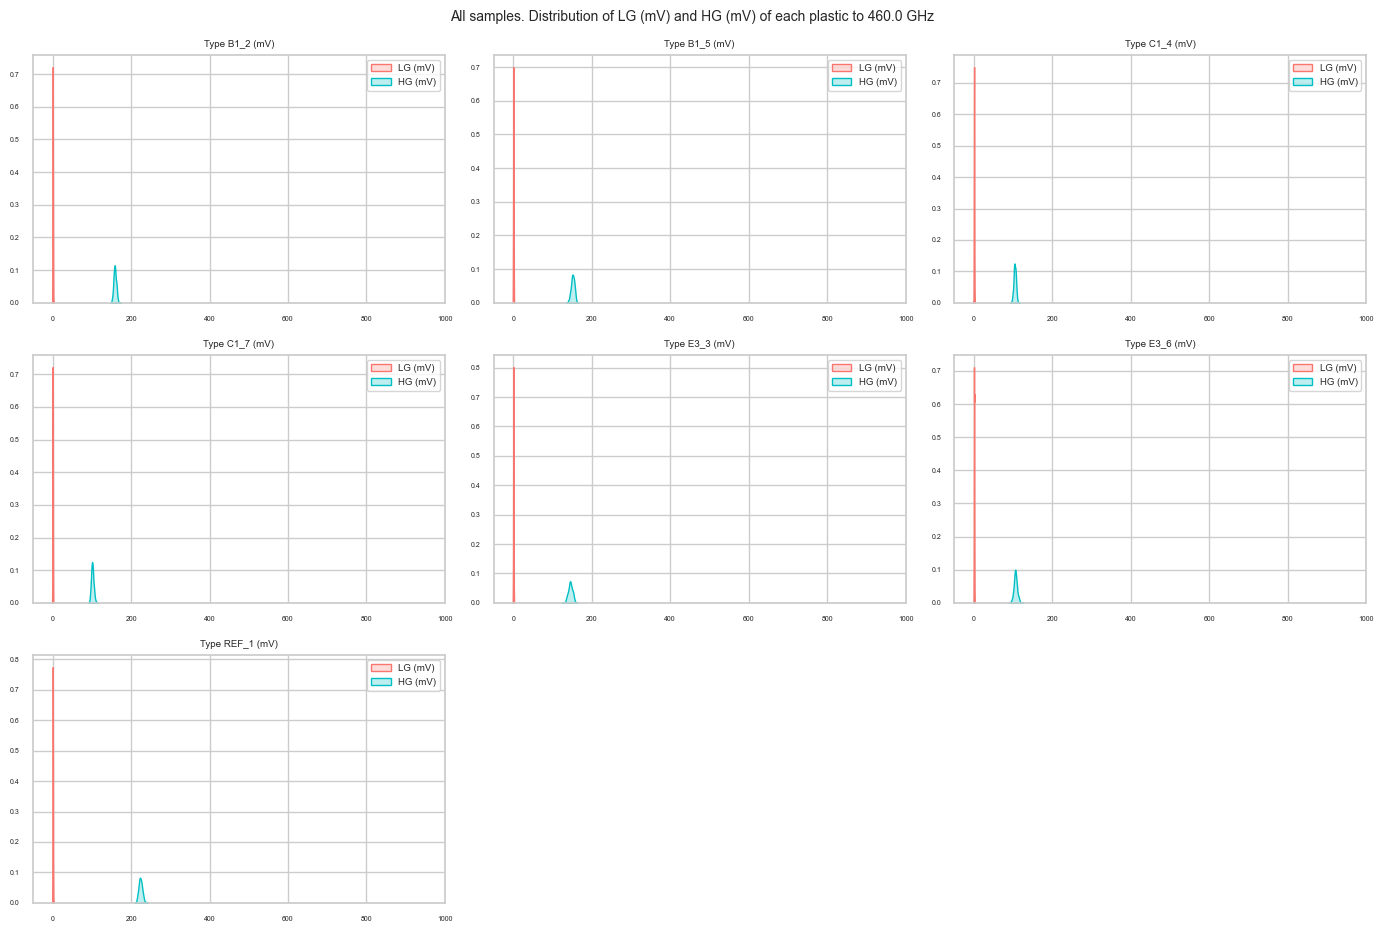

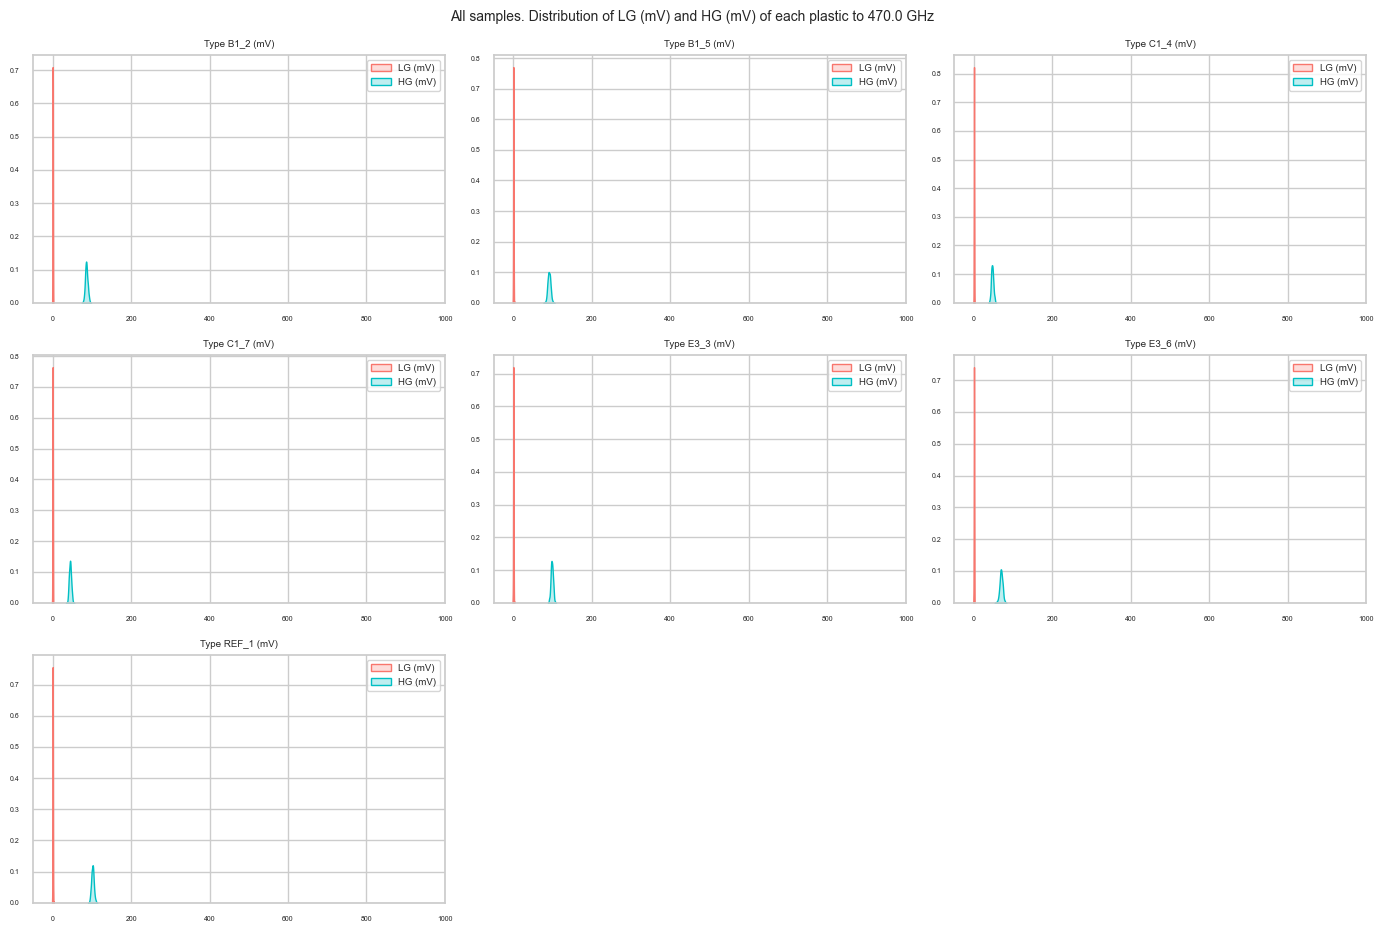

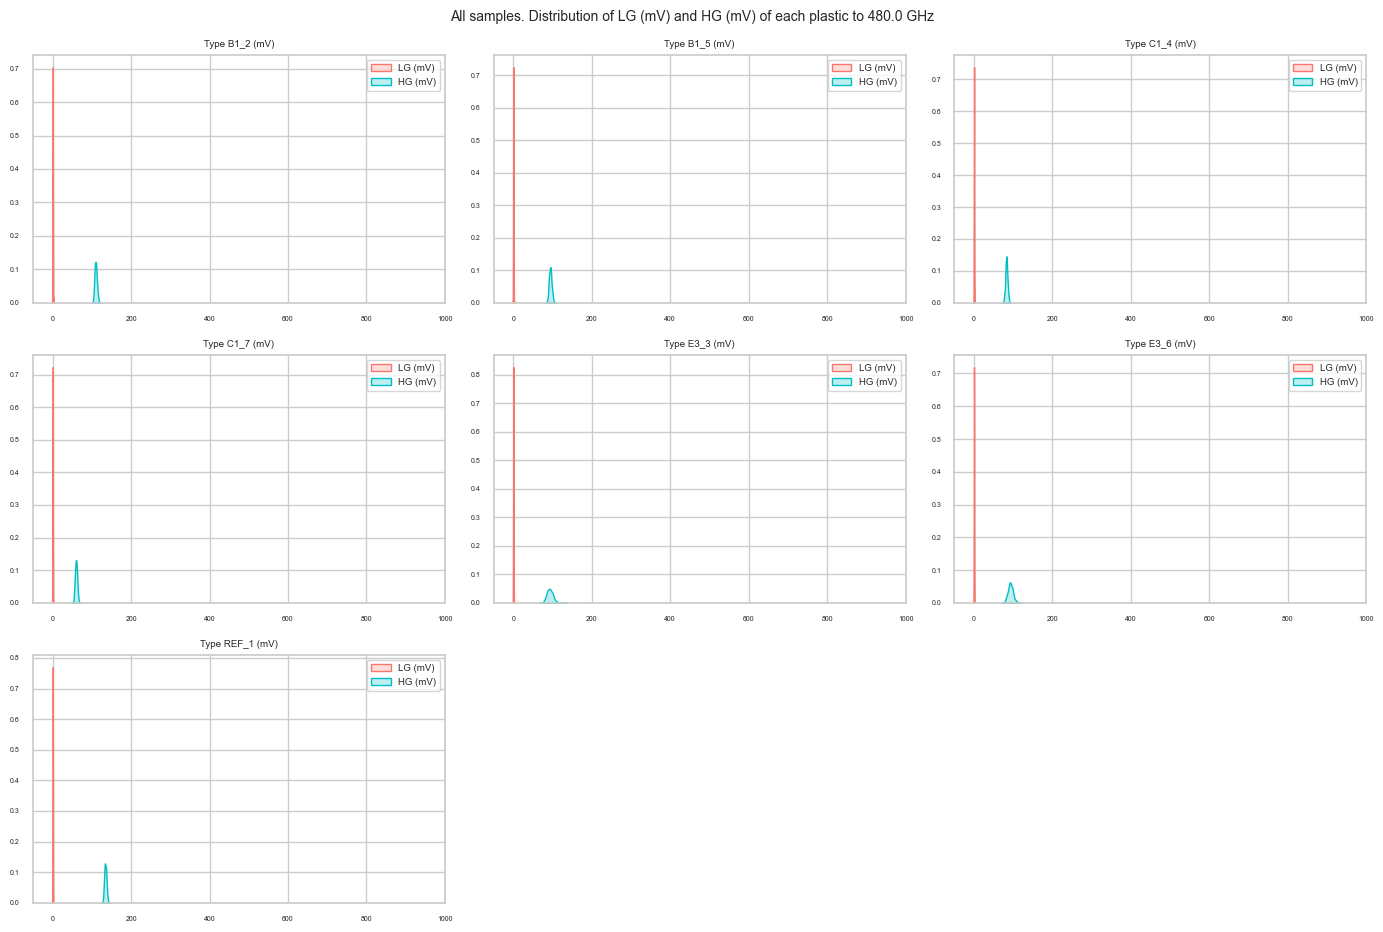

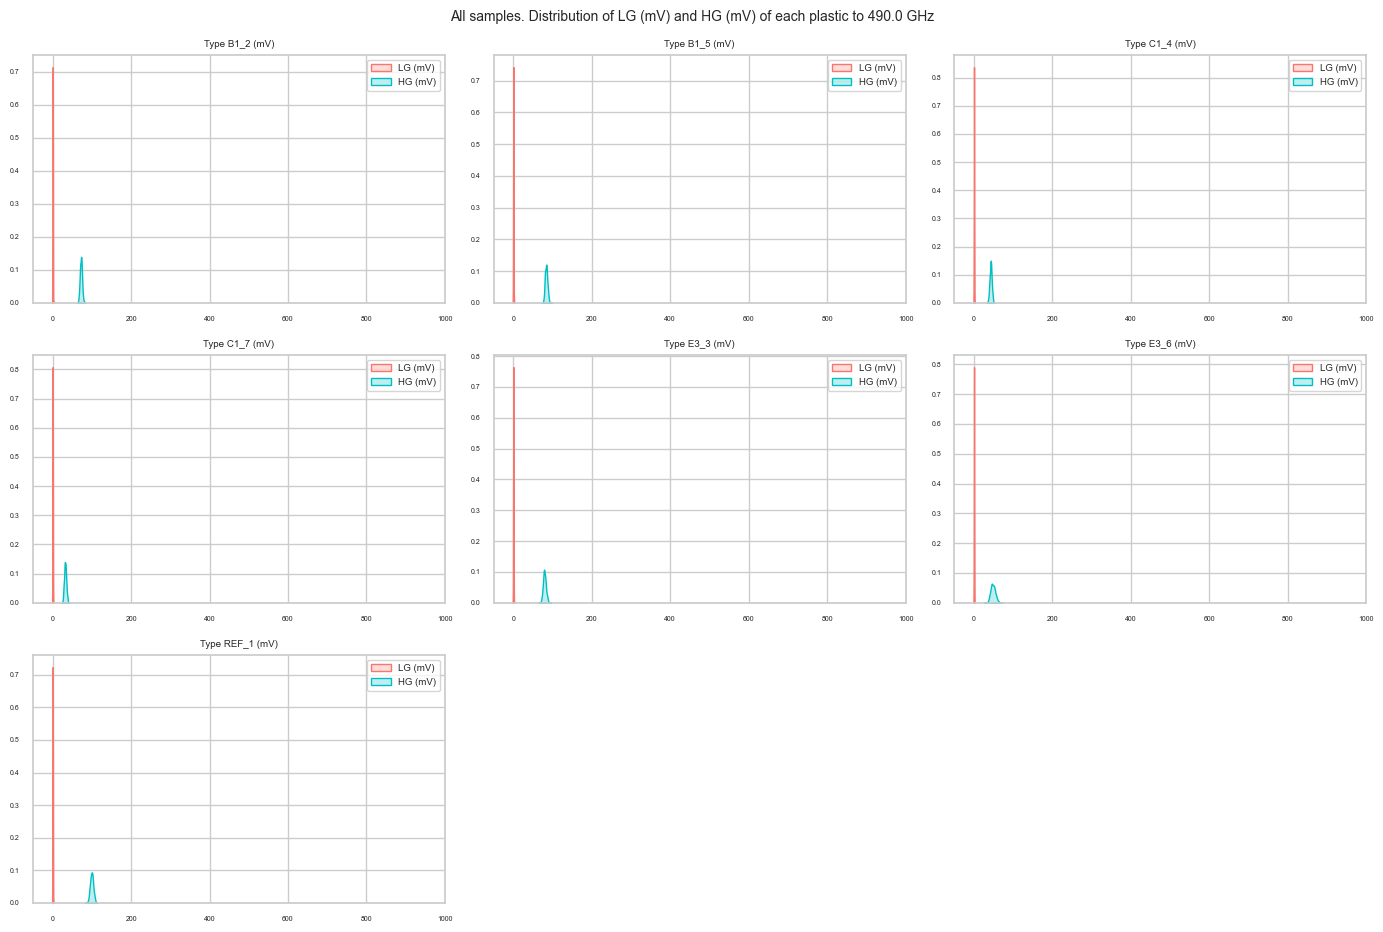

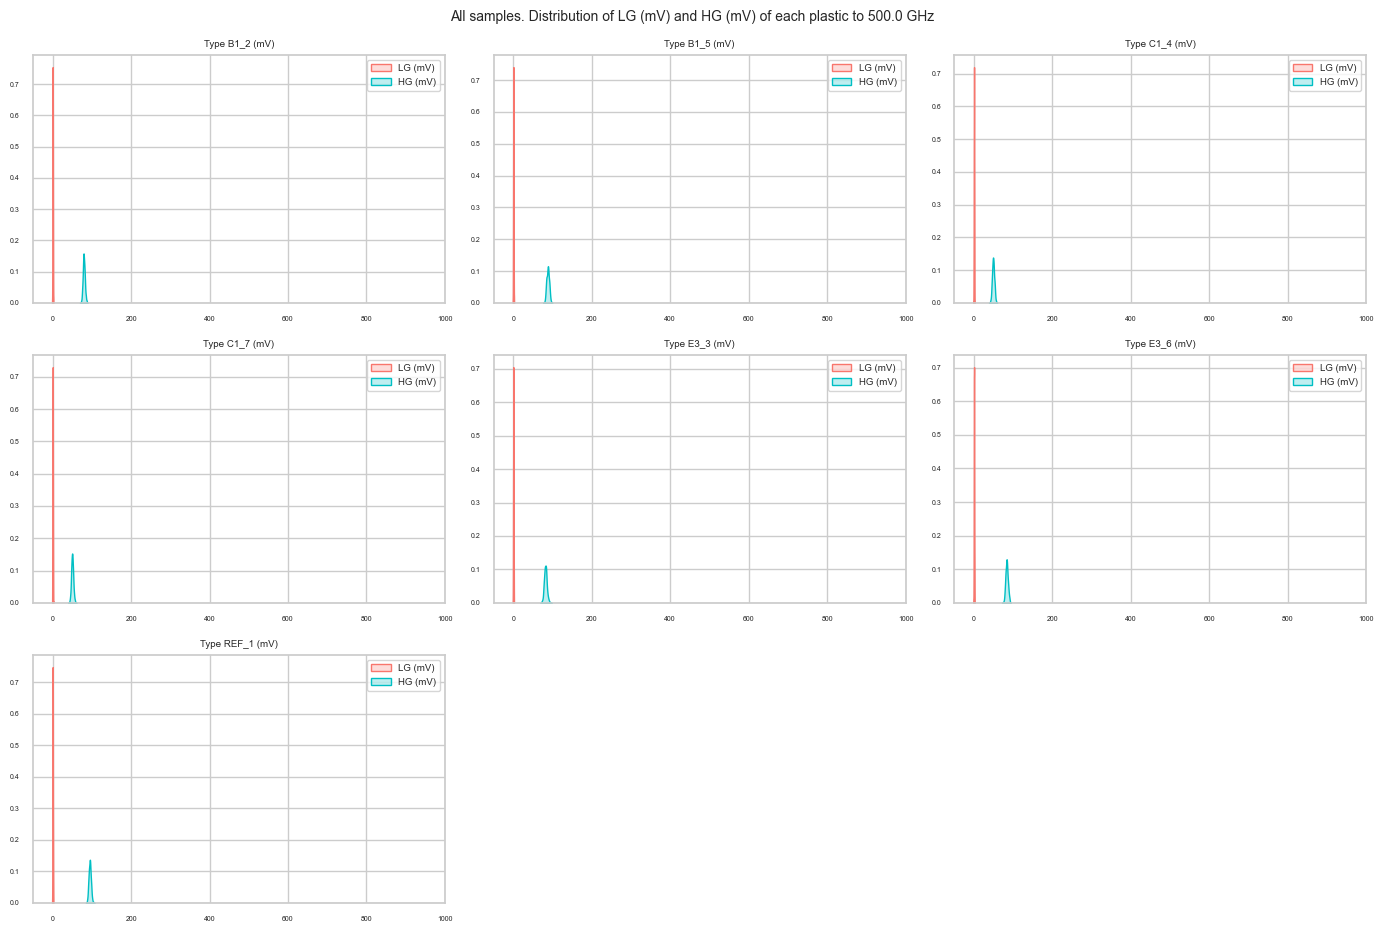

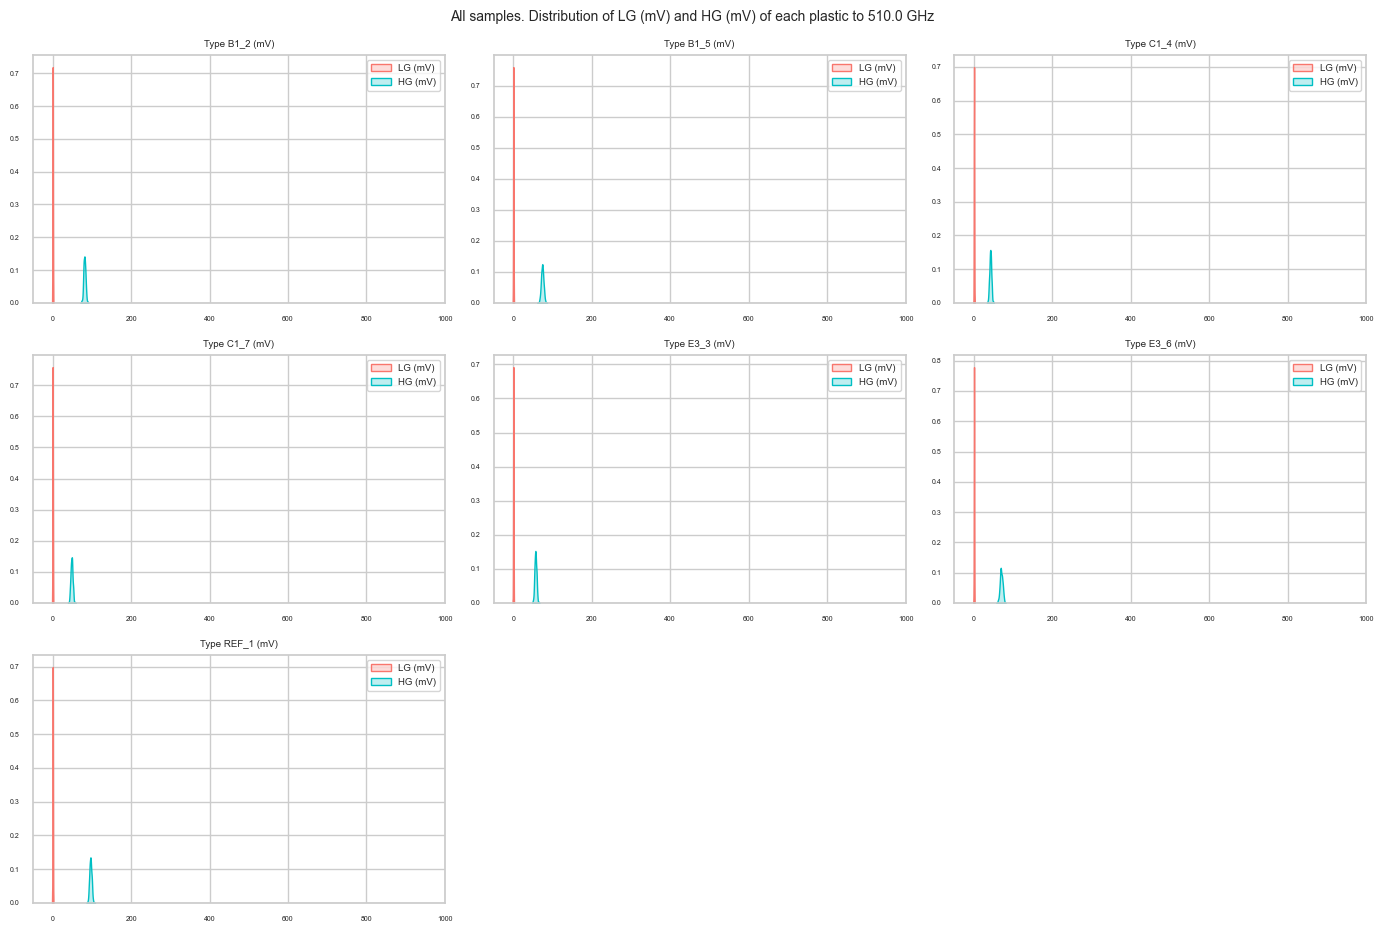

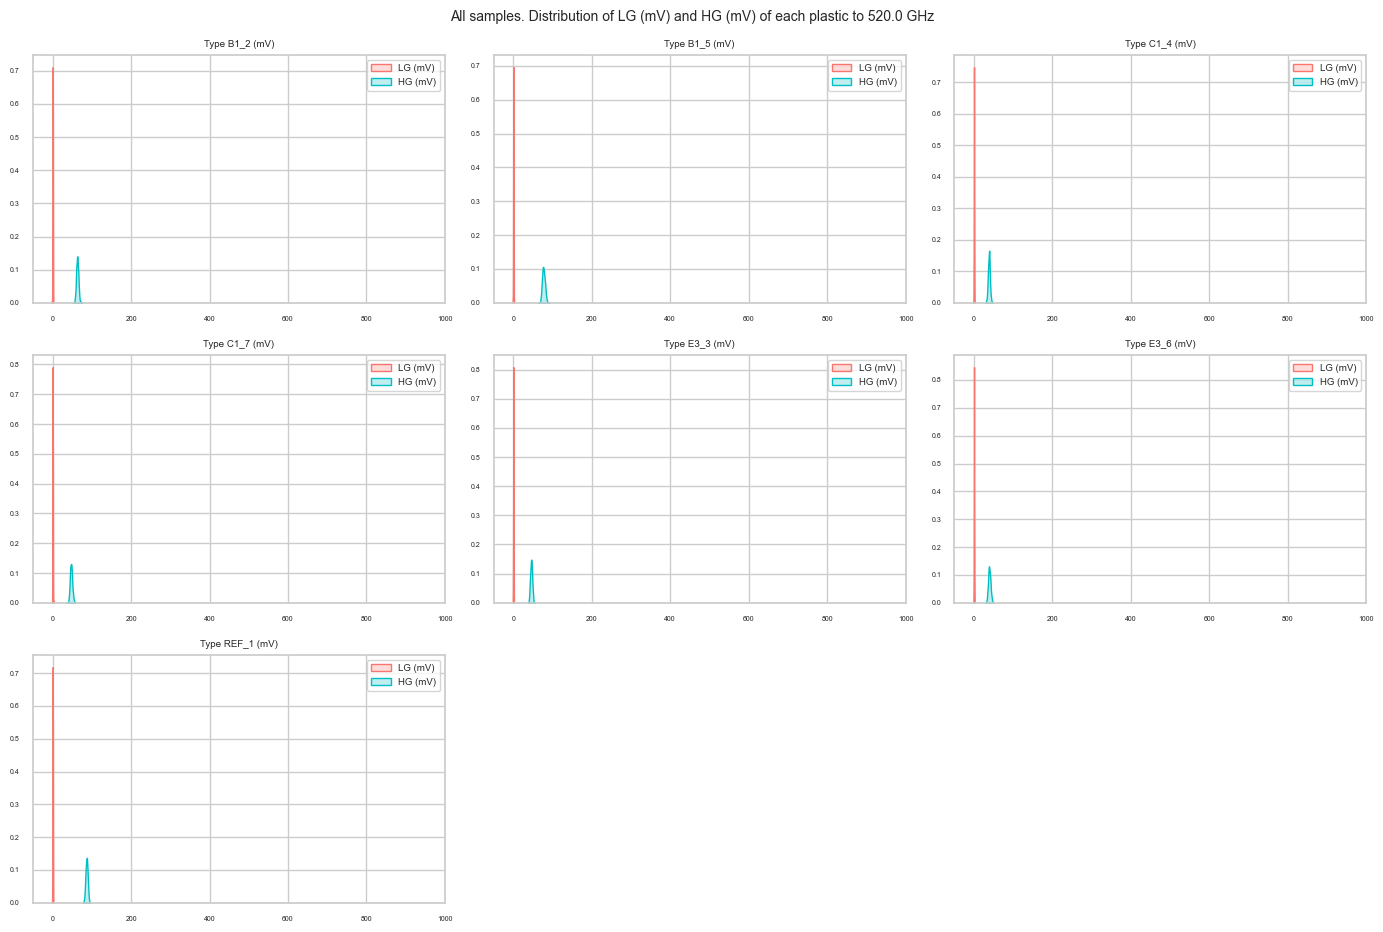

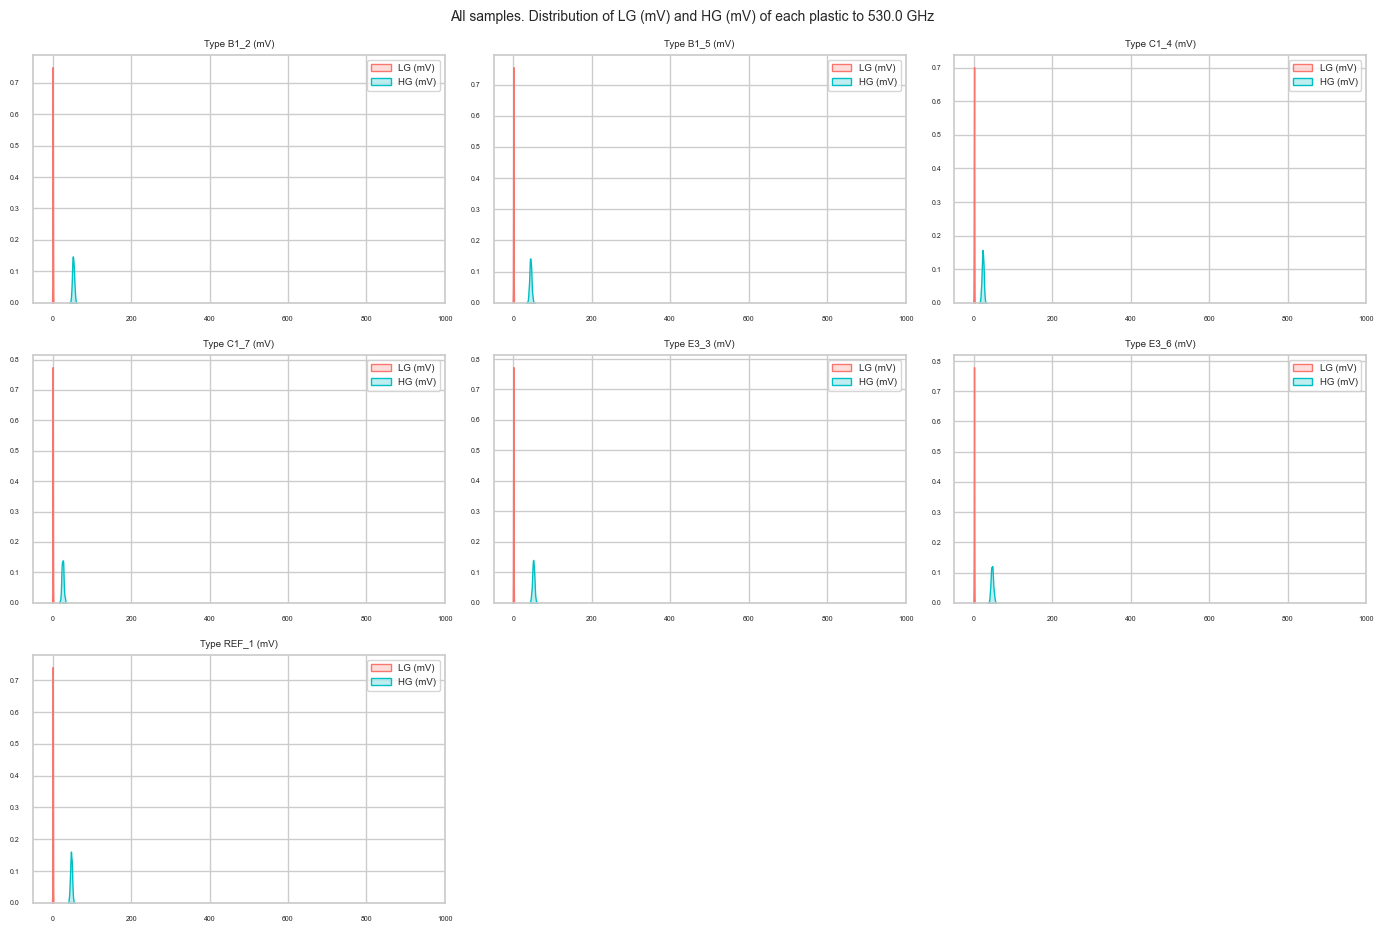

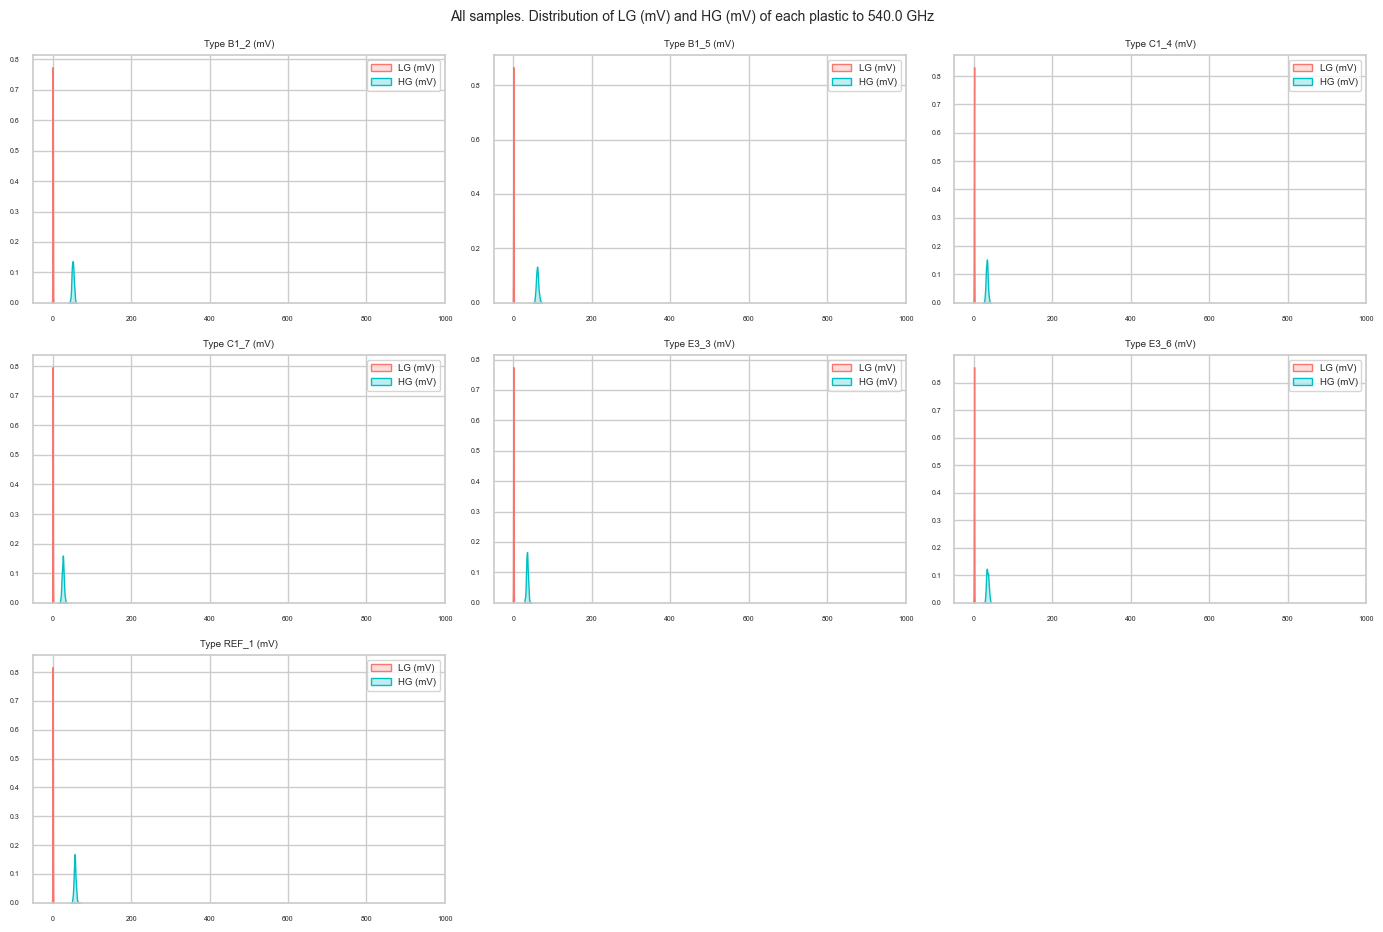

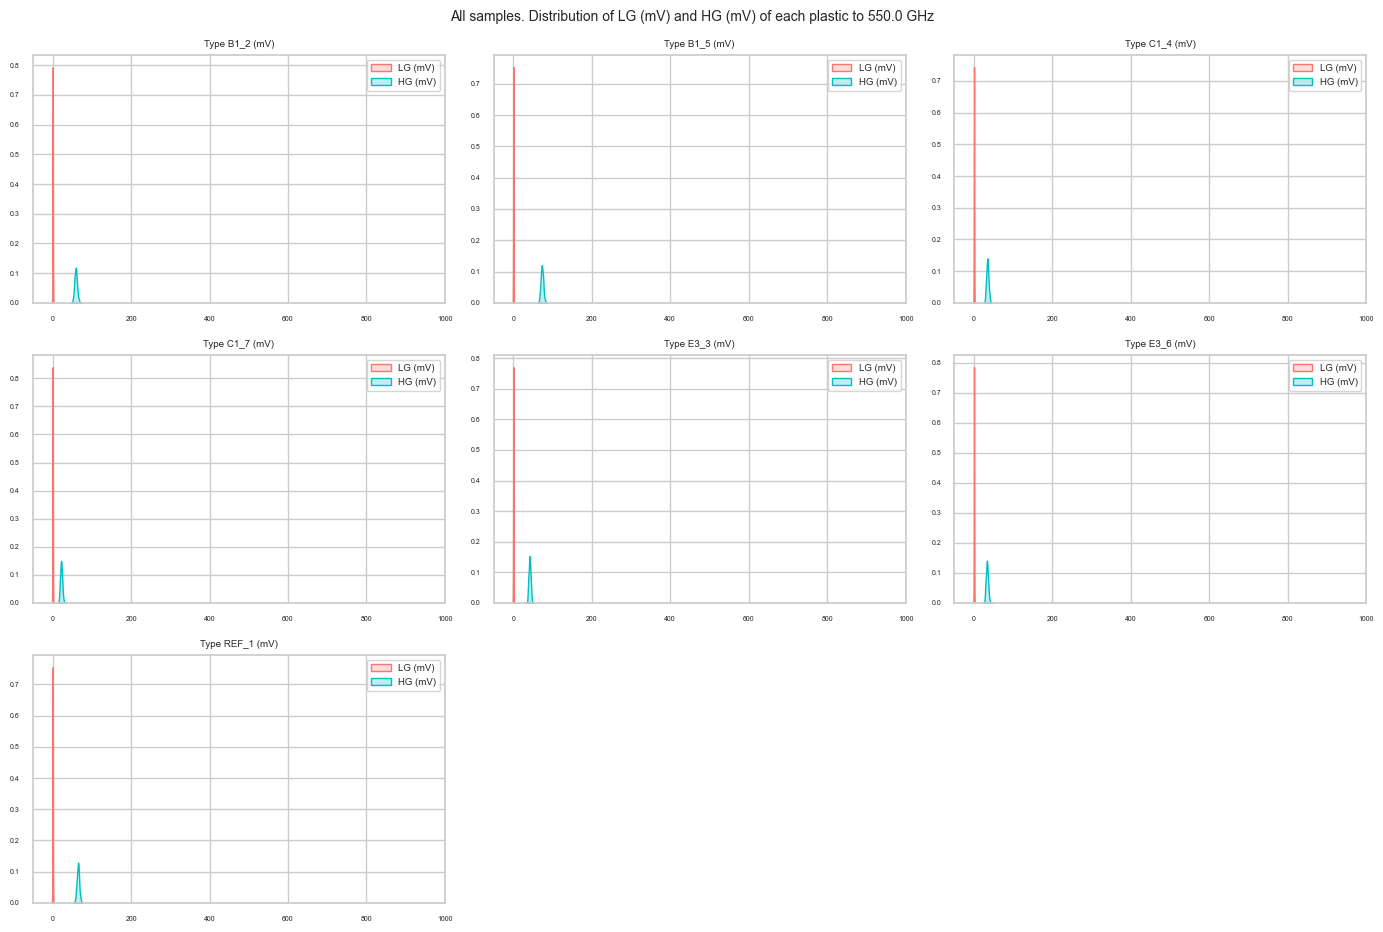

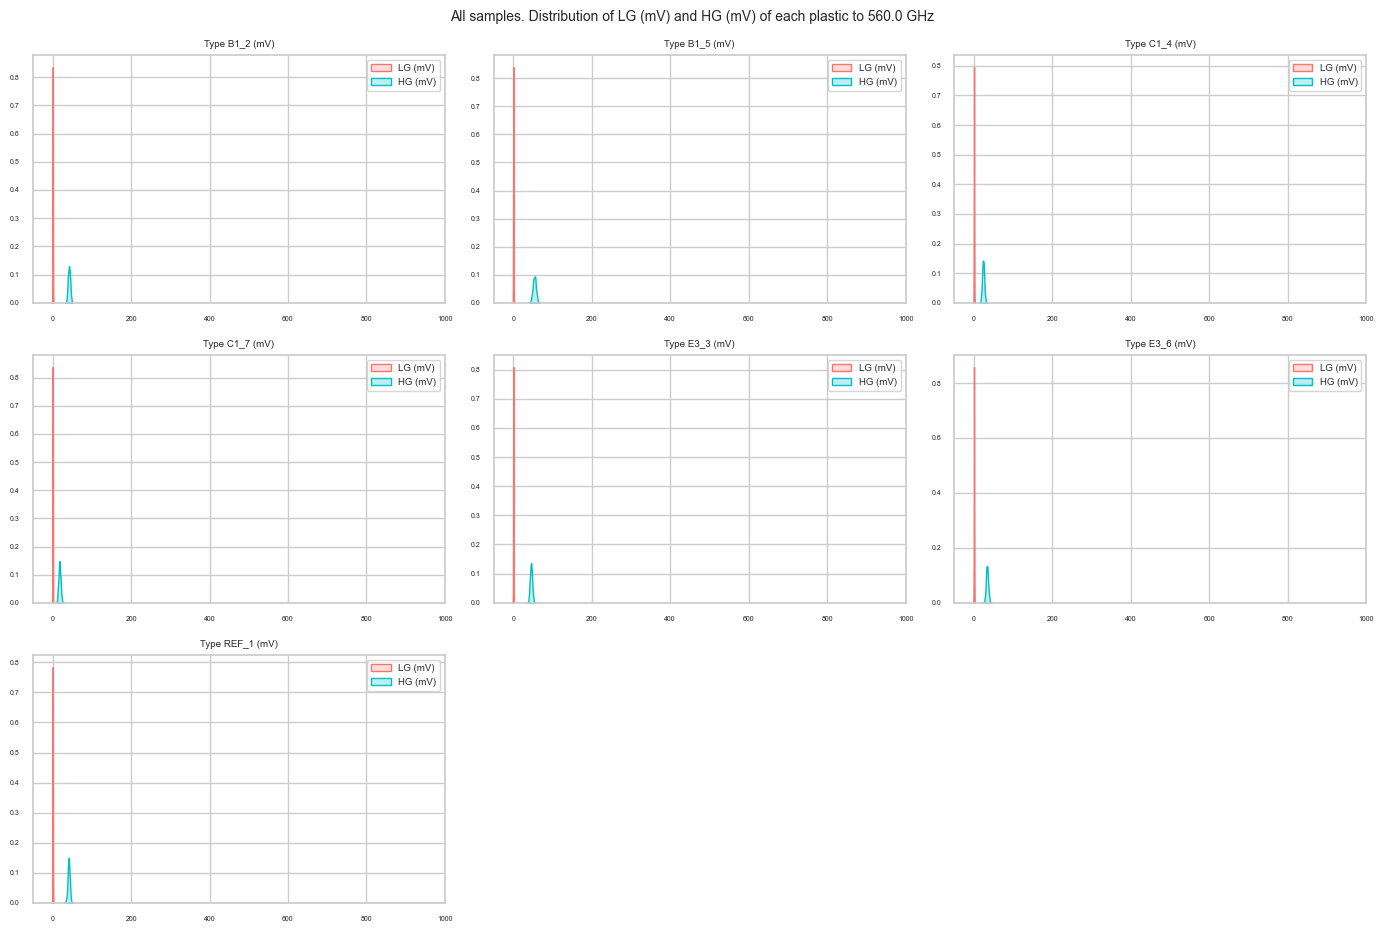

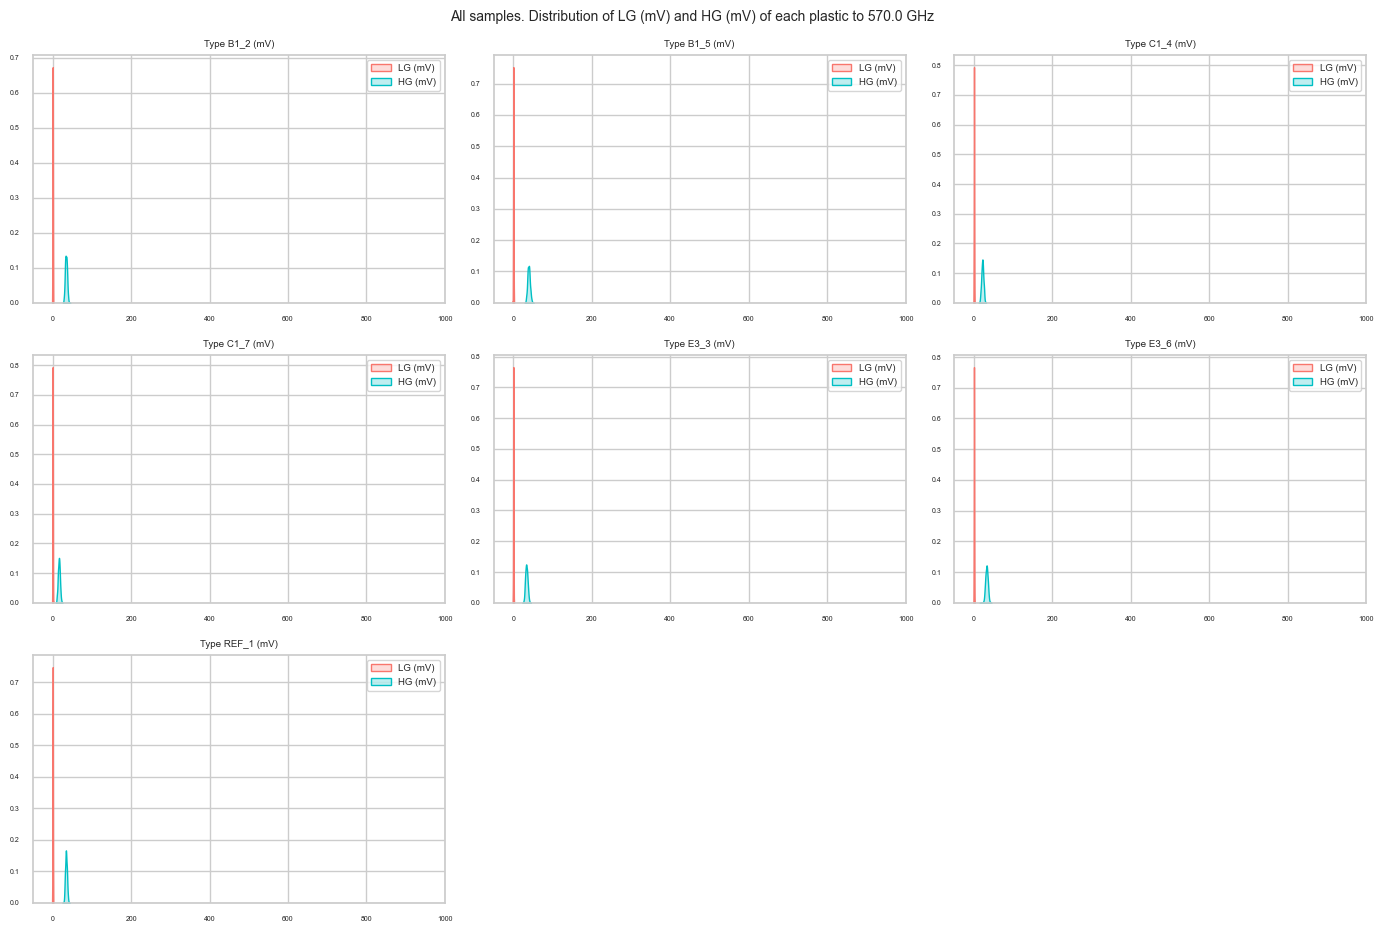

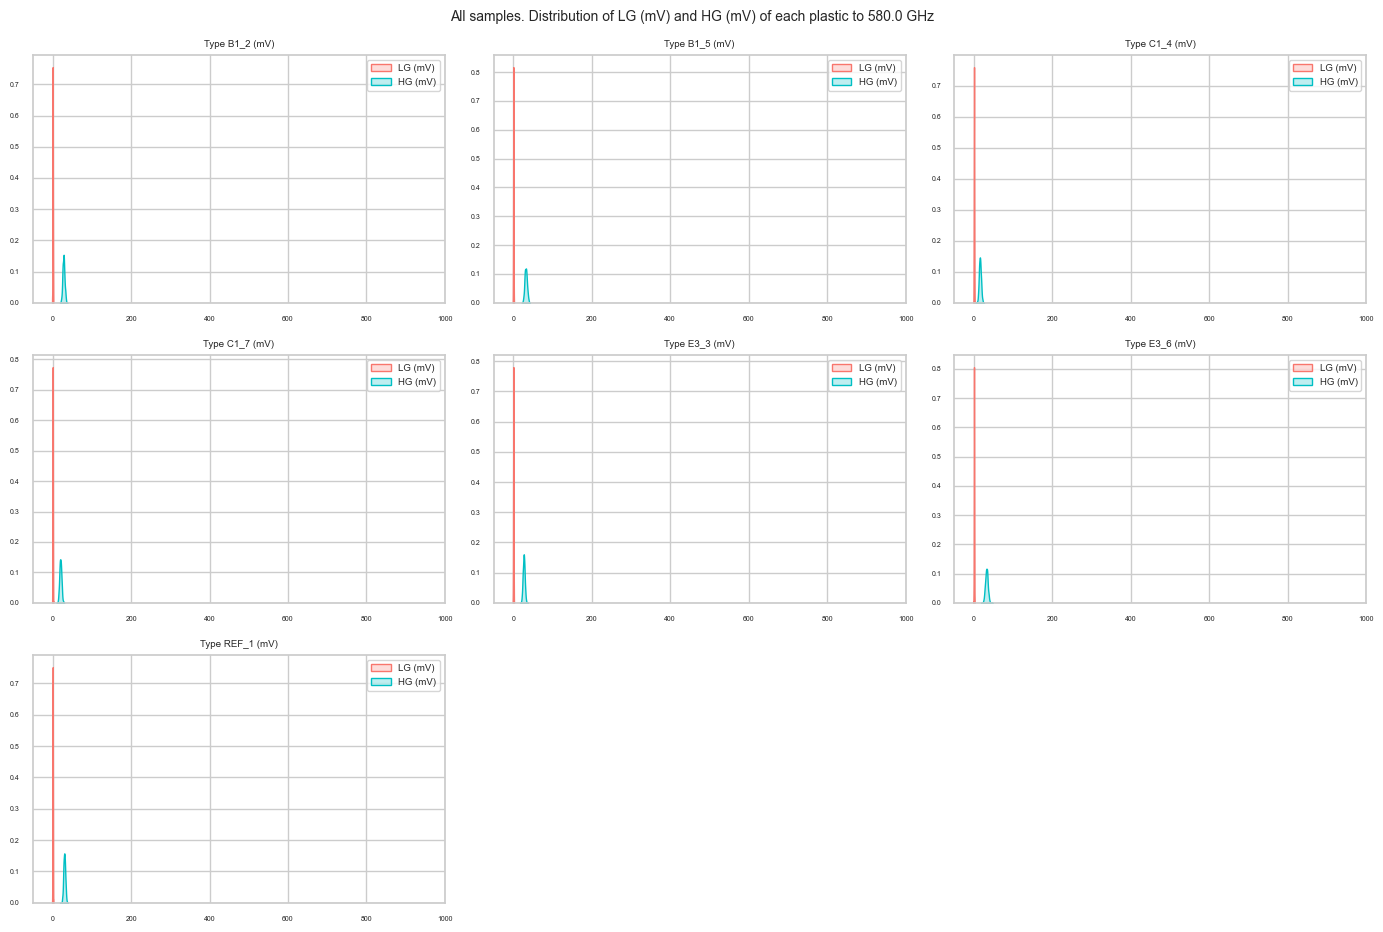

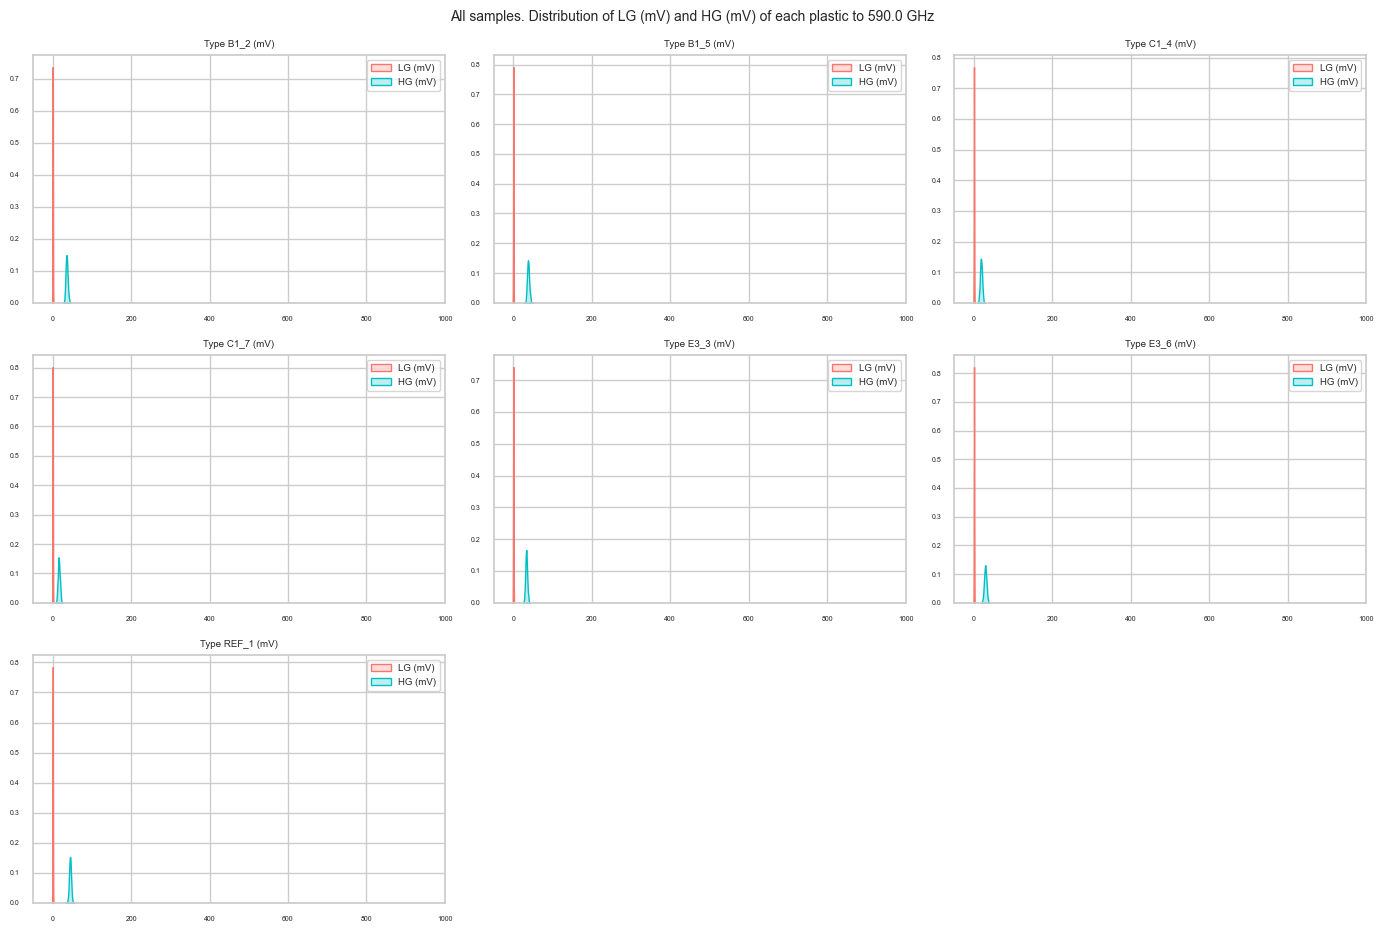

In [78]:
warnings.filterwarnings('ignore')

train_ex = df_balanced.copy()

print(train_ex.head())


for f in train_ex['Frequency (GHz)'].value_counts().index.sort_values().tolist():
    freq = f
    ncols = 3
    nrows = 3
    nums_plastics = 0
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(14, 10))
    axes = axes.flatten()  # Flatten the axes array
    
    for r in range(nrows * ncols):  # Adjust the loop to iterate over the flattened array
        t = train_ex['Sample'].value_counts().index.sort_values().tolist()
        if nums_plastics < len(t):
            df_tmp = train_ex[(train_ex['Frequency (GHz)'] == freq) & (train_ex['Sample'] == t[nums_plastics])]
            sns.kdeplot(x=df_tmp['LG (mV)'], ax=axes[r], color='#F8766D', label='LG (mV)', fill=True)
            sns.kdeplot(x=df_tmp['HG (mV)'], ax=axes[r], color='#00BFC4', label='HG (mV)', fill=True)
            axes[r].legend(fontsize="xx-small")
            axes[r].set_ylabel('')
            axes[r].set_xlabel('')
            axes[r].set_title(f"Type {t[nums_plastics]} (mV)", fontsize=7)
            axes[r].tick_params(labelsize=5, width=0.5)
            axes[r].xaxis.offsetText.set_fontsize(6)
            axes[r].yaxis.offsetText.set_fontsize(4)
            axes[r].set_xlim(-50, 1000)
            nums_plastics += 1
        else:
            axes[r].axis('off')
    plt.suptitle(f"All samples. Distribution of LG (mV) and HG (mV) of each plastic to {freq} GHz", y=0.93, fontsize=10)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Save plots
    # output_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_2_plastics/plots/data_distribution_per_freq'
    # output_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_3_repeatibility/plots/data_distribution_per_freq'
    # # output_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_4_plastics/plots/data_distribution_per_freq'

    # if not os.path.exists(output_path):
    #     os.makedirs(output_path)
    # plt.savefig(f"{output_path}/data_distribution_per_freq_{freq}.png", dpi=500)

    plt.show()





In [81]:
print(', '.join(df_balanced['Sample'].unique())) 


B1_2, B1_5, C1_4, C1_7, E3_3, E3_6, REF_1


## mV Average with error per frequency

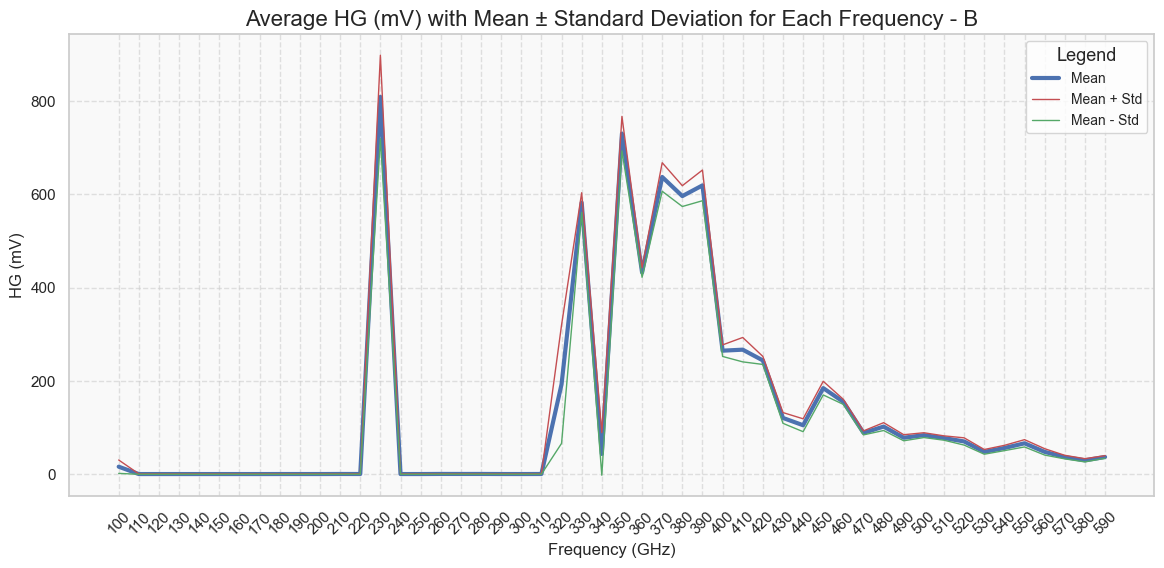

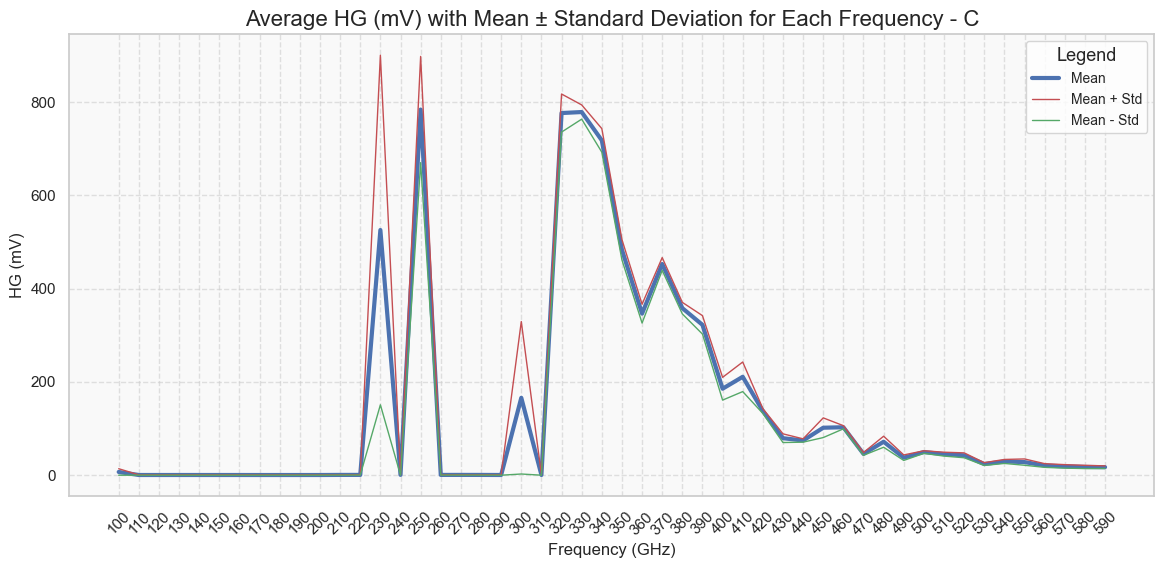

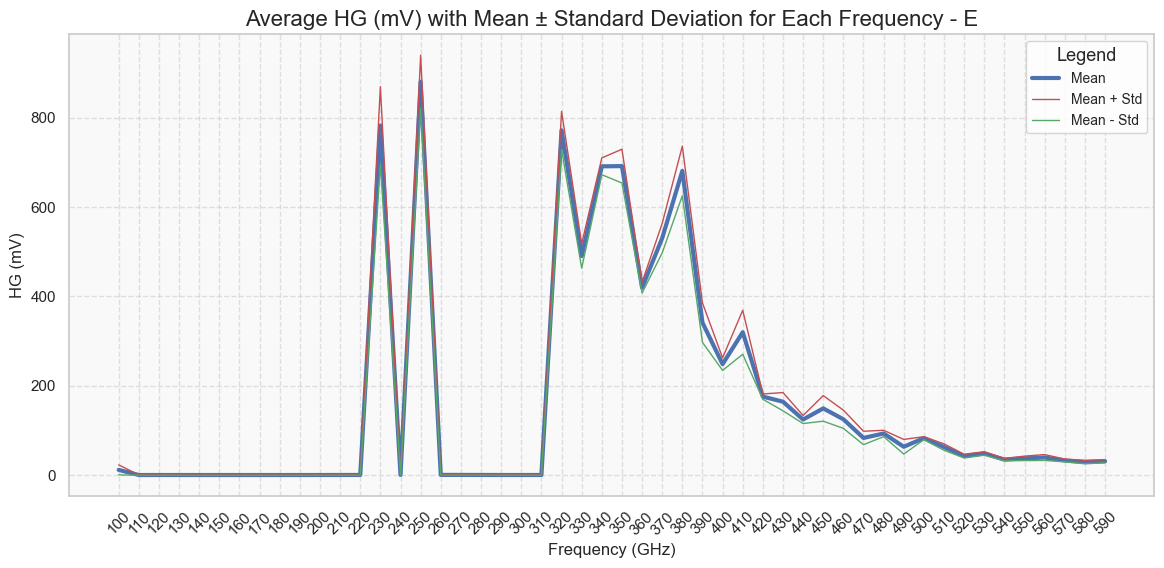

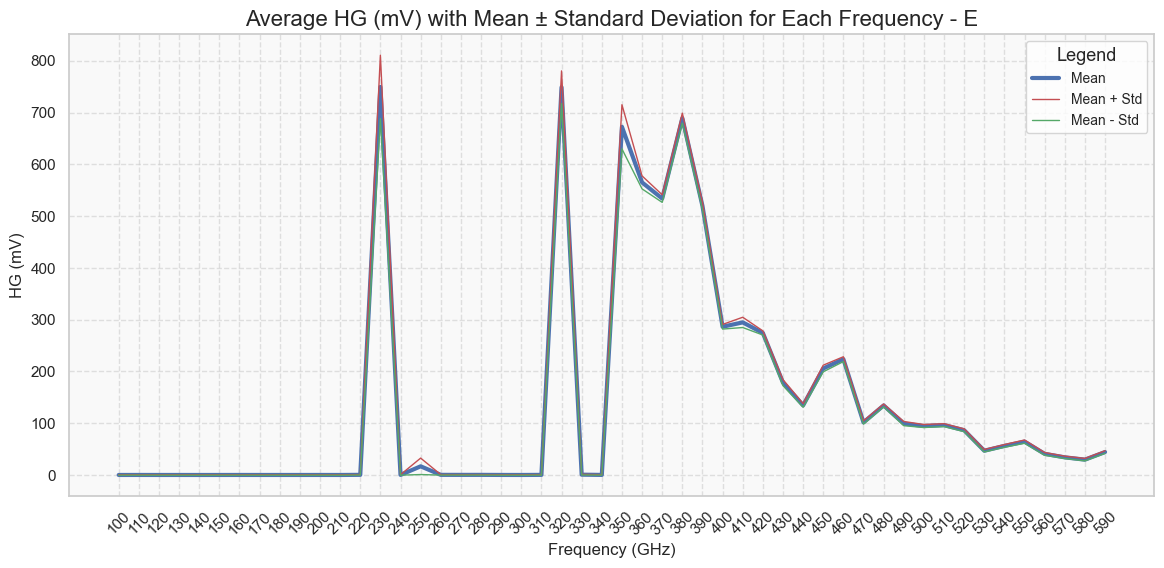

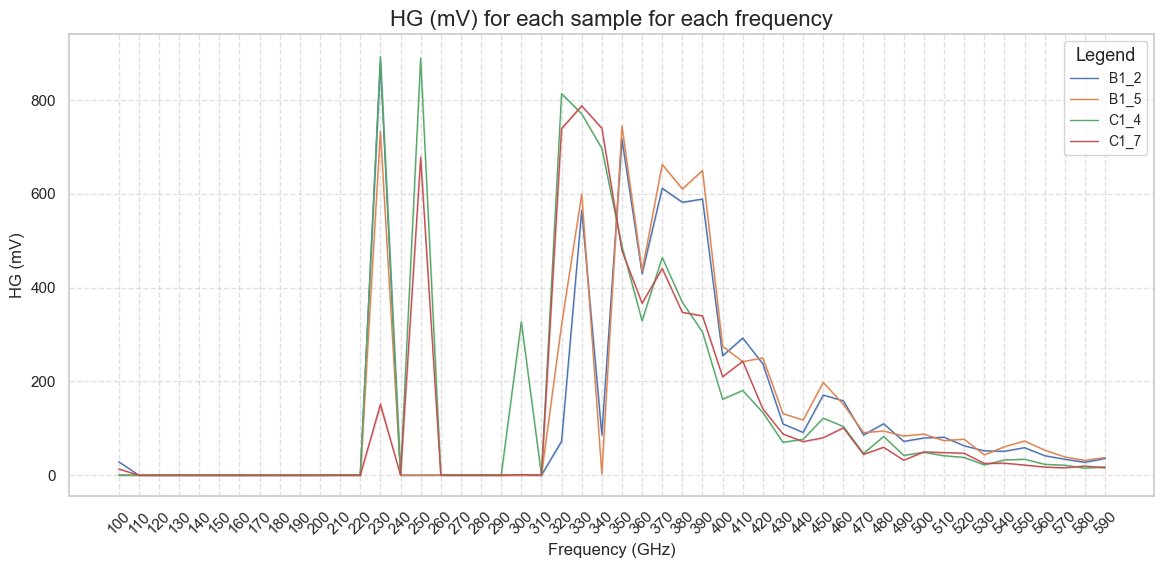

In [91]:
df_tmp = df_balanced.copy()

labels = [ 'REF_1', 'REF_2', 'REF_3', 'REF_4','REF_5', 'REF_6', 'REF_7', 'REF_8', 'REF_9','REF_10',  'REF_11','REF_12',  'REF_13', 'REF_14', 'REF_15']
# ['B1_2', 'B1_5,' 'C1_4', 'C1_7', 'E3_3', 'E3_6', 'REF_1']
labels = [ 'B1_2', 'B1_5']

df_tmp = df_tmp[df_tmp['Sample'].isin(labels)]

# Calculate the mean and standard deviation of HG (mV) for each frequency
hg_stats = df_tmp.groupby('Frequency (GHz)')['HG (mV)'].agg(['mean', 'std']).reset_index()

# Calculate the upper and lower bounds
hg_stats['mean_plus_std'] = hg_stats['mean'] + hg_stats['std']
hg_stats['mean_minus_std'] = hg_stats['mean'] - hg_stats['std']

# Plot the average HG (mV) with lines for mean ± standard deviation
plt.figure(figsize=(14, 6))
sns.set_theme(style="whitegrid")

# Plot mean line
sns.lineplot(data=hg_stats, x='Frequency (GHz)', y='mean', marker='', color='b', linewidth=3, label='Mean')

# Plot mean + 1 std line
sns.lineplot(data=hg_stats, x='Frequency (GHz)', y='mean_plus_std', marker='', color='r', linestyle='-', linewidth=1, label='Mean + Std')

# Plot mean - 1 std line
sns.lineplot(data=hg_stats, x='Frequency (GHz)', y='mean_minus_std', marker='', color='g', linestyle='-', linewidth=1, label='Mean - Std')

# Add labels and title
plt.xlabel('Frequency (GHz)', fontsize=12)
plt.ylabel('HG (mV)', fontsize=12)
plt.title('Average HG (mV) with Mean ± Standard Deviation for Each Frequency - B', fontsize=16)

# X axis space adjustment (show 1 of each 2 ticks)
plt.xticks(hg_stats['Frequency (GHz)'].unique(), rotation=45)

# Customize legend
plt.legend(fontsize=10, title='Legend', title_fontsize='13')

# Customize grid and background
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().set_facecolor('#f9f9f9')

# Show plot
plt.show()



df_tmp2 = df_balanced.copy()

# labels = [ 'REF_1', 'REF_2', 'REF_3', 'REF_4','REF_5', 'REF_6', 'REF_7', 'REF_8', 'REF_9','REF_10',  'REF_11','REF_12',  'REF_13', 'REF_14', 'REF_15']
# labels = [ 'REF_2', 'REF_3', 'REF_4', 'REF_6', 'REF_7', 'REF_8', 'REF_9',  'REF_11',  'REF_13', 'REF_14', 'REF_15']
labels = [ 'C1_4', 'C1_7']


df_tmp2 = df_tmp2[df_tmp2['Sample'].isin(labels)]


# Calculate the mean and standard deviation of HG (mV) for each frequency
hg_stats = df_tmp2.groupby('Frequency (GHz)')['HG (mV)'].agg(['mean', 'std']).reset_index()

# Calculate the upper and lower bounds
hg_stats['mean_plus_std'] = hg_stats['mean'] + hg_stats['std']
hg_stats['mean_minus_std'] = hg_stats['mean'] - hg_stats['std']

# Plot the average HG (mV) with lines for mean ± standard deviation
plt.figure(figsize=(14, 6))
sns.set_theme(style="whitegrid")

# Plot mean line
sns.lineplot(data=hg_stats, x='Frequency (GHz)', y='mean', marker='', color='b', linewidth=3, label='Mean')

# Plot mean + 1 std line
sns.lineplot(data=hg_stats, x='Frequency (GHz)', y='mean_plus_std', marker='', color='r', linestyle='-', linewidth=1, label='Mean + Std')

# Plot mean - 1 std line
sns.lineplot(data=hg_stats, x='Frequency (GHz)', y='mean_minus_std', marker='', color='g', linestyle='-', linewidth=1, label='Mean - Std')

# Add labels and title
plt.xlabel('Frequency (GHz)', fontsize=12)
plt.ylabel('HG (mV)', fontsize=12)
plt.title('Average HG (mV) with Mean ± Standard Deviation for Each Frequency - C', fontsize=16)

# X axis space adjustment (show 1 of each 2 ticks)
plt.xticks(hg_stats['Frequency (GHz)'].unique(), rotation=45)

# Customize legend
plt.legend(fontsize=10, title='Legend', title_fontsize='13')

# Customize grid and background
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().set_facecolor('#f9f9f9')

# Show plot
plt.show()

df_tmp3 = df_balanced.copy()

# labels = [ 'REF_1', 'REF_2', 'REF_3', 'REF_4','REF_5', 'REF_6', 'REF_7', 'REF_8', 'REF_9','REF_10',  'REF_11','REF_12',  'REF_13', 'REF_14', 'REF_15']
# labels = [ 'REF_2', 'REF_3', 'REF_4', 'REF_6', 'REF_7', 'REF_8', 'REF_9',  'REF_11',  'REF_13', 'REF_14', 'REF_15']
labels = [ 'E3_3', 'E3_6']


df_tmp3 = df_tmp3[df_tmp3['Sample'].isin(labels)]


# Calculate the mean and standard deviation of HG (mV) for each frequency
hg_stats = df_tmp3.groupby('Frequency (GHz)')['HG (mV)'].agg(['mean', 'std']).reset_index()

# Calculate the upper and lower bounds
hg_stats['mean_plus_std'] = hg_stats['mean'] + hg_stats['std']
hg_stats['mean_minus_std'] = hg_stats['mean'] - hg_stats['std']

# Plot the average HG (mV) with lines for mean ± standard deviation
plt.figure(figsize=(14, 6))
sns.set_theme(style="whitegrid")

# Plot mean line
sns.lineplot(data=hg_stats, x='Frequency (GHz)', y='mean', marker='', color='b', linewidth=3, label='Mean')

# Plot mean + 1 std line
sns.lineplot(data=hg_stats, x='Frequency (GHz)', y='mean_plus_std', marker='', color='r', linestyle='-', linewidth=1, label='Mean + Std')

# Plot mean - 1 std line
sns.lineplot(data=hg_stats, x='Frequency (GHz)', y='mean_minus_std', marker='', color='g', linestyle='-', linewidth=1, label='Mean - Std')

# Add labels and title
plt.xlabel('Frequency (GHz)', fontsize=12)
plt.ylabel('HG (mV)', fontsize=12)
plt.title('Average HG (mV) with Mean ± Standard Deviation for Each Frequency - E', fontsize=16)

# X axis space adjustment (show 1 of each 2 ticks)
plt.xticks(hg_stats['Frequency (GHz)'].unique(), rotation=45)

# Customize legend
plt.legend(fontsize=10, title='Legend', title_fontsize='13')

# Customize grid and background
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().set_facecolor('#f9f9f9')

# Show plot
plt.show()


df_tmp4 = df_balanced.copy()

# labels = [ 'REF_1', 'REF_2', 'REF_3', 'REF_4','REF_5', 'REF_6', 'REF_7', 'REF_8', 'REF_9','REF_10',  'REF_11','REF_12',  'REF_13', 'REF_14', 'REF_15']
# labels = [ 'REF_2', 'REF_3', 'REF_4', 'REF_6', 'REF_7', 'REF_8', 'REF_9',  'REF_11',  'REF_13', 'REF_14', 'REF_15']
labels = [ 'REF_1']


df_tmp4 = df_tmp4[df_tmp4['Sample'].isin(labels)]


# Calculate the mean and standard deviation of HG (mV) for each frequency
hg_stats = df_tmp4.groupby('Frequency (GHz)')['HG (mV)'].agg(['mean', 'std']).reset_index()

# Calculate the upper and lower bounds
hg_stats['mean_plus_std'] = hg_stats['mean'] + hg_stats['std']
hg_stats['mean_minus_std'] = hg_stats['mean'] - hg_stats['std']

# Plot the average HG (mV) with lines for mean ± standard deviation
plt.figure(figsize=(14, 6))
sns.set_theme(style="whitegrid")

# Plot mean line
sns.lineplot(data=hg_stats, x='Frequency (GHz)', y='mean', marker='', color='b', linewidth=3, label='Mean')

# Plot mean + 1 std line
sns.lineplot(data=hg_stats, x='Frequency (GHz)', y='mean_plus_std', marker='', color='r', linestyle='-', linewidth=1, label='Mean + Std')

# Plot mean - 1 std line
sns.lineplot(data=hg_stats, x='Frequency (GHz)', y='mean_minus_std', marker='', color='g', linestyle='-', linewidth=1, label='Mean - Std')

# Add labels and title
plt.xlabel('Frequency (GHz)', fontsize=12)
plt.ylabel('HG (mV)', fontsize=12)
plt.title('Average HG (mV) with Mean ± Standard Deviation for Each Frequency - E', fontsize=16)

# X axis space adjustment (show 1 of each 2 ticks)
plt.xticks(hg_stats['Frequency (GHz)'].unique(), rotation=45)

# Customize legend
plt.legend(fontsize=10, title='Legend', title_fontsize='13')

# Customize grid and background
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().set_facecolor('#f9f9f9')

# Show plot
plt.show()


#Plot one line per sample
df_tmp5 = df_balanced.copy()

# labels = [ 'REF_1', 'REF_2', 'REF_3', 'REF_4','REF_5', 'REF_6', 'REF_7', 'REF_8', 'REF_9','REF_10',  'REF_11','REF_12',  'REF_13', 'REF_14', 'REF_15']
labels = [ 'B1_2', 'B1_5', 'C1_4', 'C1_7']

df_tmp5 = df_tmp5[df_tmp5['Sample'].isin(labels)]

# Plot the average HG (mV) with lines for mean ± standard deviation

plt.figure(figsize=(14, 6))

sns.set_theme(style="whitegrid")

# Plot mean line
sns.lineplot(data=df_tmp5, x='Frequency (GHz)', y='HG (mV)', hue='Sample', marker='', linewidth=1)

# Add labels and title
plt.xlabel('Frequency (GHz)', fontsize=12)
plt.ylabel('HG (mV)', fontsize=12)
plt.title('HG (mV) for each sample for each frequency', fontsize=16)

# X axis space adjustment (show 1 of each 2 ticks)
plt.xticks(df_tmp5['Frequency (GHz)'].unique(), rotation=45)

# Customize legend
plt.legend(fontsize=10, title='Legend', title_fontsize='13')

# Customize grid and background
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


## Data Windowing



In [ ]:
# Calculate the percentage of data used for each window
time_window_s = 0.1
data_percentage = (100/(27*(1-test_percentage)))*time_window_s
data_percentage_test = (100/(27*(test_percentage)))*time_window_s

data_percentage = 0
data_percentage_test = 0

print(f"Data percentage: {data_percentage}%")
print(f"Data percentage test: {data_percentage_test}%")

# Load just a % of the data
# df_sample = train_set.sample(frac=0.02, random_state=42)

# Introduce Frequency values as input variables
train_set_test = freq_as_variable(train_set, data_percentage)
test_set_test = freq_as_variable(test_set, data_percentage_test)

# If a row has any NaN value, remove that row
train_set_test = train_set_test.dropna()
test_set_test = test_set_test.dropna()

#Save the processed data to a CSV file

output_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/train_set.csv'
output_path_test = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test_set.csv'
# output_path = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/train_set.csv'
# output_path_test = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test_set.csv'

# train_set_test.to_csv(output_path, sep = ';', index=False)
# test_set_test.to_csv(output_path_test, sep = ';', index=False)


## Clustering

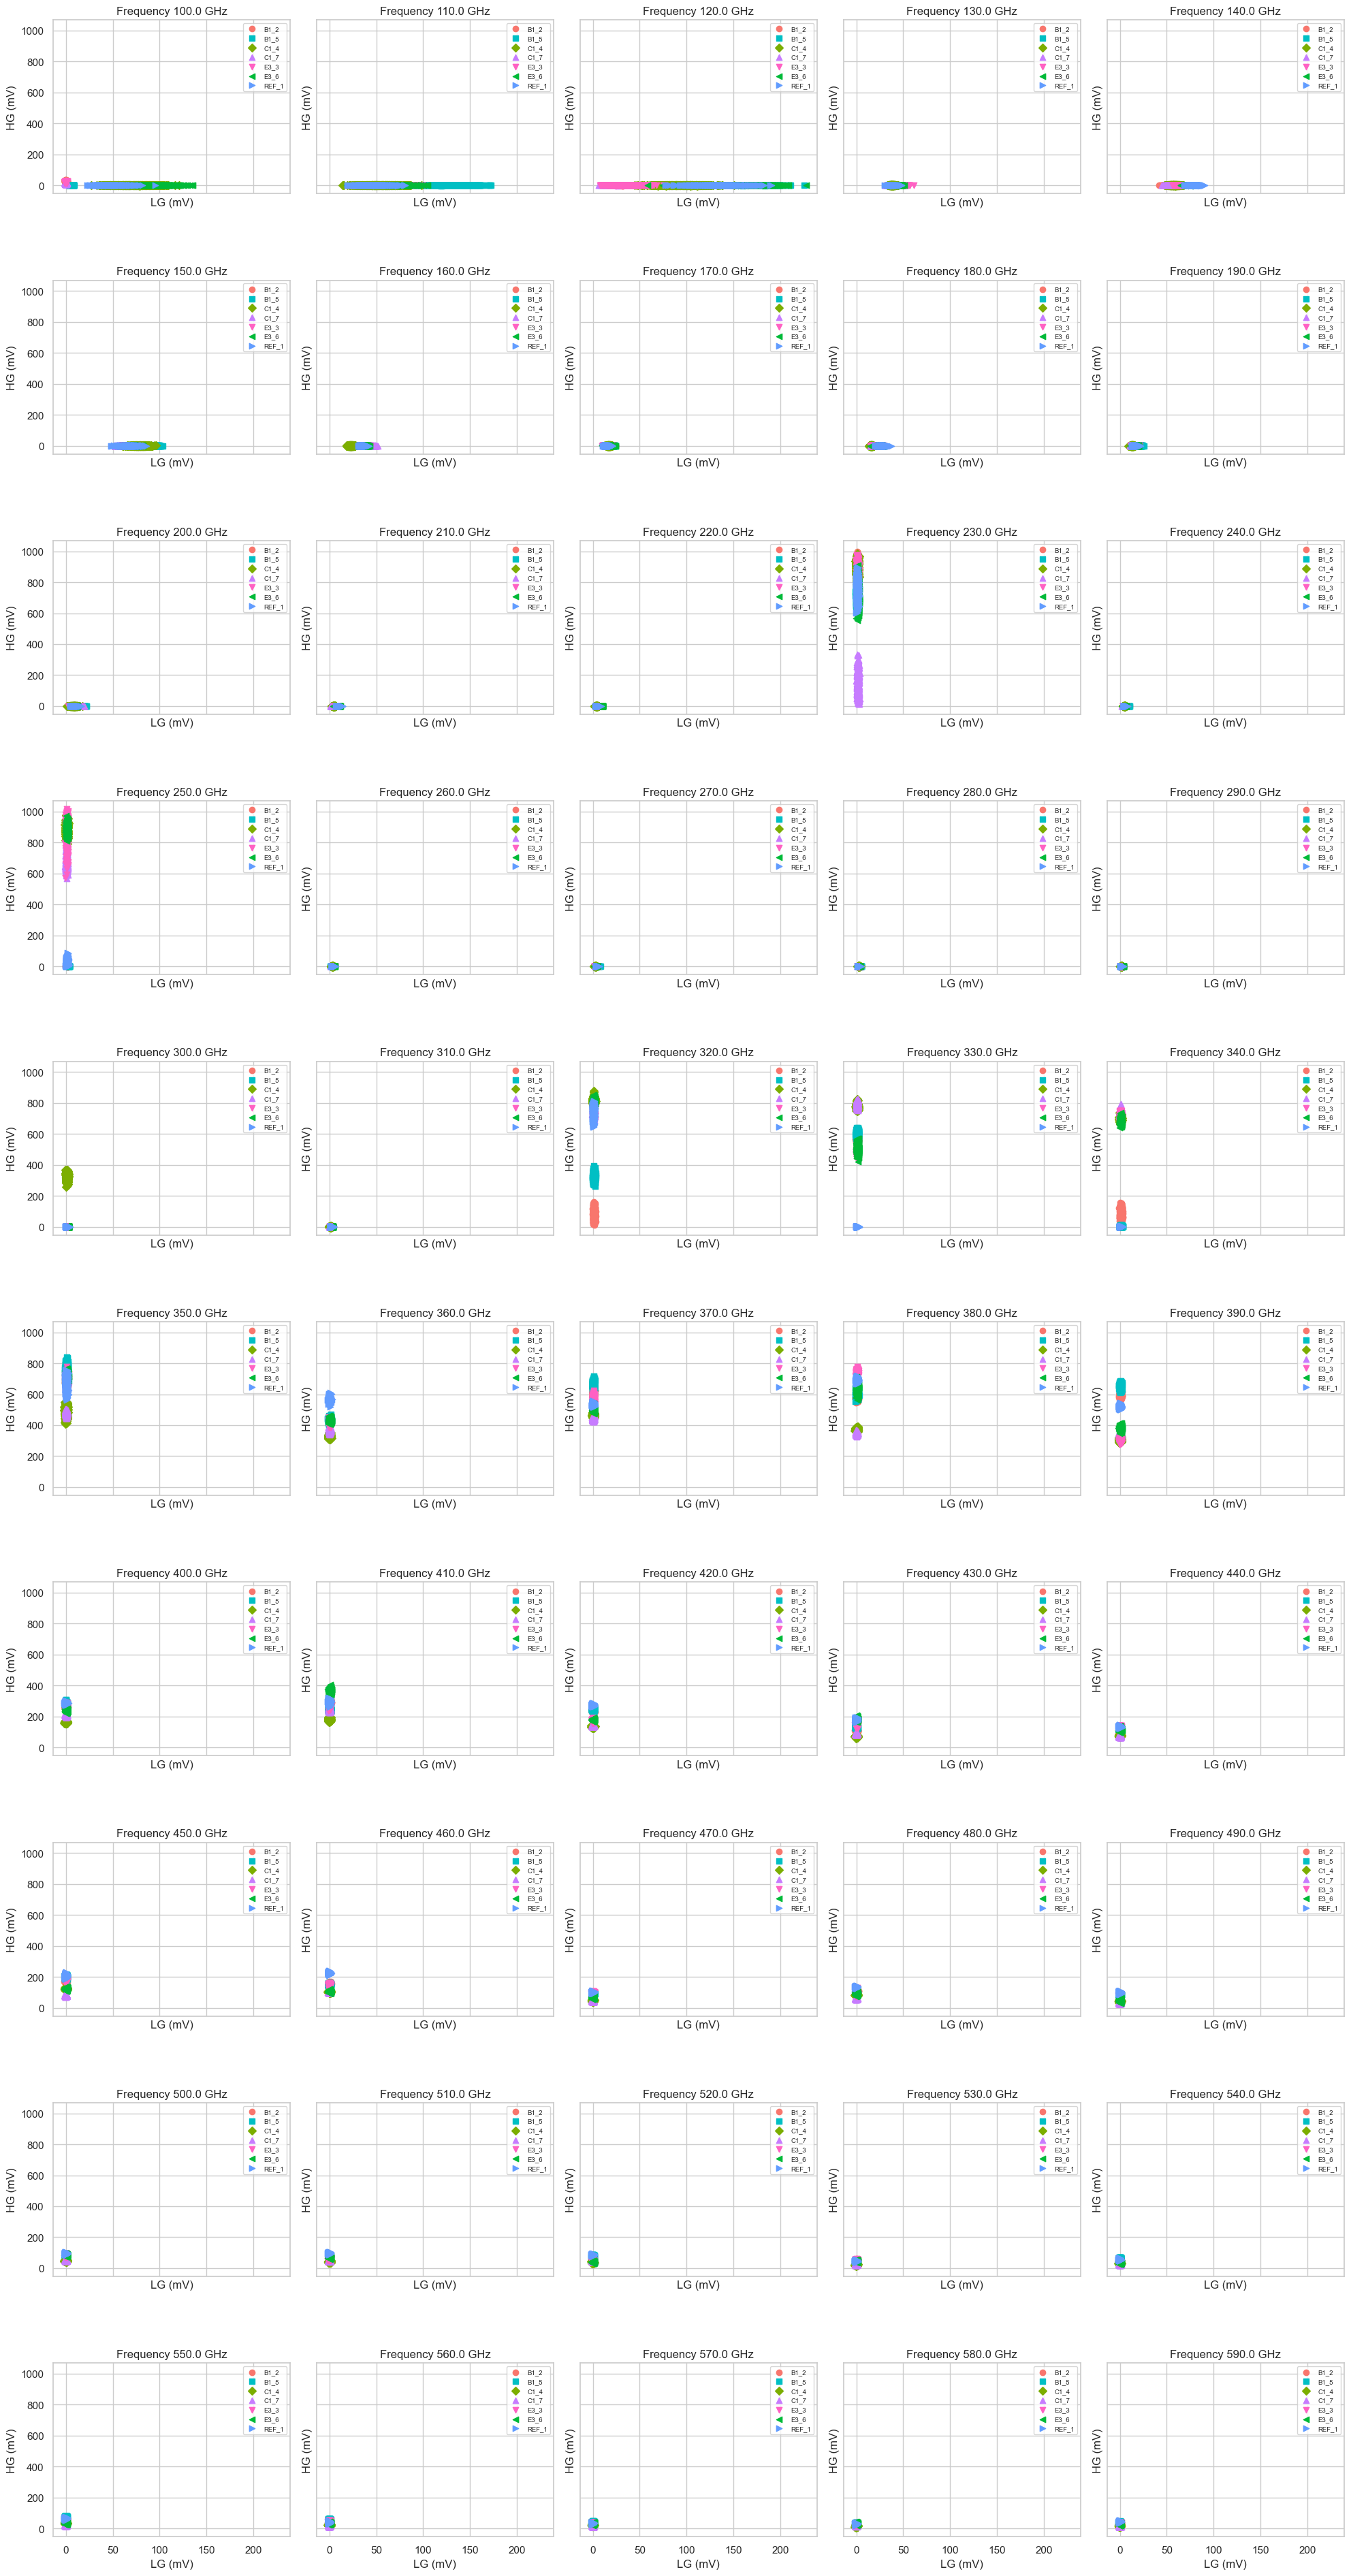

In [47]:
# Unsupervised clusterization of every sample for each frequency (do not use labels for the clustering, just for the visualization afterwards)
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Define the number of clusters
n_clusters = 7

# Define the pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=n_clusters, random_state=42))
])

# Define the frequencies and samples
frequencies = train_ex['Frequency (GHz)'].unique()
samples = train_ex['Sample'].unique()

# Define the 14 colors and markers
# Define 14 colors and markers
colors = ['#F8766D', '#00BFC4', '#7CAE00', '#C77CFF', '#FF61C3', '#00BA38', '#619CFF', '#F564E3', '#00A9FF', '#FF9F00', '#00BFC4', '#F8766D', '#7CAE00', '#C77CFF']
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'd', 'P', 'X']

# Create subplots
ncols = 5
nrows = int(np.ceil(len(frequencies) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(20, nrows * 4), sharex=True, sharey=True)

# Ensure axes is iterable
axes = axes.flatten()

# Loop over frequencies
for idx, f in enumerate(frequencies):
    n_samples = 0
    # Loop over samples
    for s in samples:
        # Filter the DataFrame
        df_tmp = train_ex[(train_ex['Frequency (GHz)'] == f) & (train_ex['Sample'] == s)]
        # Check if there are enough samples
        if len(df_tmp) >= n_clusters:
            # Fit the pipeline
            pipe.fit(df_tmp[['LG (mV)', 'HG (mV)']])
            # Get the cluster labels
            labels = pipe.named_steps['kmeans'].labels_
            # Plot the data
            axes[idx].scatter(df_tmp['LG (mV)'], df_tmp['HG (mV)'],
                              color=colors[n_samples % len(colors)],
                              marker=markers[n_samples % len(markers)],
                              label=s)
            axes[idx].set_title(f"Frequency {f} GHz")
            axes[idx].set_xlabel('LG (mV)')
            axes[idx].set_ylabel('HG (mV)')
            axes[idx].legend(fontsize='xx-small')
            n_samples += 1

# Hide any unused subplots
for ax in axes[len(frequencies):]:
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(hspace=0.5)

# # Save plots
# output_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_2_plastics/plots/all_samples_distribution_per_freq'
# if not os.path.exists(output_path):
#     os.makedirs(output_path)
# plt.savefig(f"{output_path}/data_distribution_per_freq_{freq}.png", dpi=500)
plt.show()


## Sample a test set

In [49]:
# train_set, test_set = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Sample']) 
test_percentage = 0.25
# train_set, test_set = train_test_split(df, test_size=test_percentage, random_state=42) 
# Shuffle the data
df_balanced_ = df_balanced.sample(frac=1, random_state=42)
train_set, test_set = train_test_split(df_balanced_, test_size=test_percentage, random_state=42) 

# stratify=df['Sample'] to keep the same proportion of samples in the train and test set


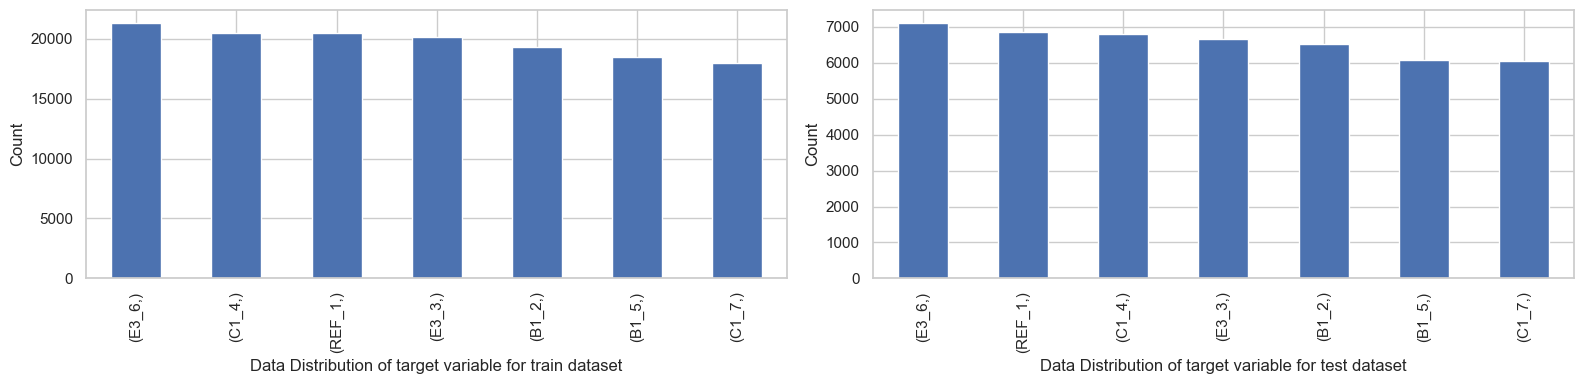

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

# Plot train set
train_set[['Sample']].value_counts().plot.bar(ax=ax[0], legend=False)
ax[0].set_xlabel('Data Distribution of target variable for train dataset')
ax[0].set_ylabel('Count')

# Plot test set
test_set[['Sample']].value_counts().plot.bar(ax=ax[1], legend=False)
ax[1].set_xlabel('Data Distribution of target variable for test dataset')
ax[1].set_ylabel('Count')

plt.tight_layout() 
plt.show()

In [51]:
train_ex = train_set.copy()

In [52]:
train_ex.info()
# train_ex.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 138141 entries, 116399 to 46212
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Frequency (GHz)  138141 non-null  float64
 1   LG (mV)          138141 non-null  float64
 2   HG (mV)          138141 non-null  float64
 3   Sample           138141 non-null  object 
dtypes: float64(3), object(1)
memory usage: 5.3+ MB


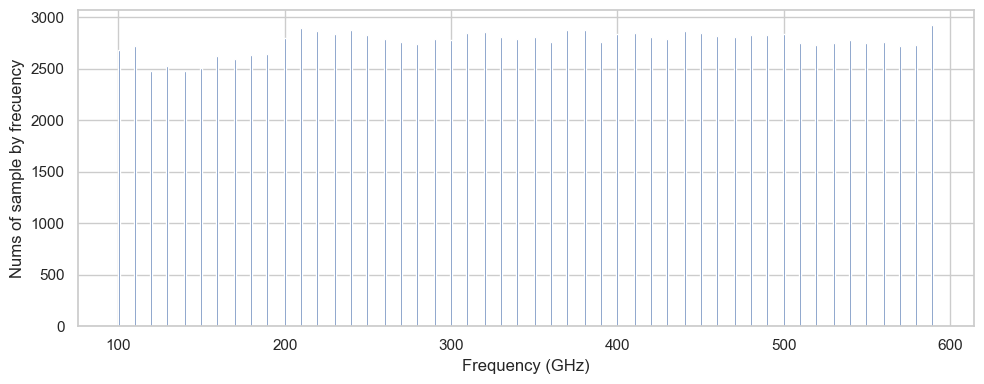

In [53]:

ax = train_ex['Frequency (GHz)'].plot.hist(figsize=(10, 4), bins=408)
# ax = test_set['Frequency (GHz)'].plot.hist(ax=ax, bins=408)
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('Nums of sample by frecuency')
plt.tight_layout()
plt.show()

In [54]:
# Calculate the percentage of data used for each window
time_window_s = 0.1
data_percentage = (100/(27*(1-test_percentage)))*time_window_s
data_percentage_test = (100/(27*(test_percentage)))*time_window_s

data_percentage = 0
data_percentage_test = 0

print(f"Data percentage: {data_percentage}%")
print(f"Data percentage test: {data_percentage_test}%")

# Load just a % of the data
# df_sample = train_set.sample(frac=0.02, random_state=42)

# Introduce Frequency values as input variables
train_set_test = freq_as_variable(train_set, data_percentage)
test_set_test = freq_as_variable(test_set, data_percentage_test)

# If a row has any NaN value, remove that row
train_set_test = train_set_test.dropna()
test_set_test = test_set_test.dropna()

#Save the processed data to a CSV file

output_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/train_set.csv'
output_path_test = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test_set.csv'
# output_path = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/train_set.csv'
# output_path_test = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test_set.csv'

# train_set_test.to_csv(output_path, sep = ';', index=False)
# test_set_test.to_csv(output_path_test, sep = ';', index=False)



Data percentage: 0%
Data percentage test: 0%


In [55]:
print(f"Train set shape: {train_set_test.shape}")
print(f"Test set shape: {test_set_test.shape}")
print(train_set_test.head())
print(test_set.shape)


Train set shape: (2244, 101)
Test set shape: (712, 101)
   100.0 HG (mV)  100.0 LG (mV)  110.0 HG (mV)  110.0 LG (mV)  120.0 HG (mV)  \
0      31.803198       0.030521      -0.244153      34.092296       0.244159   
1      29.147845      -0.152607      -0.122088      43.889634       0.366271   
2      27.072396      -0.091564       0.518858      51.947258       0.030529   
3      32.352582      -0.457820       0.152594      46.331339       0.030512   
4      28.842632      -0.793554       0.061047      48.773043      -1.129282   

   120.0 LG (mV)  130.0 HG (mV)  130.0 LG (mV)  140.0 HG (mV)  140.0 LG (mV)  \
0      25.912587       0.152600      44.713710      -0.549370      50.360151   
1      30.094007      -0.122082      36.320351       0.183129      51.275790   
2      34.946893       0.213659      41.722622       1.037705      56.678061   
3      43.950678      -0.366271      46.331339       0.518864      52.527163   
4      39.769259       0.183135      45.293614      -0.366265  

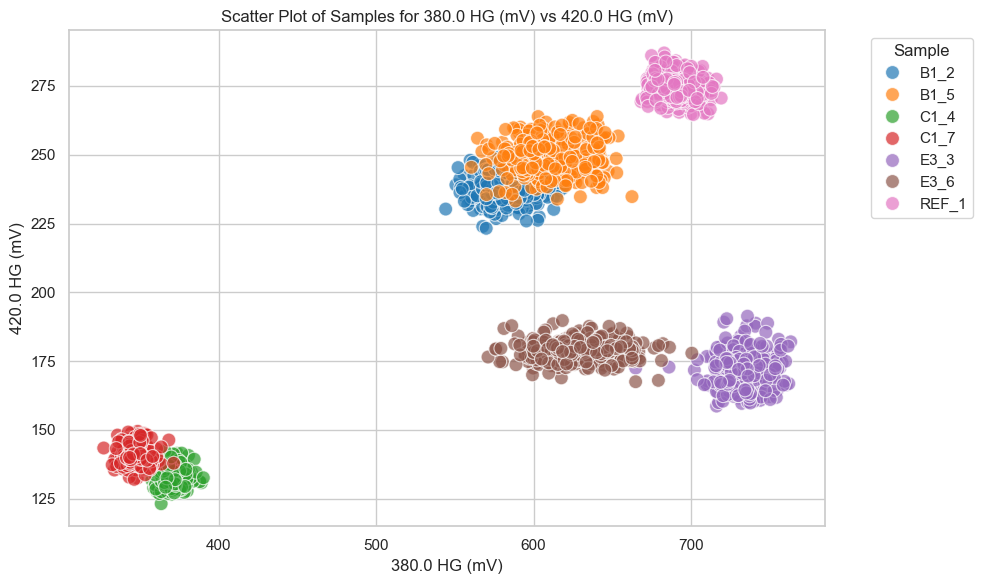

In [ ]:
# Define the two frequencies to be used as axes
var1 = '380.0 HG (mV)'
var2 = '420.0 HG (mV)'

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_set_test, x=var1, y=var2, hue='Sample', palette='tab10', s=100, alpha=0.7)

# Add labels and title
plt.xlabel(f'{var1}')
plt.ylabel(f'{var2}')
plt.title(f'Scatter Plot of Samples for {var1} vs {var2}')

# Customize legend
plt.legend(title='Sample', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()


In [59]:
# Model Parameters
input_size = X_train.shape[1]
output_size = len(np.unique(y_train))
seed = set_seed(42)

input_size, output_size

# print(f'input_size: {input_size}, output_size: {output_size}')
# print(X_train, y_train)

(100, 7)